# M2 TIDE : Application des connaissances

In [7]:
# Import des packages
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import scipy.stats as st
import os
import sys

sys.path.insert(0, str(Path(os.getcwd()).resolve().parent.parent))
from src.utils.tools import (
    rename_field_categories,
    distrib_for_cat_by_target,
    distrib_for_cont_by_target,
    boxplot_by_target,
    plot_generic,
    cramers_v_between_all,
    cramers_v_with_target,
    graph_correlations,
    extract_corr_pairs,
)

#### Objectif : prédire si le client va rembourser le crédit qu'il souhaite souscrire

# 0. Vérifier les prérequis (cf rubrique d'installation du [README.md](../README.md))


# 1. Import des données

<div class="alert alert-block alert-warning">
<b> Question 1:</b> Importez le fichier csv "credit_scoring.csv" dans un dataframe nommé "df". Puis vérifiez que l'import
s'est bien déroulé.
</div>

In [8]:
path = Path("../../data/raw/credit_scoring.csv").resolve() # chemin vers fichier csv
df = pd.read_csv(path,sep='|')

In [9]:
df.Cible.value_counts()
# df['Cible'].value_counts()

Cible
0    700
1    300
Name: count, dtype: int64

In [10]:
# Top5
df.head(5)

,Cible,Comptes,Duree_credit,Historique_credit,Objet_credit,Montant_credit,Epargne,Anciennete_emploi,Taux_effort,Situation_familiale,...,Anciennete_domicile,Biens,Age,Autres_credits,Statut_domicile,Nb_credits,Type_emploi,Nb_pers_charge,Telephone,Etranger
0,0,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,0,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,0,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,0,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,0,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


<div class="alert alert-block alert-warning">
<b> Question 2 :</b> Combien de lignes et champs mon dataframe "df" contient-il ?
</div>

In [11]:
print(f'Nb lignes : {len(df)}')
print(f'Nb champs : {len(df.columns)}')

Nb lignes : 1000
Nb champs : 21


# 2. Compréhension des données

### 2.1 Métadonnées 

<div class="alert alert-block alert-warning">
<b> Question 3:</b> Affichez le type de chaque champ de "df". Quel constat pouvez-vous faire ?
</div>

In [12]:
# Typage par champ
info_types = pd.DataFrame(df.dtypes,columns=['type'])
info_types.sort_values('type') #pour ordonner par le champ 'type'

,type
Cible,int64
Nb_pers_charge,int64
Type_emploi,int64
Nb_credits,int64
Statut_domicile,int64
Autres_credits,int64
Age,int64
Biens,int64
Anciennete_domicile,int64
Telephone,int64


<div class="alert alert-block alert-info">
<b>📝Note :</b> Ne pas confondre <b>type de stockage</b> et <b>type de variable</b>. En effet, on constate que nos variables catégorielles sont stockées en int.
</div>

In [13]:
df_dtypes = df.dtypes.reset_index().rename(columns={'index':'Champ',0:'Type'})
df_dtypes

,Champ,Type
0,Cible,int64
1,Comptes,int64
2,Duree_credit,int64
3,Historique_credit,int64
4,Objet_credit,int64
5,Montant_credit,int64
6,Epargne,int64
7,Anciennete_emploi,int64
8,Taux_effort,int64
9,Situation_familiale,int64


In [14]:
# BONUS
for field in df.columns:
    df_dtypes.loc[df_dtypes['Champ']==field,'Modalités'] = str(sorted(df[field].unique().tolist()))
    df_dtypes.loc[df_dtypes['Champ']==field,'NbDistinctVal'] = df[field].nunique()

In [15]:
df_dtypes

,Champ,Type,Modalités,NbDistinctVal
0,Cible,int64,"[0, 1]",2.0
1,Comptes,int64,"[1, 2, 3, 4]",4.0
2,Duree_credit,int64,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",33.0
3,Historique_credit,int64,"[0, 1, 2, 3, 4]",5.0
4,Objet_credit,int64,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10]",10.0
5,Montant_credit,int64,"[250, 276, 338, 339, 343, 362, 368, 385, 392, ...",923.0
6,Epargne,int64,"[1, 2, 3, 4, 5]",5.0
7,Anciennete_emploi,int64,"[1, 2, 3, 4, 5]",5.0
8,Taux_effort,int64,"[1, 2, 3, 4]",4.0
9,Situation_familiale,int64,"[1, 2, 3, 4]",4.0


### 2.2 Remplacement des modalités (bonus)

Afin de gagner en lisibilité, nous allons labelliser les modalités pour nos variables catégorielles

In [16]:
dict_labels = {
    "Comptes": {
        "init_values": [0, 1, 2, 3, 4],
        "new_values": ['< 0 €', '[ 0 € ; 200 € [', '> 200 €', 'Sans']
    },
    "Historique_credit": {
        "init_values": [-1, 0, 1, 2, 3, 4],
        "new_values": [
            'Impayés passés',
            'Impayé en cours (autre banque)',
            'Jamais aucun crédit',
            'Crédits en cours sans retard',
            'Crédits en cours avec retard'
        ]
    },
    "Objet_credit": {
        "init_values": [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        "new_values": [
            'Voiture neuve',
            "Voiture d'occasion",
            'Mobilier / Equipement',
            'Radio / Télévision',
            'Appareils ménagers',
            'Travaux',
            'Etude',
            'Vacances',
            'Formation',
            'Business',
            'Autres'
        ]
    },
    "Epargne": {
        "init_values": [0, 1, 2, 3, 4, 5],
        "new_values": [
            '< 100 €',
            '[ 100 € ; 500 € [',
            '[ 500 € ; 1_000 € [',
            '> 1000 €',
            'Inconnu / Pas de compte'
        ]
    },
    "Anciennete_emploi": {
        "init_values": [0, 1, 2, 3, 4, 5],
        "new_values": [
            'sans emploi',
            '< 1 an',
            '[ 1 an ; 4 ans [',
            '[ 4 ans ; 7 ans [',
            '> 7 ans'
        ]
    },
    "Situation_familiale": {
        "init_values": [0, 1, 2, 3, 4, 5],
        "new_values": [
            'H: divorcé/séparé',
            'F: divorcée / séparée',
            'H: célibataire',
            'H: marié / veuf',
            'F: célibataire'
        ]
    },
    "Garanties": {
        "init_values": [0, 1, 2, 3],
        "new_values": ['Pas de garantie', 'Co-emprunteur', 'Garant']
    },
    "Biens": {
        "init_values": [0, 1, 2, 3, 4],
        "new_values": ['Immobilier', 'Assurance-vie', 'Voiture ou autre', 'Aucun bien connu']
    },
    "Autres_credits": {
        "init_values": [0, 1, 2, 3],
        "new_values": ['Banque', 'Etablissement de crédit', 'Aucun']
    },
    "Statut_domicile": {
        "init_values": [0, 1, 2, 3],
        "new_values": ['Locataire', 'Propriétaire', 'Hébergement gratuit']
    },
    "Type_emploi": {
        "init_values": [0, 1, 2, 3, 4],
        "new_values": [
            'Chômeur / Non-qualifié - Non-résident',
            'Non-qualifié - résident',
            'Employé qualifié / Fonctionnaire',
            'Cadre / Indépendant / Employé hautement qualifié / Dirigeant'
        ]
    },
    "Telephone": {
        "init_values": [0, 1, 2],
        "new_values": ['Néant', 'Oui, enregistré sous le nom du client']
    },
    "Etranger": {
        "init_values": [0, 1, 2],
        "new_values": ['Oui', 'Non']
    }
}

In [17]:
for field_name in dict_labels.keys():
    df = rename_field_categories(dataframe=df,field=field_name,init_values=dict_labels[field_name]["init_values"],new_values=dict_labels[field_name]["new_values"],replace=True)

### 2.3 Statistiques descriptives

<div class="alert alert-block alert-warning">
<b> Question 4:</b> Affichez le nombre de valeurs distinctes pour chaque champ de notre dataframe "df".
</div>

In [18]:
df_nunique = df.nunique().reset_index().rename(columns={'index':'Champ',0:'Nb_Distinct_Values'})\
                .sort_values('Nb_Distinct_Values',ascending=False)

In [19]:
df_nunique

,Champ,Nb_Distinct_Values
5,Montant_credit,923
13,Age,53
2,Duree_credit,33
4,Objet_credit,10
3,Historique_credit,5
7,Anciennete_emploi,5
6,Epargne,5
17,Type_emploi,4
1,Comptes,4
9,Situation_familiale,4


<div class="alert alert-block alert-warning">
<b> Question 5:</b> Considérez les variables avec <= 10 modalités comme des catégorielles. Pour ce faire, utilisez <code>.astype('category')</code>. <b>Pensez à exclure la variable cible </b>. Vérifiez que lesdites variables sont maintenant de type category.
</div> 

In [20]:
target = 'Cible' # Nom de ma variable cible => les transformations ne doivent pas l'impacter
list_var_cat = df_nunique.loc[df_nunique['Nb_Distinct_Values']<=10,'Champ'].tolist()
list_var_cat = [i for i in list_var_cat if i !=target] # pour exclure la variable Cible de cette liste
df[list_var_cat] = df[list_var_cat].astype('category')

# Export du dataframe (on l'utilisera dans Preprocessing.ipynb)
path = Path("../../data/processed/credit_scoring_with_labels.parquet").resolve() # chemin vers fichier csv
df.to_parquet(path, index=False)

In [21]:
# Vérification
df_dtypes = df.dtypes.reset_index().rename(columns={'index':'Champ',0:'Type'})
df_nunique_dtypes= df_nunique.merge(df_dtypes,on=['Champ'],how='left')
df_nunique_dtypes

,Champ,Nb_Distinct_Values,Type
0,Montant_credit,923,int64
1,Age,53,int64
2,Duree_credit,33,int64
3,Objet_credit,10,category
4,Historique_credit,5,category
5,Anciennete_emploi,5,category
6,Epargne,5,category
7,Type_emploi,4,category
8,Comptes,4,category
9,Situation_familiale,4,category


In [22]:
list_var_num = df.select_dtypes(include=np.number).columns.tolist()
list_var_num = [i for i in list_var_num if i!=target]
print(f'Variables numériques: {", ".join(list_var_num)}')

Variables numériques: Duree_credit, Montant_credit, Age


<div class="alert alert-block alert-warning">
<b> Question 6:</b> Calculez quelques stats de base sur les champs de votre dataframe "df"
</div> 

In [23]:
#Info sur les variables numériques
df.describe(percentiles=[.25,.50,.75]).round(2)

,Cible,Duree_credit,Montant_credit,Age
count,1000.00,1000.00,1000.00,1000.00
mean,0.30,20.90,3271.25,35.54
std,0.46,12.06,2822.75,11.35
min,0.00,4.00,250.00,19.00
25%,0.00,12.00,1365.50,27.00
50%,0.00,18.00,2319.50,33.00
75%,1.00,24.00,3972.25,42.00
max,1.00,72.00,18424.00,75.00


In [24]:
print(f'Répartition variable "{target}":')
df[[target]].value_counts(normalize=False)

Répartition variable "Cible":


Cible
0        700
1        300
Name: count, dtype: int64

<div class="alert alert-block alert-warning">
<b> Question 7:</b> Créez les objets suivants (interdit de créer les listes à la main) :
<br>- Liste des variables catégorielles (nommé "var_cat") 
<br>- Liste des variables continues (nommé "var_num")
</div>

In [25]:
# Listes obtenues lors des questions précédents
print(f"""1. Variables explicatives numériques candidates: {", ".join(list_var_num)}""")
print(f"""2. Variables explicatives catégorielles candidates: {", ".join(list_var_cat)}""")
print(f"3. Variable cible: {target}")

1. Variables explicatives numériques candidates: Duree_credit, Montant_credit, Age
2. Variables explicatives catégorielles candidates: Objet_credit, Historique_credit, Anciennete_emploi, Epargne, Type_emploi, Comptes, Situation_familiale, Anciennete_domicile, Biens, Taux_effort, Nb_credits, Statut_domicile, Garanties, Autres_credits, Nb_pers_charge, Telephone, Etranger
3. Variable cible: Cible


<div class="alert alert-block alert-info">
<b>ℹ️ Aide :</b> Si vous n'avez pas réussi à créer les listes. Les voici pour ne pas être bloqué pour la suite :
</div>

In [26]:
list_var_num: list = ['Duree_credit', 'Montant_credit', 'Age']
list_var_cat: list = ['Objet_credit', 'Historique_credit', 'Epargne', 'Anciennete_emploi', 
           'Situation_familiale', 'Anciennete_domicile', 'Nb_credits', 'Biens', 
           'Type_emploi', 'Comptes', 'Taux_effort', 'Autres_credits', 'Statut_domicile', 
           'Garanties', 'Telephone', 'Nb_pers_charge', 'Etranger']
target: str = "Cible"

### 2.4 Représentations graphiques des catégorielles par rapport à la cible

<div class="alert alert-block alert-info">
<b>ℹ️ Aide :</b> en utilisant la fonction <code>distrib_for_cat_by_target</code>
</div>

### Variable `'Comptes'`

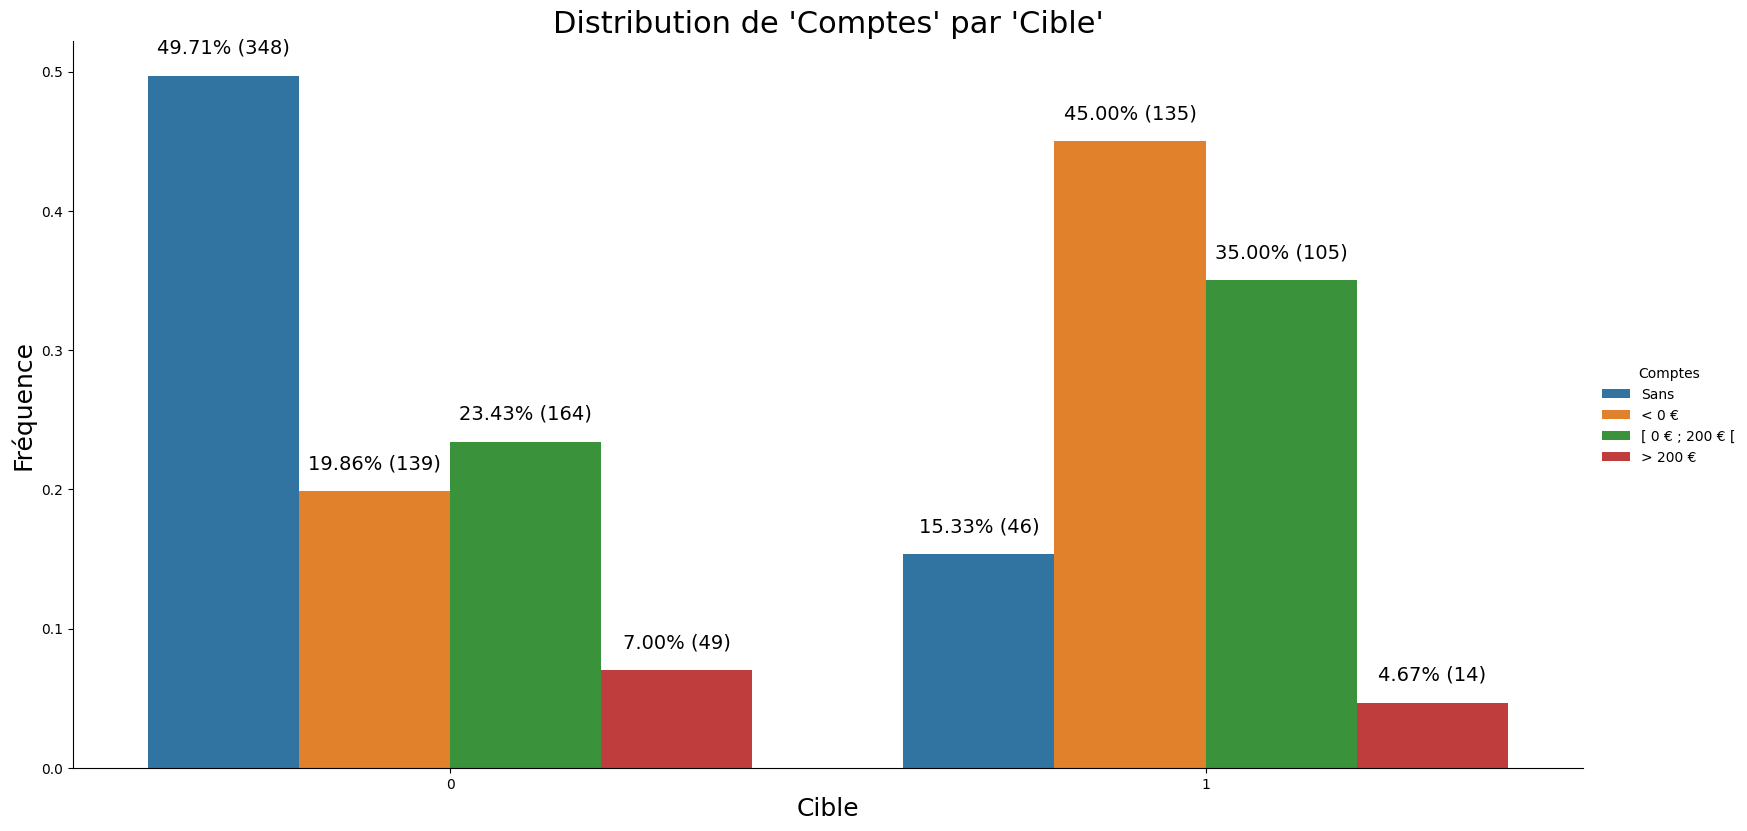

In [31]:
distrib_for_cat_by_target('Comptes',df,target)

<div class="alert alert-block alert-warning">
<b> Question 8:</b> Continuez sur les autres variables catégorielles. Vous pouvez passer par une boucle for pour itérer sur chaque variable
</div>

#### Variable `'Historique_credit'`

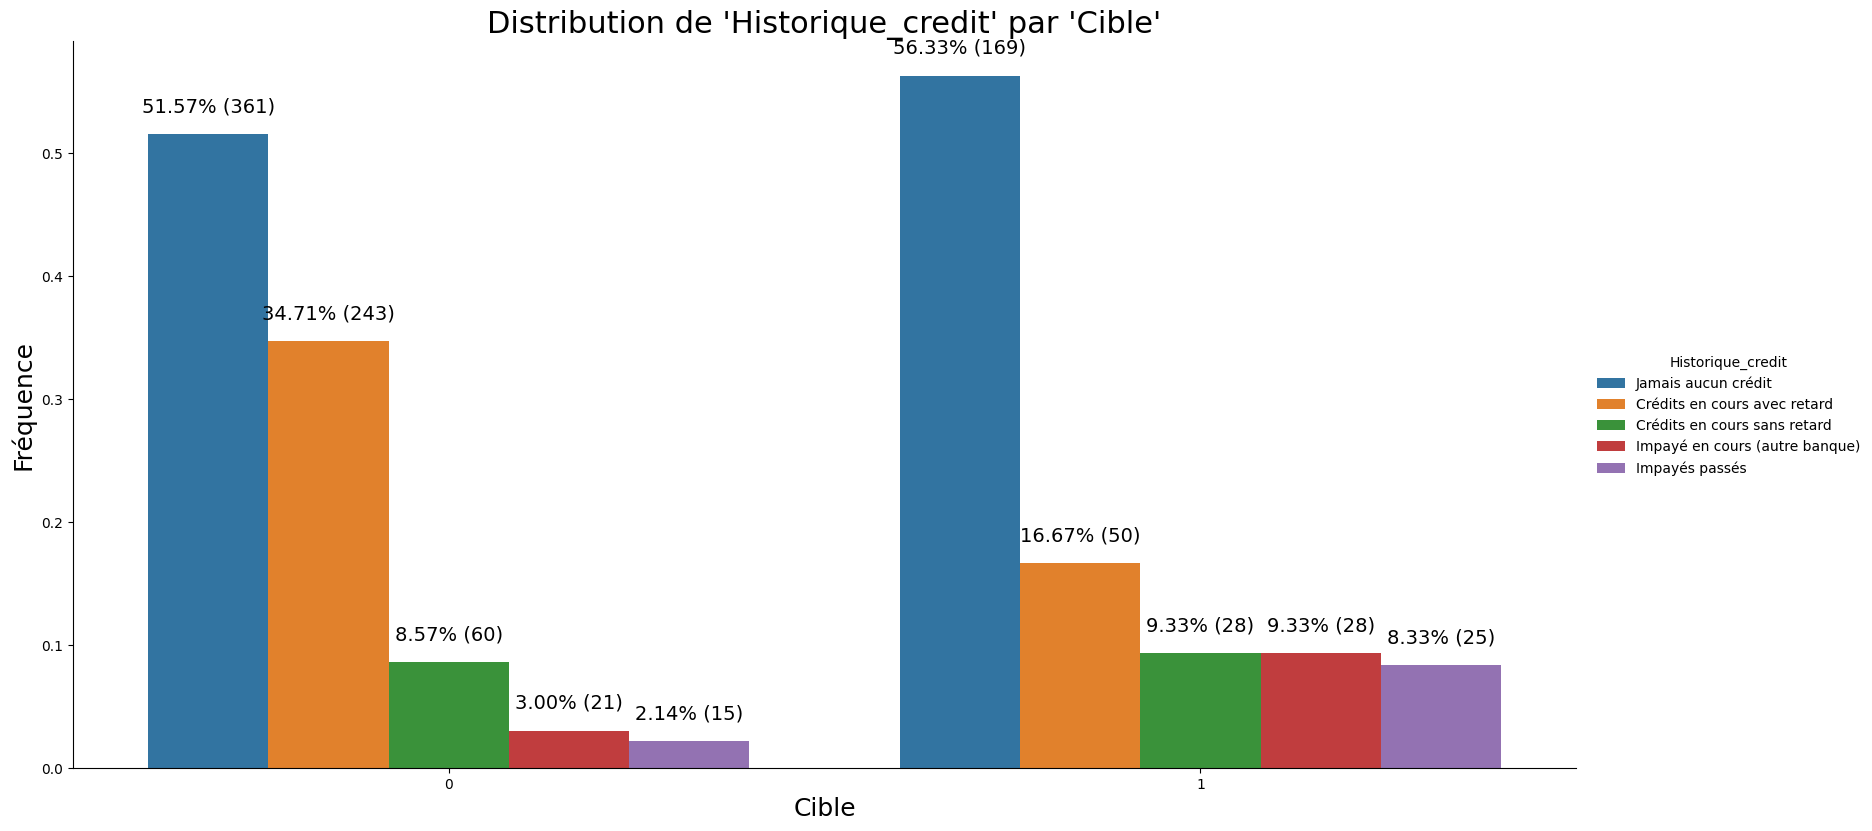

In [32]:
distrib_for_cat_by_target('Historique_credit', df, target)

### Variable `'Objet_credit'`

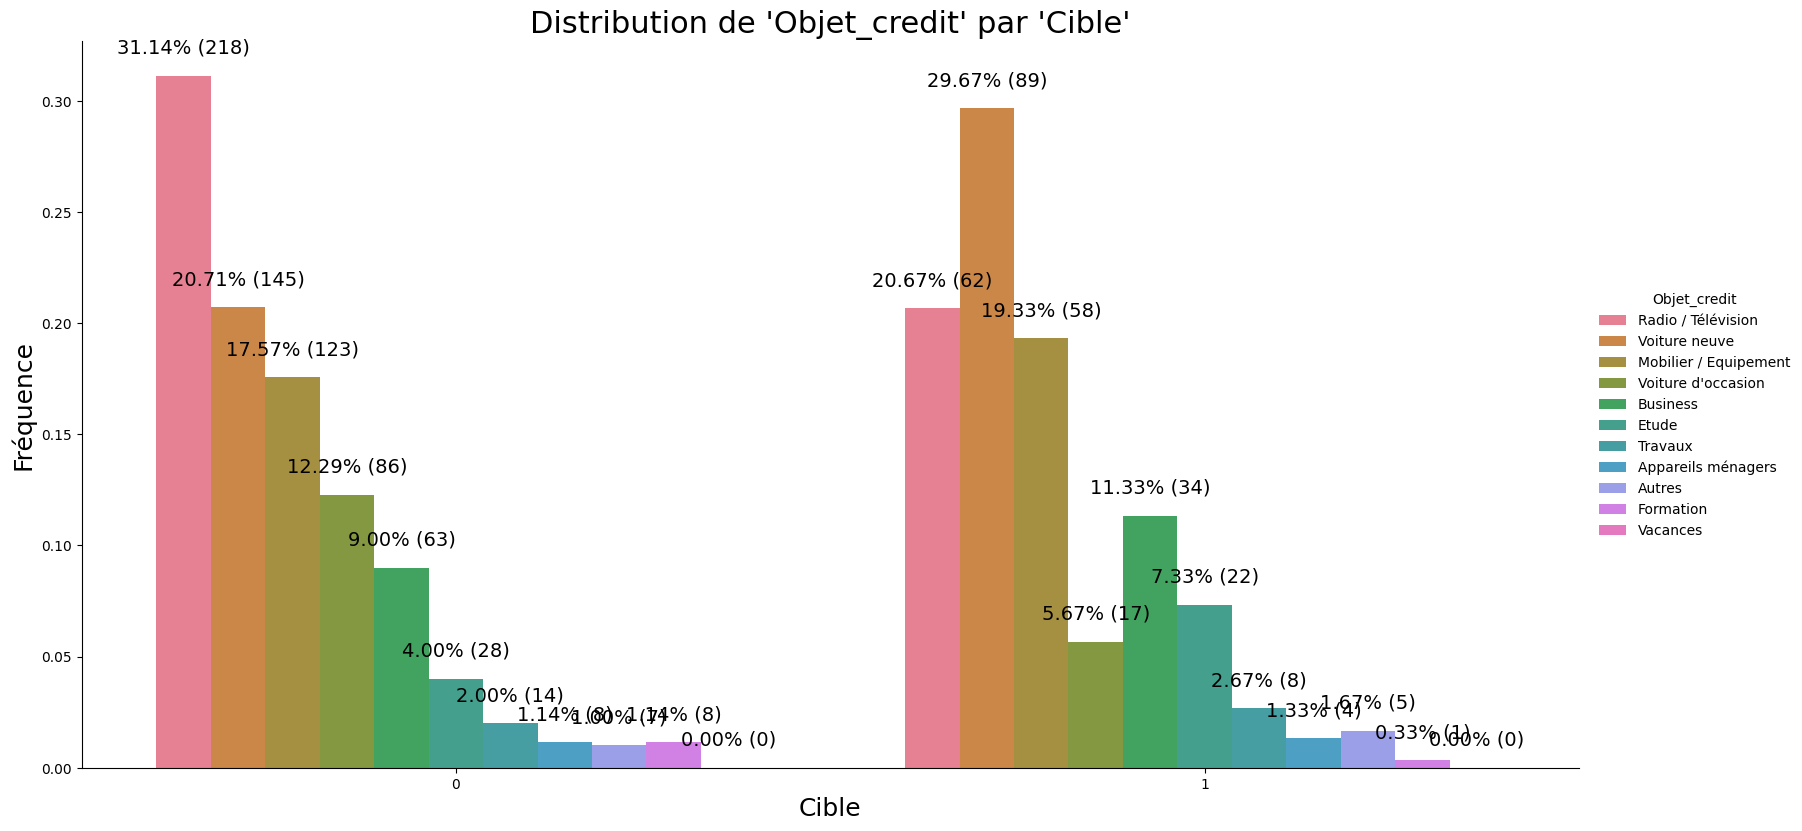

In [33]:
distrib_for_cat_by_target('Objet_credit',df,target)

### Variable `'Epargne'`

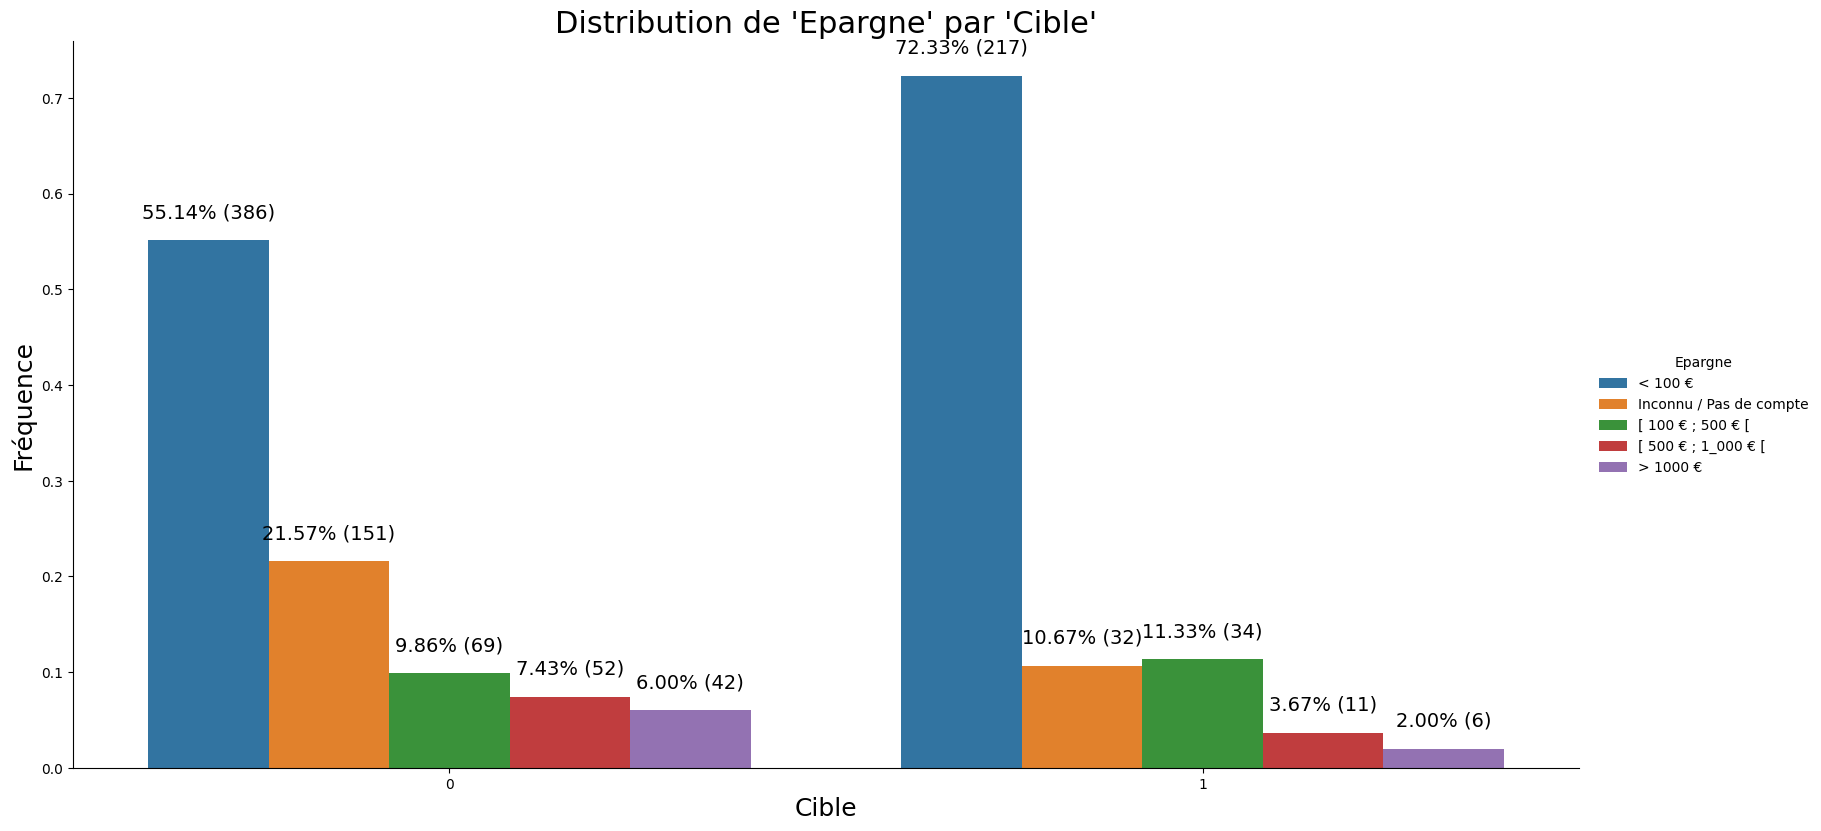

In [34]:
distrib_for_cat_by_target('Epargne',df,target)

### Variable `'Anciennete_emploi'`

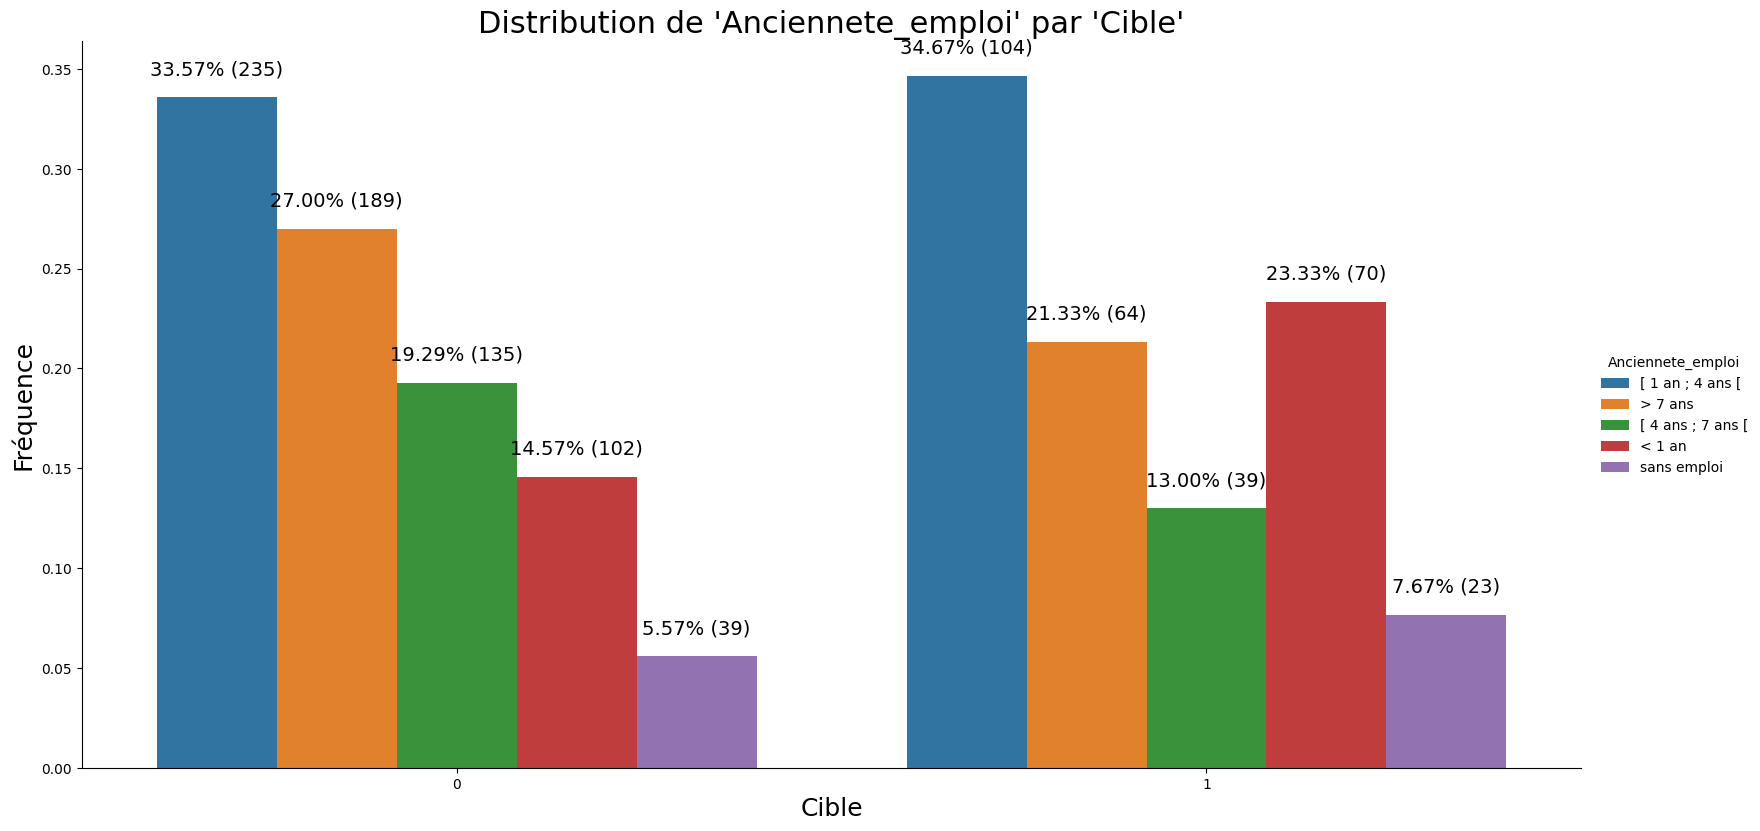

In [35]:
distrib_for_cat_by_target('Anciennete_emploi',df,target)

### Variable `'Situation_familiale'`

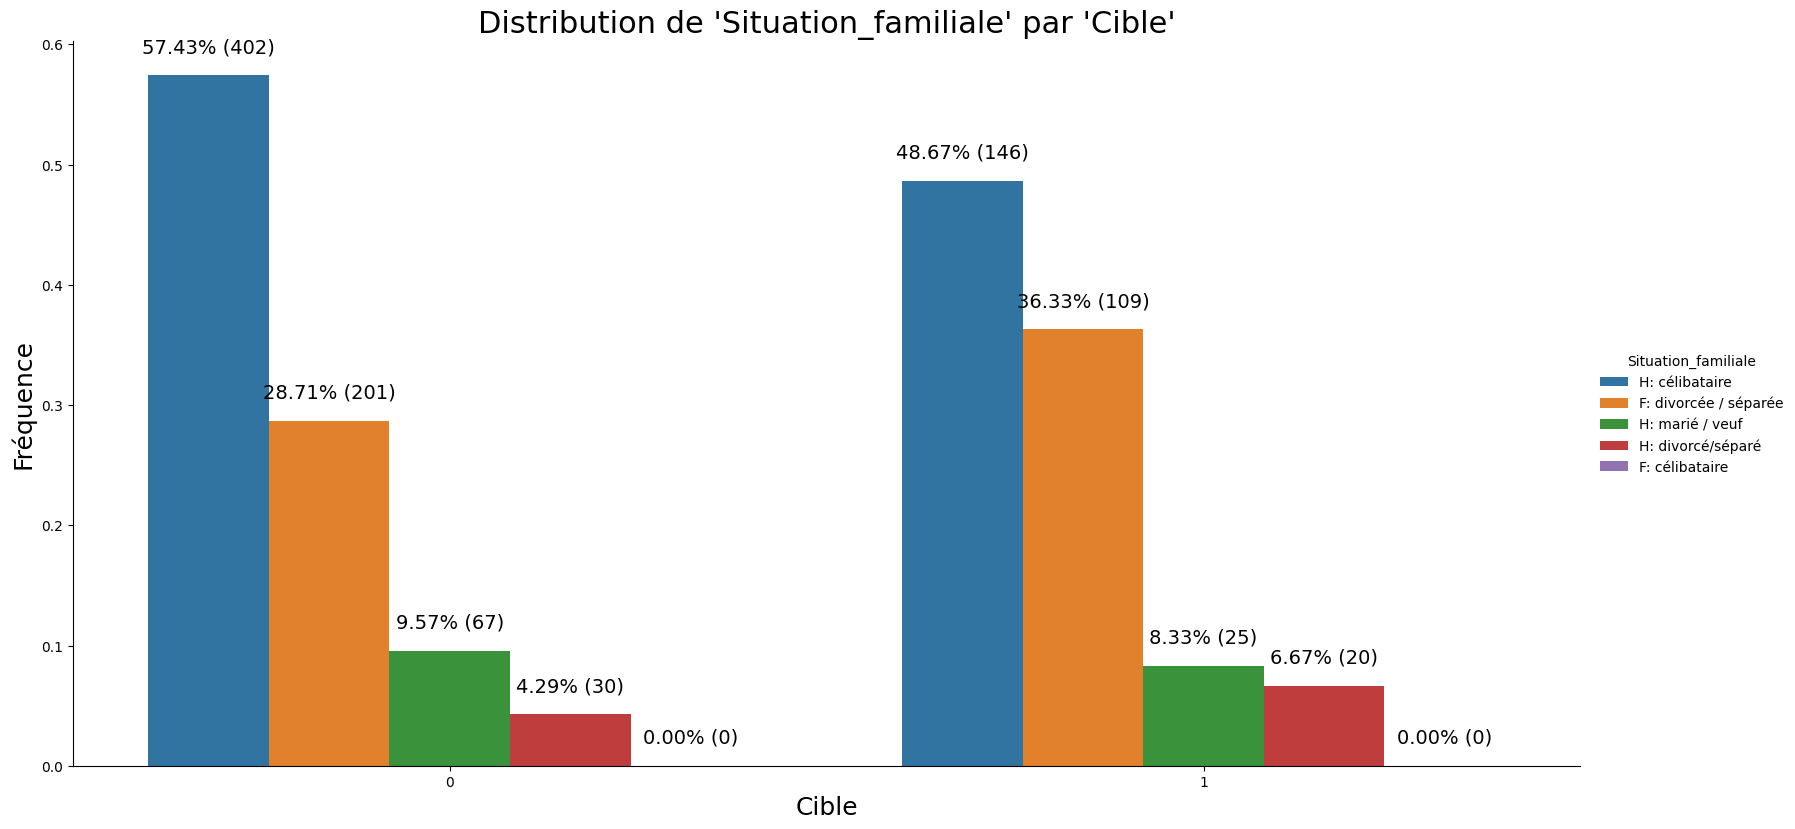

In [36]:
distrib_for_cat_by_target('Situation_familiale',df,target)

### Variable `'Garanties'`

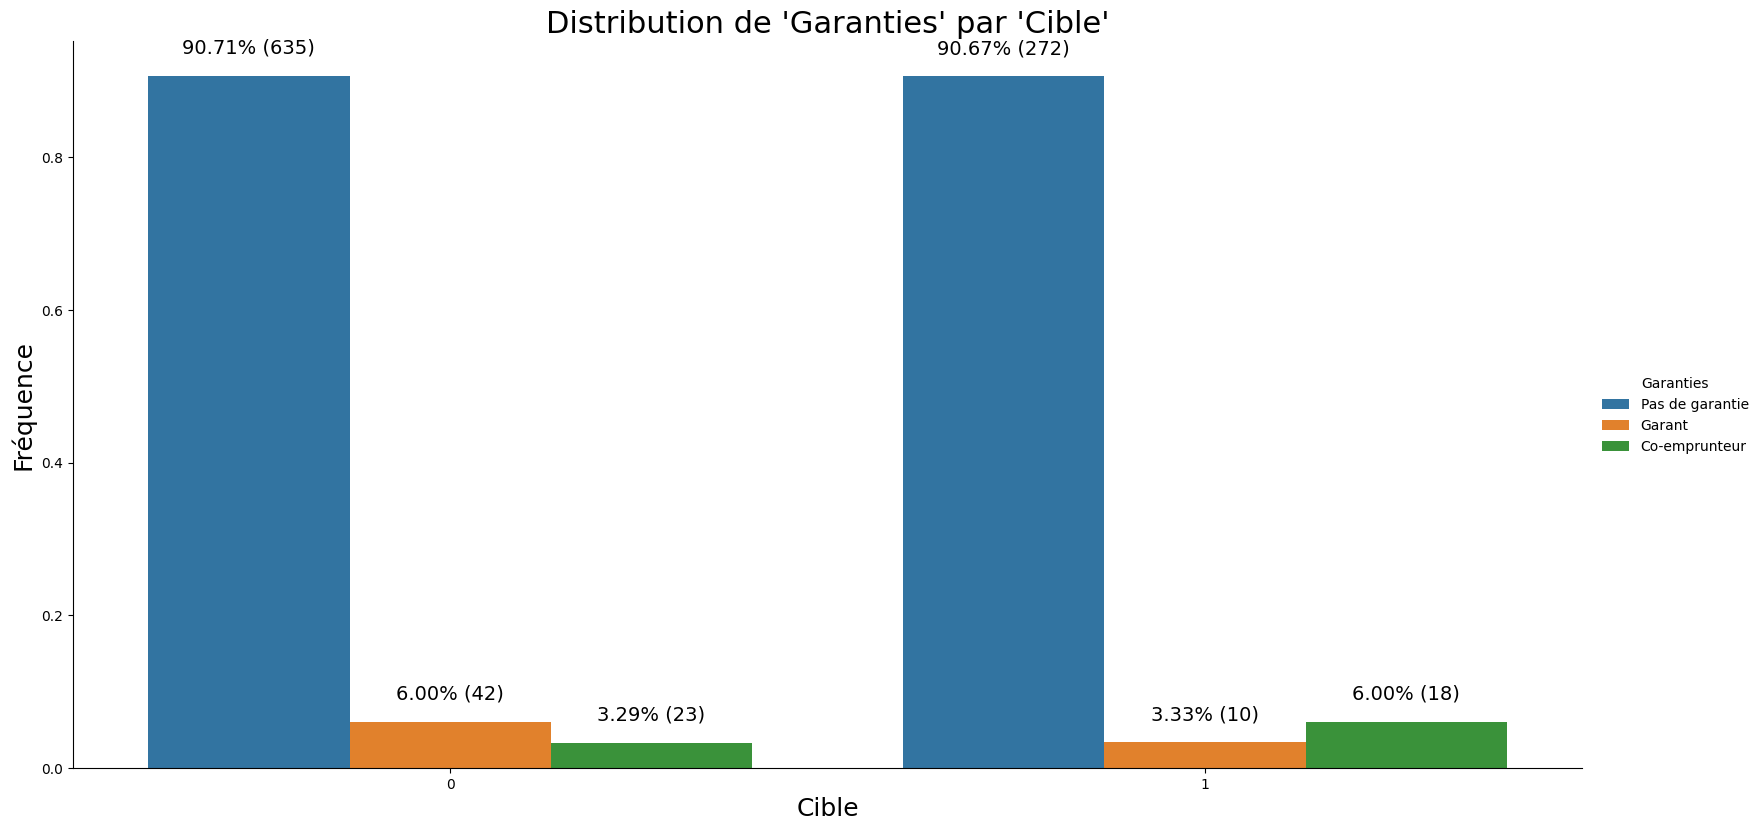

In [37]:
distrib_for_cat_by_target('Garanties',df,target)

### Variable `'Biens'`

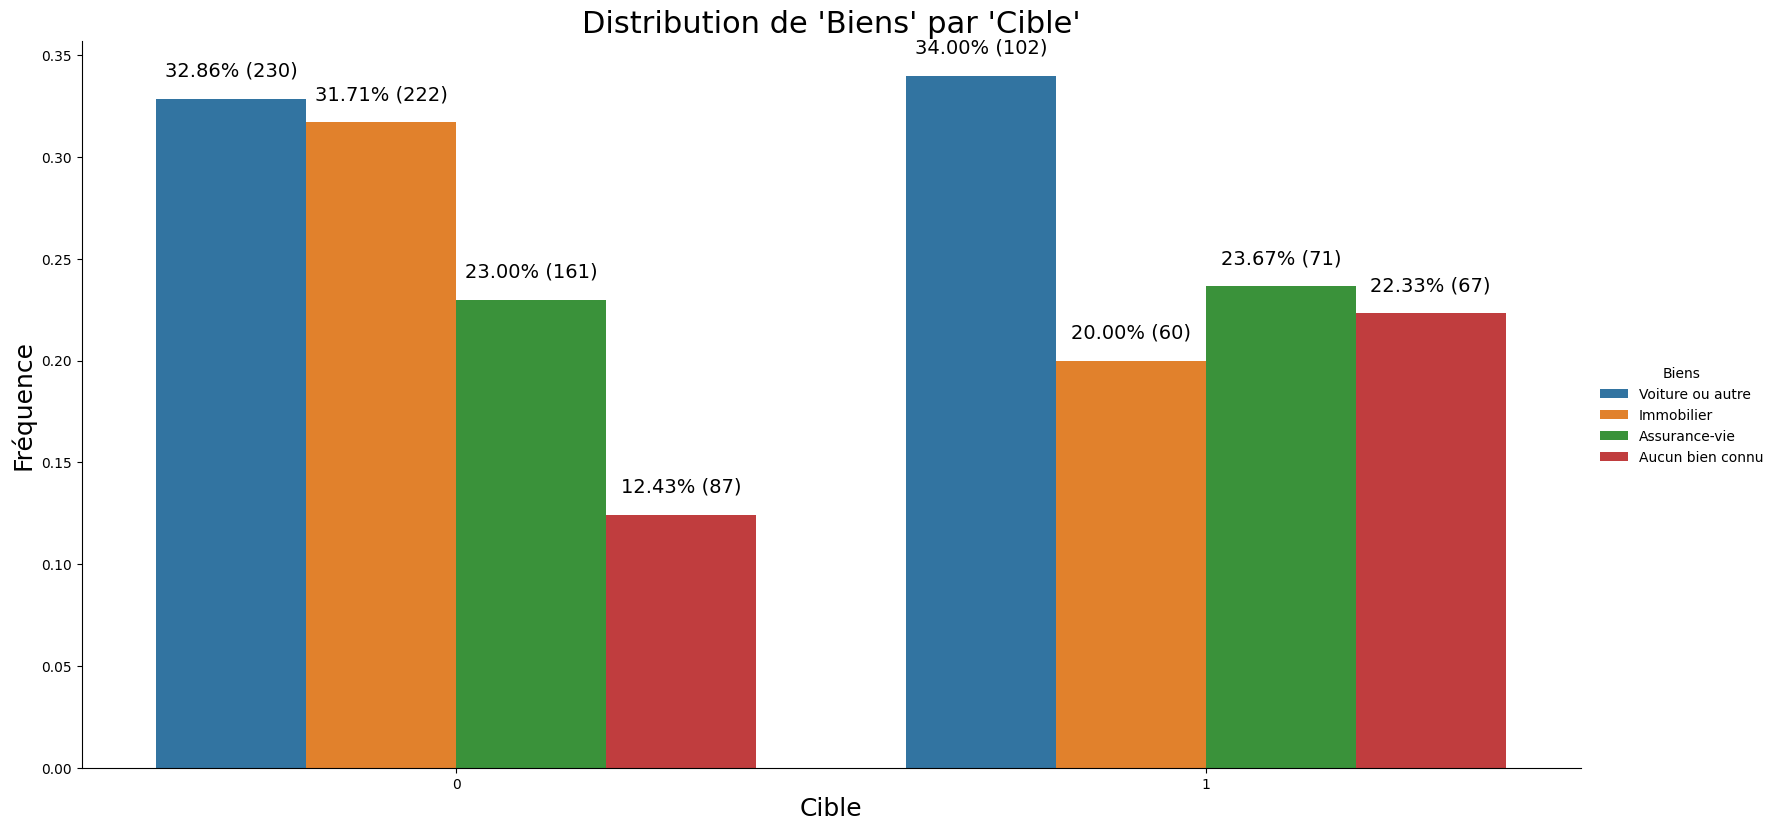

In [38]:
distrib_for_cat_by_target('Biens',df,target)

### Variable `'Autres_credits'`

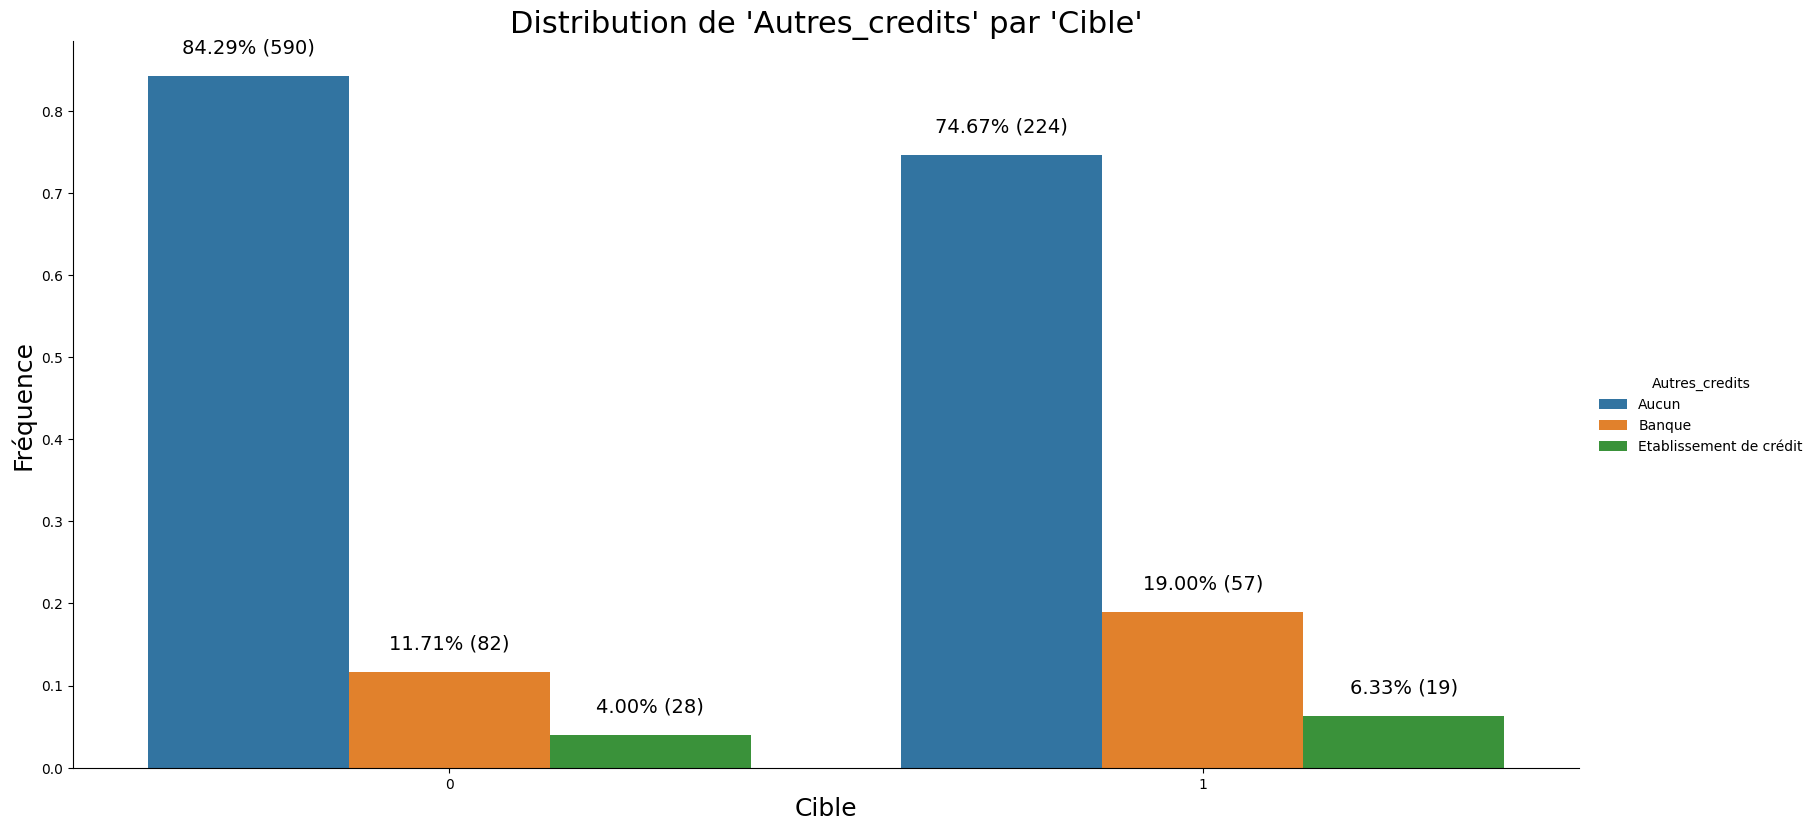

In [39]:
distrib_for_cat_by_target('Autres_credits',df,target)

### Variable `'Statut_domicile'`

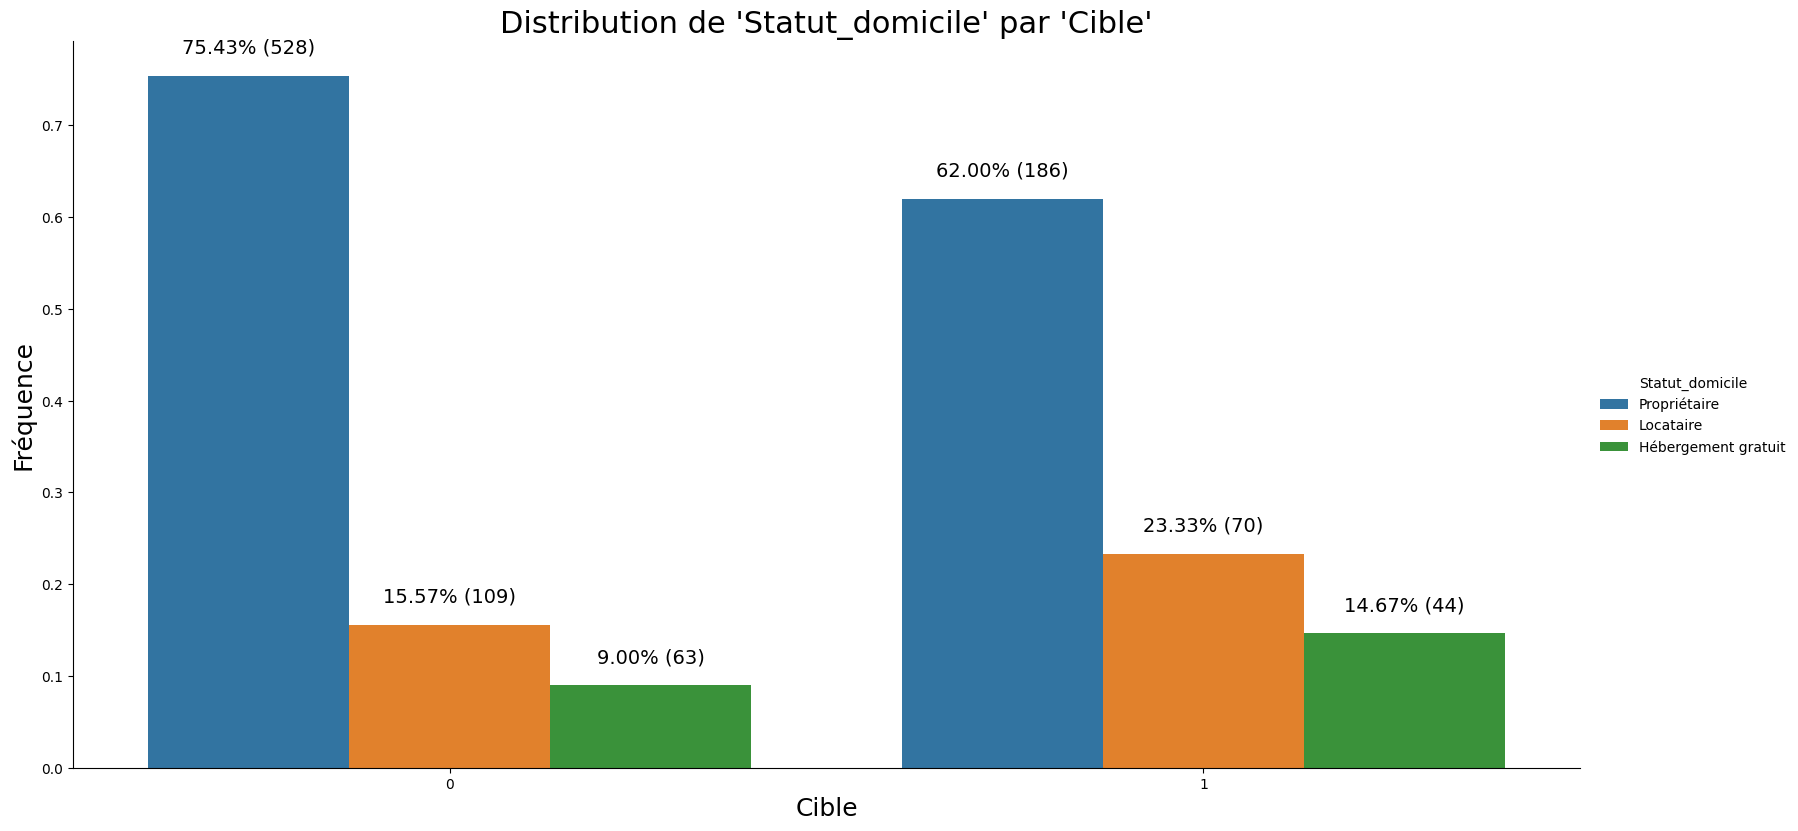

In [40]:
distrib_for_cat_by_target('Statut_domicile',df,target)

### Variable `'Type_emploi'`

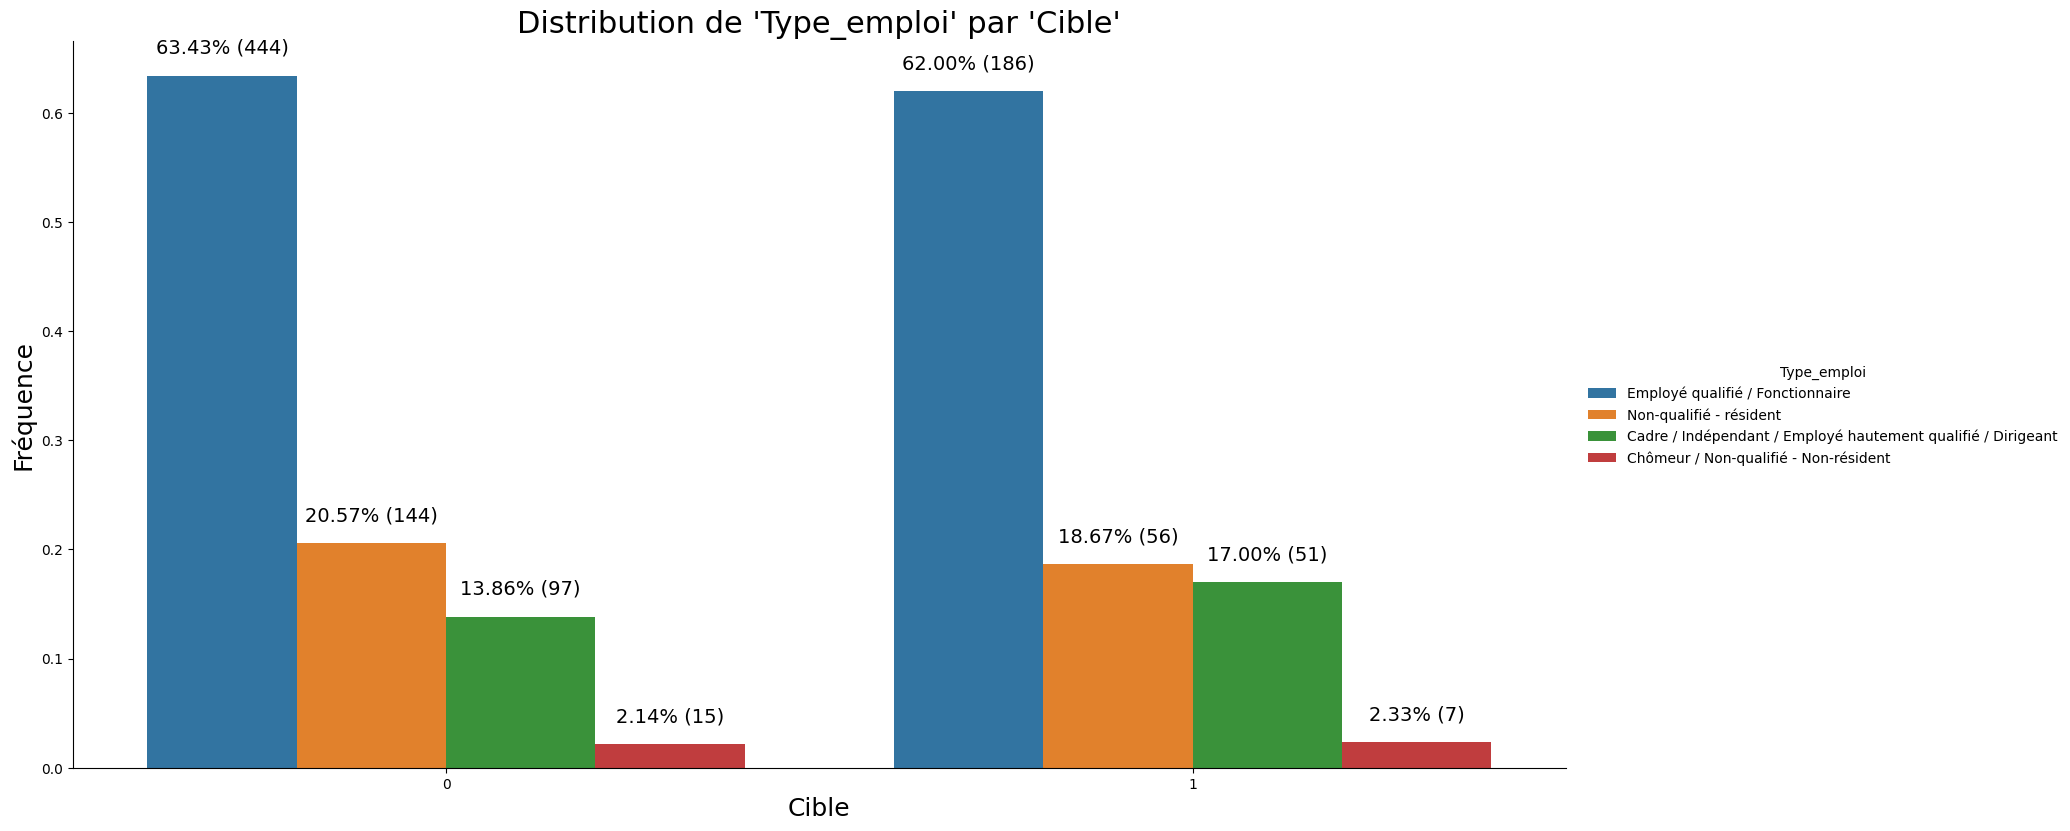

In [41]:
distrib_for_cat_by_target('Type_emploi',df,target)

### Variable `'Telephone'`

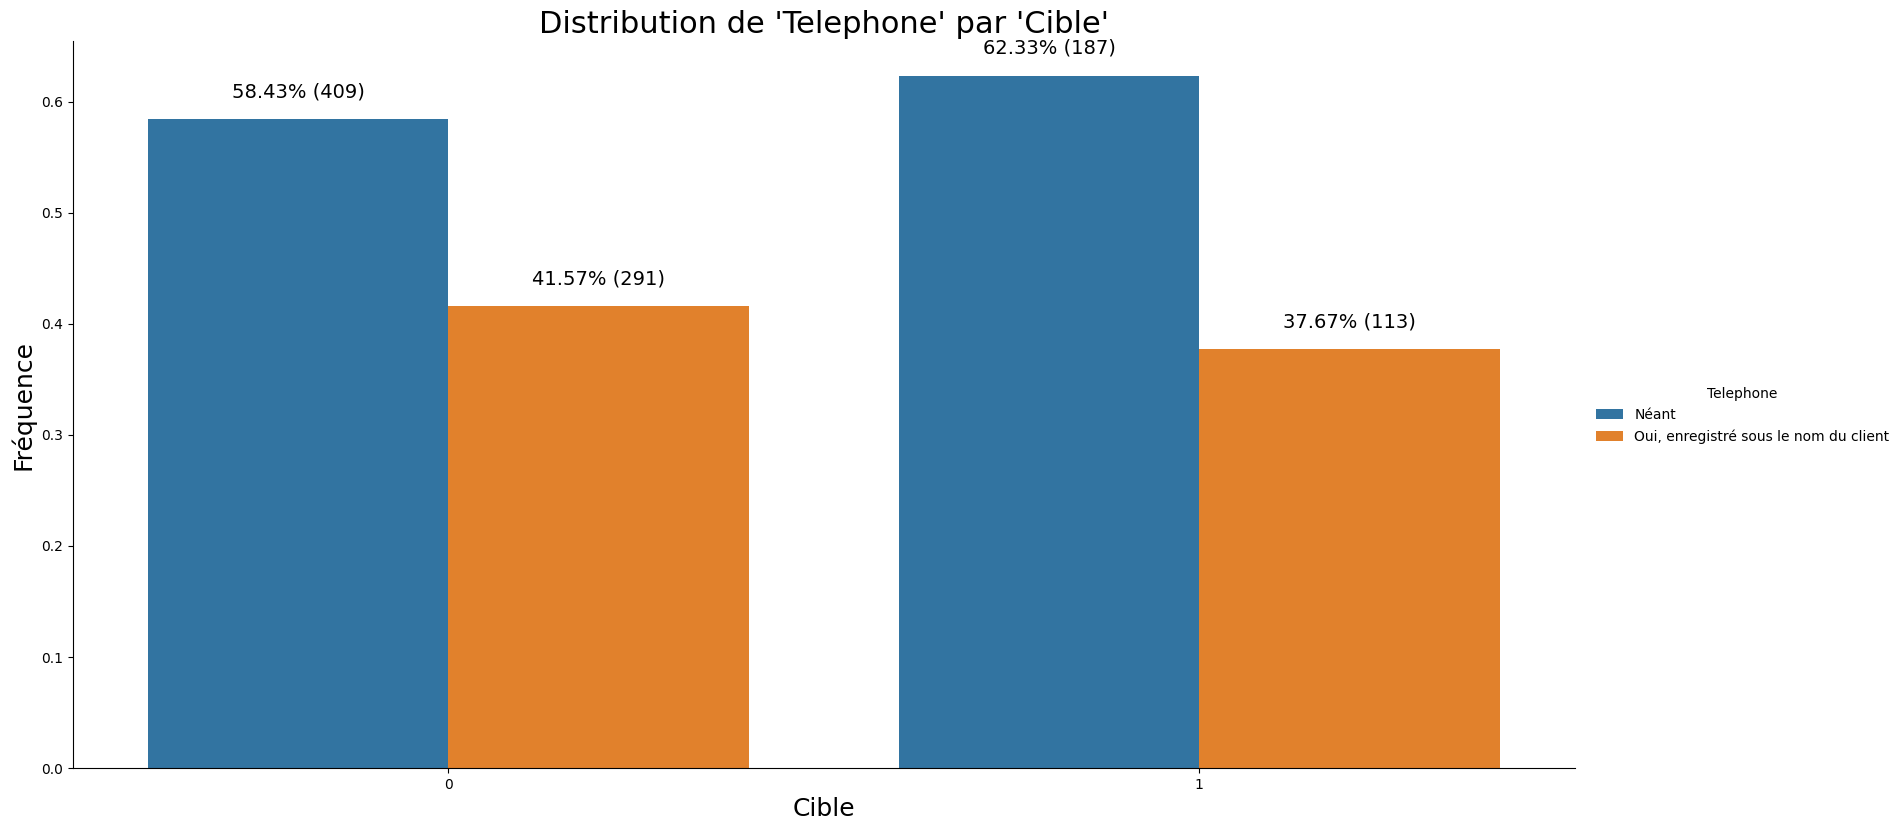

In [42]:
distrib_for_cat_by_target('Telephone',df,target)

### Variable `'Etranger'`

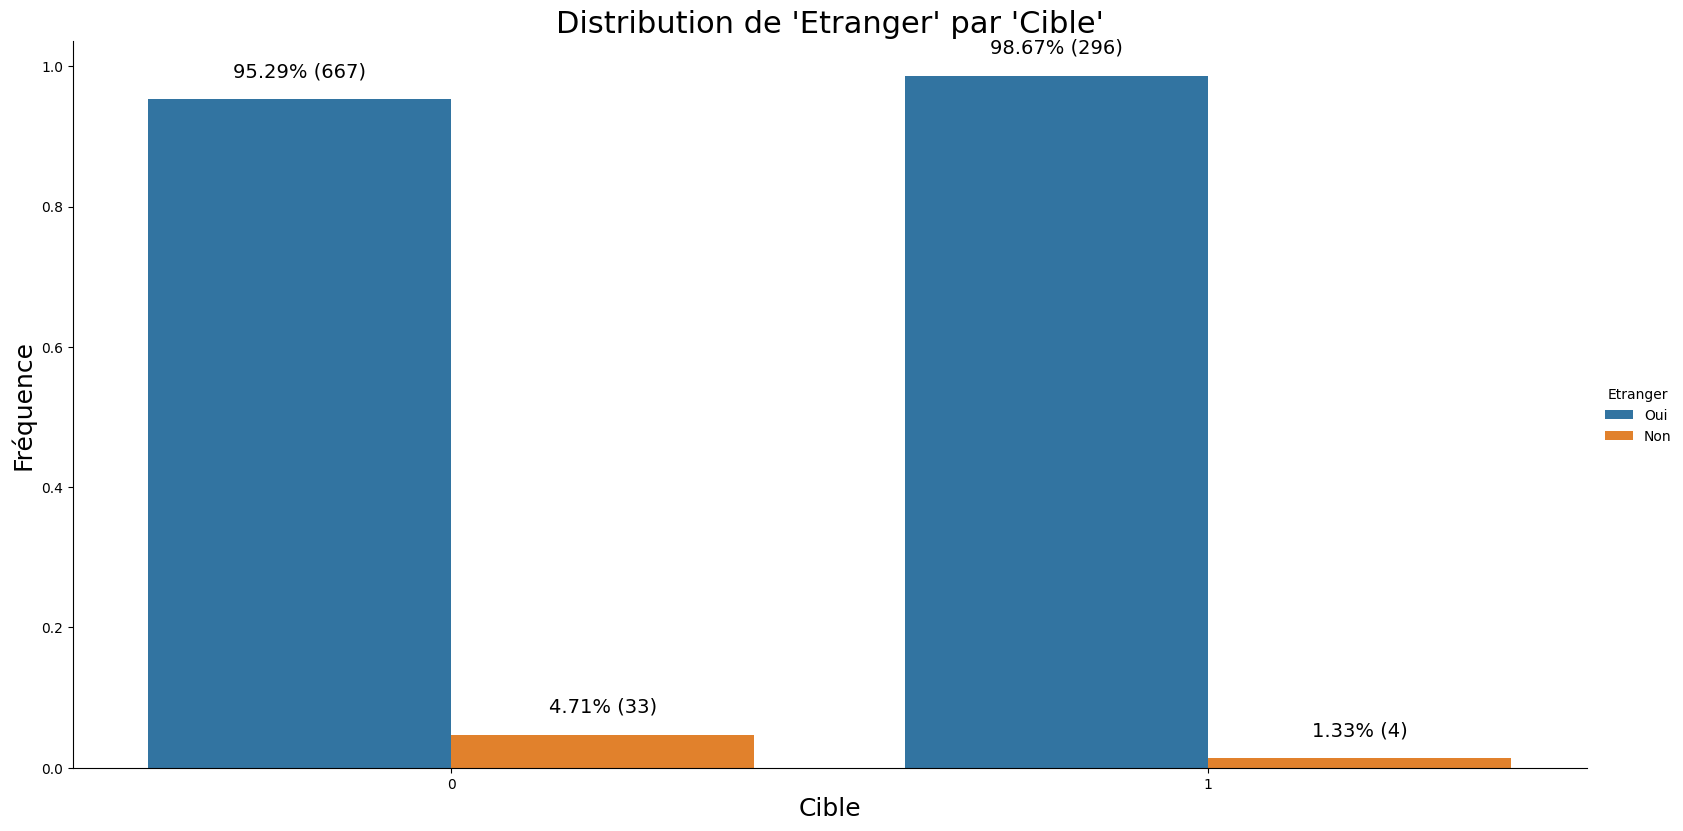

In [43]:
distrib_for_cat_by_target('Etranger',df,target)

### 2.5 Représentations graphiques des continues par rapport à la cible

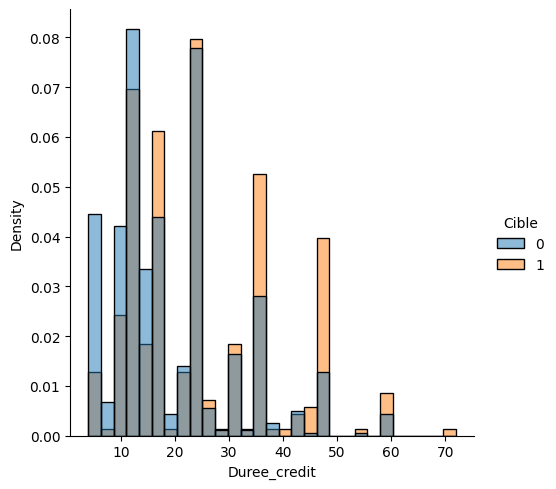

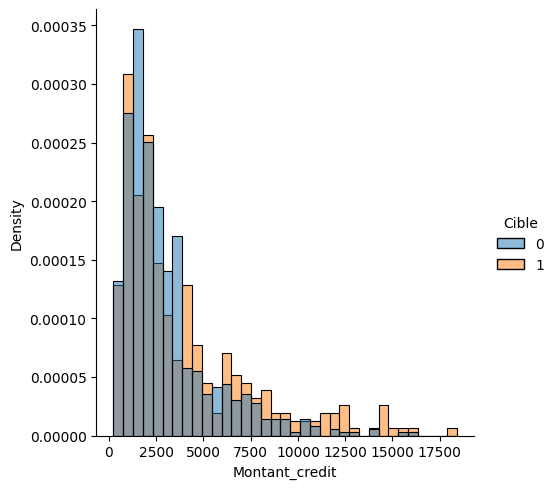

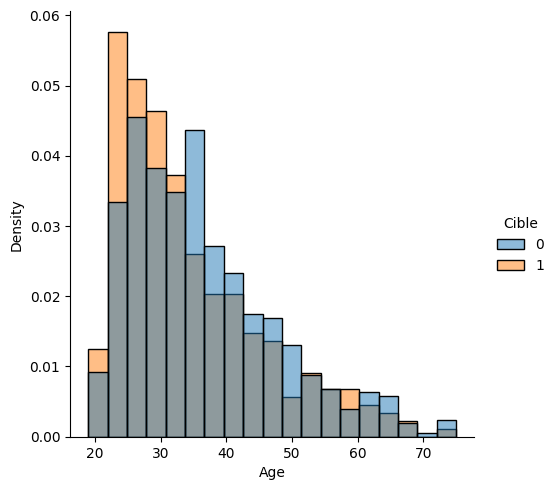

In [44]:
# Analyse pour les variables numériques 
for field in list_var_num:
    sns.displot(df, x=field, hue=target,stat="density",common_norm=False)

ℹ️ En utilisant la fonction <code>distrib_for_num_by_target</code>

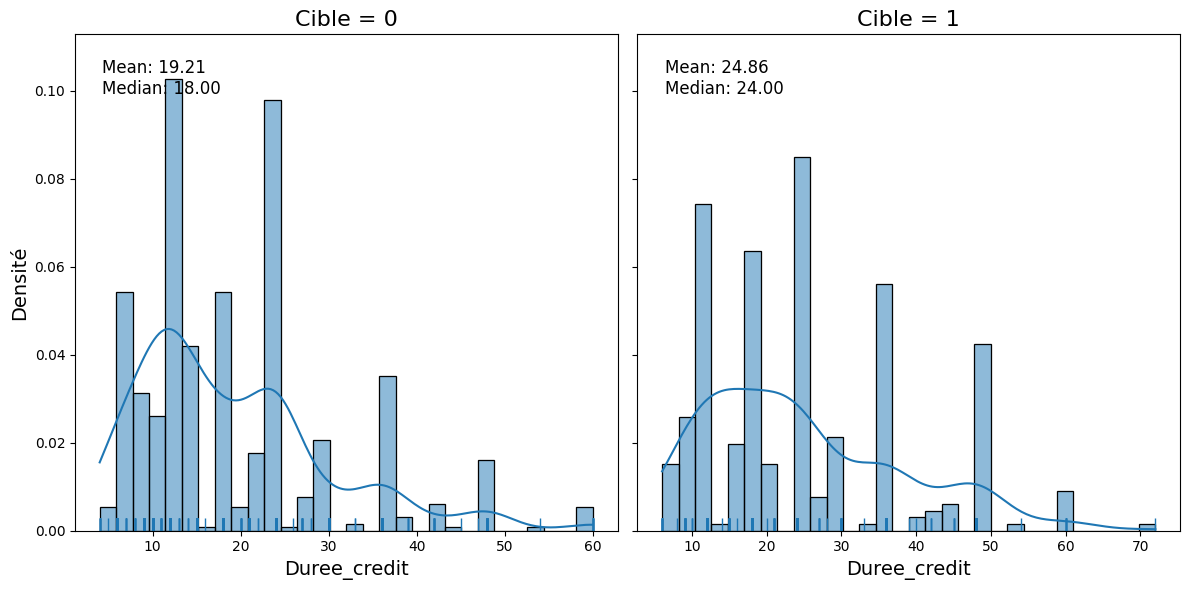

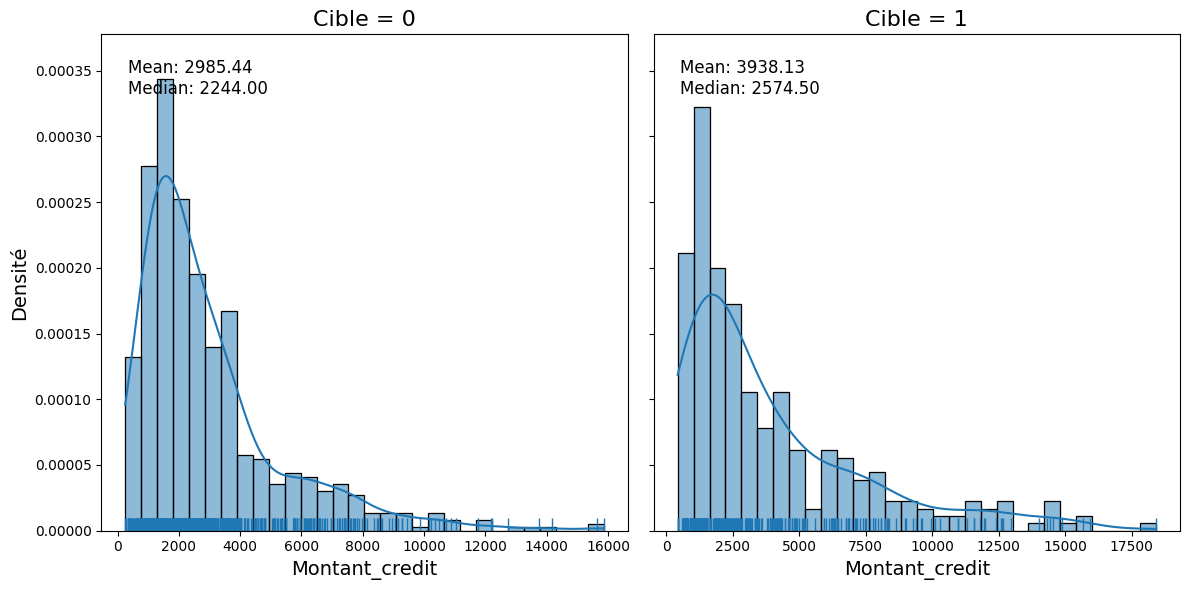

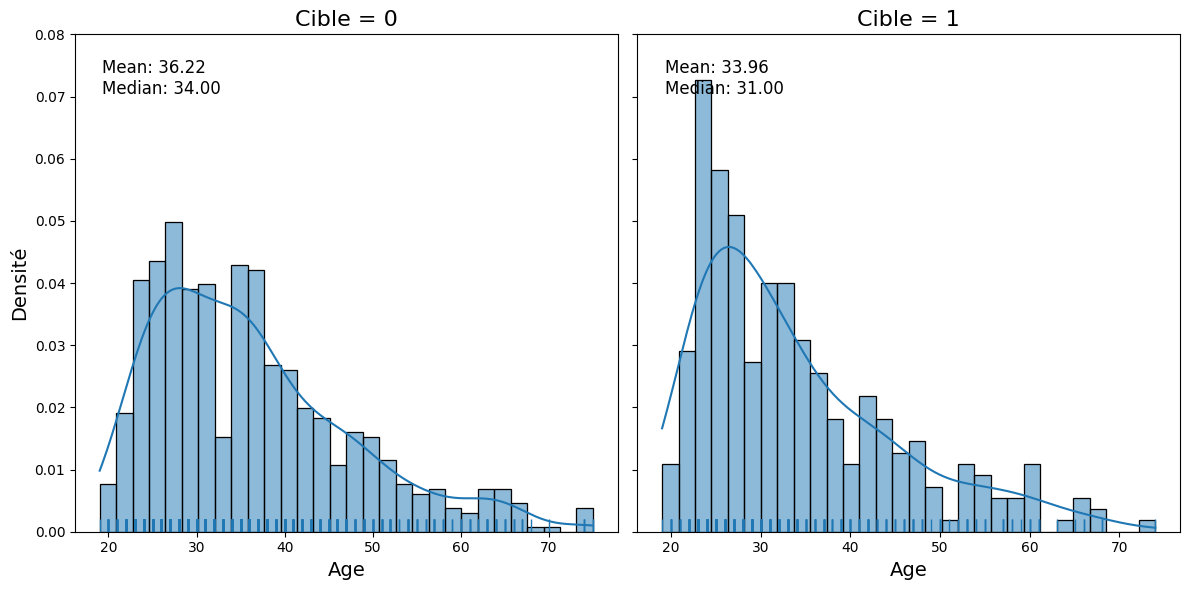

In [45]:
for field in list_var_num:
    distrib_for_cont_by_target(field,df,target)

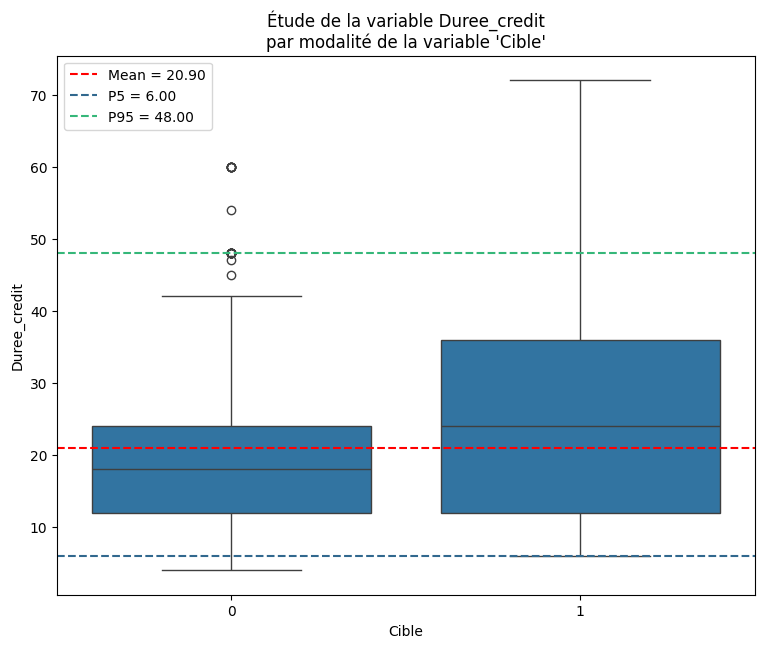

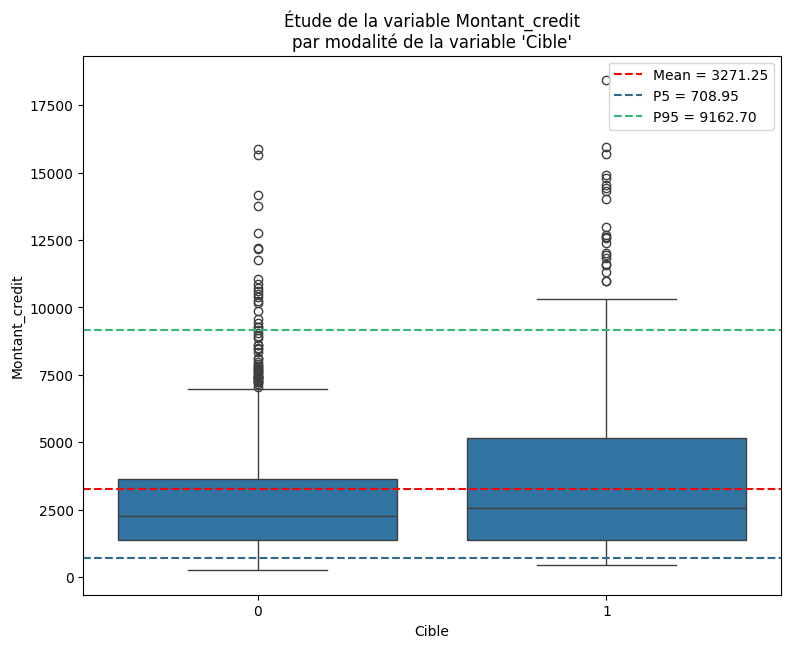

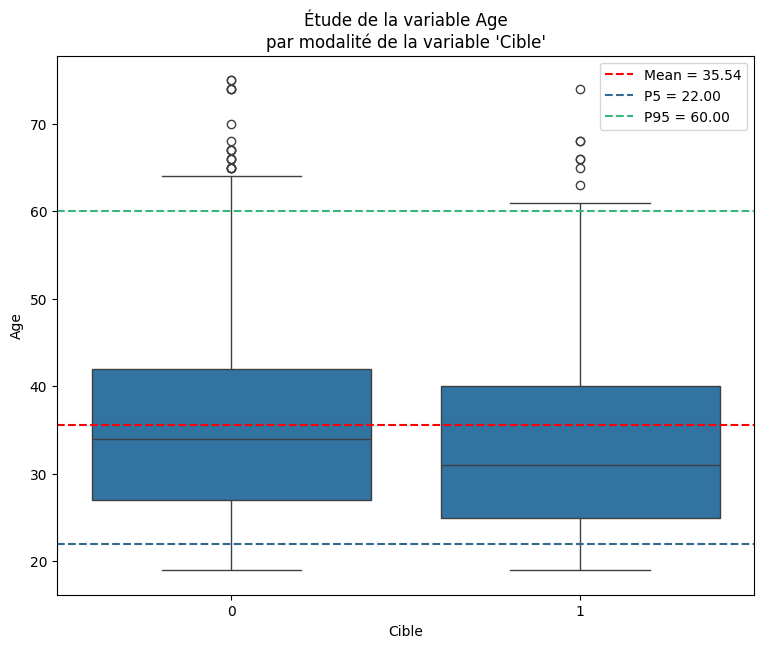

In [46]:
for field in list_var_num:
    boxplot_by_target(field,df,target,quantiles=[5,95])

<div class="alert alert-block alert-warning">
<b> Question 9:</b> Quelle remarque pouvez-vous faire à partir de l'étude des distributions ? 
</div>

<div class="alert alert-block alert-success">
<b> Réponse:</b> A priori, il serait intéressant de discrétiser certaines variables (pour la régression logistique)
</div>

### 2.6 Représentations graphiques avancées 

<b>Utilisez la fonction <code>plot_generic</code></b>

<div class="alert alert-block alert-info">
<b>📝Note :</b> La fonction <code>plot_generic</code> s'adapte selon le type de champ à étudier. Ainsi, vous pouvez utiliser aussi bien des catégorielles que des numériques.
</div>

Analyse des taux de défaut en fonction de la variable Age


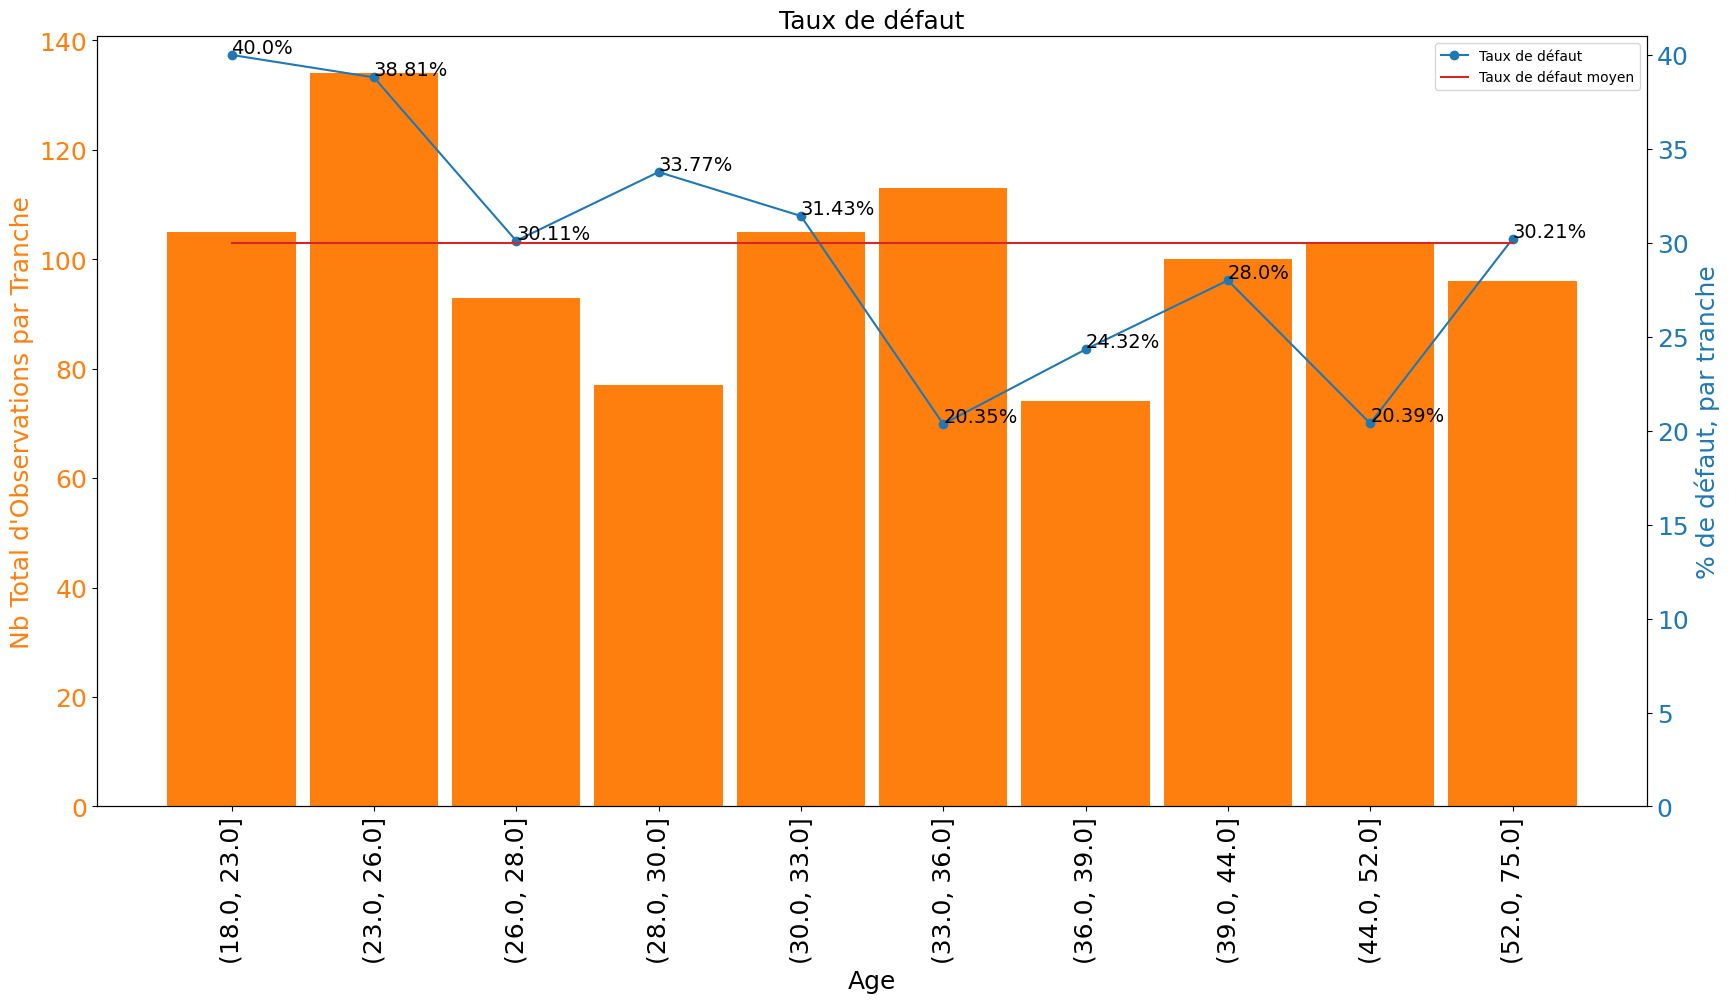

In [47]:
plot_generic(df,'Age',target, bins=10, force_binning=True)

<div class="alert alert-block alert-warning">
<b> Question 10:</b> Construisez le graphique pour d'autres variables
</div>

Analyse des taux de défaut en fonction de la variable Duree_credit


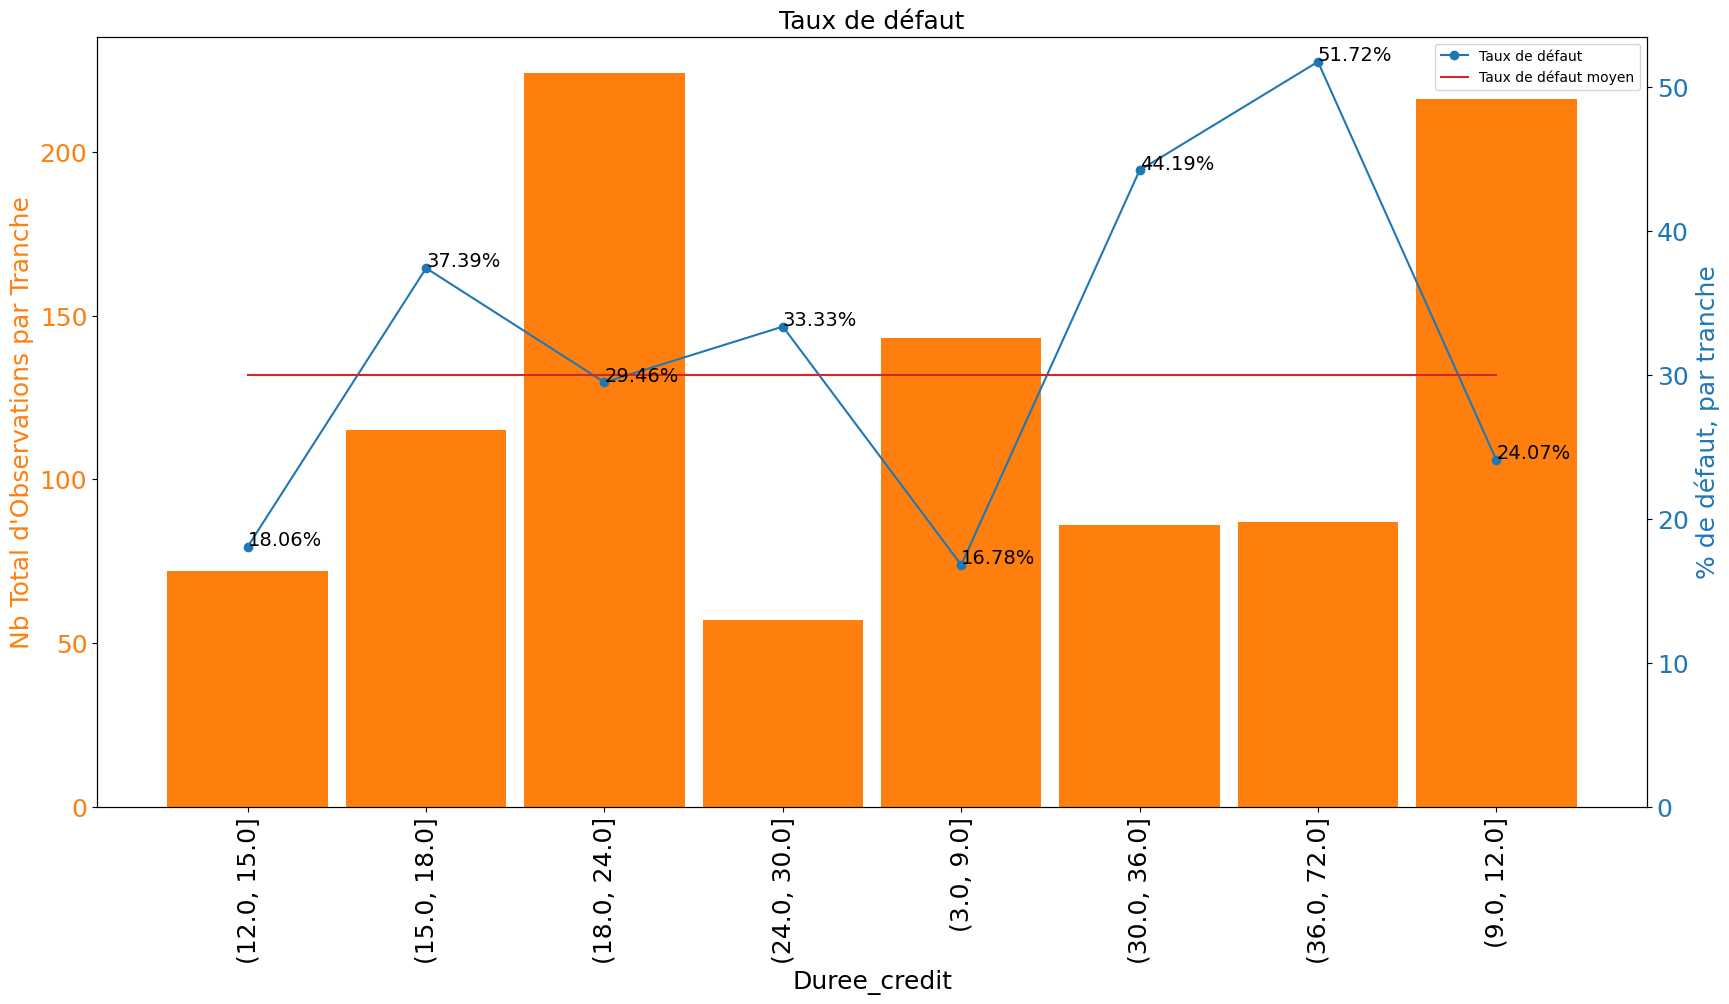

Analyse des taux de défaut en fonction de la variable Montant_credit


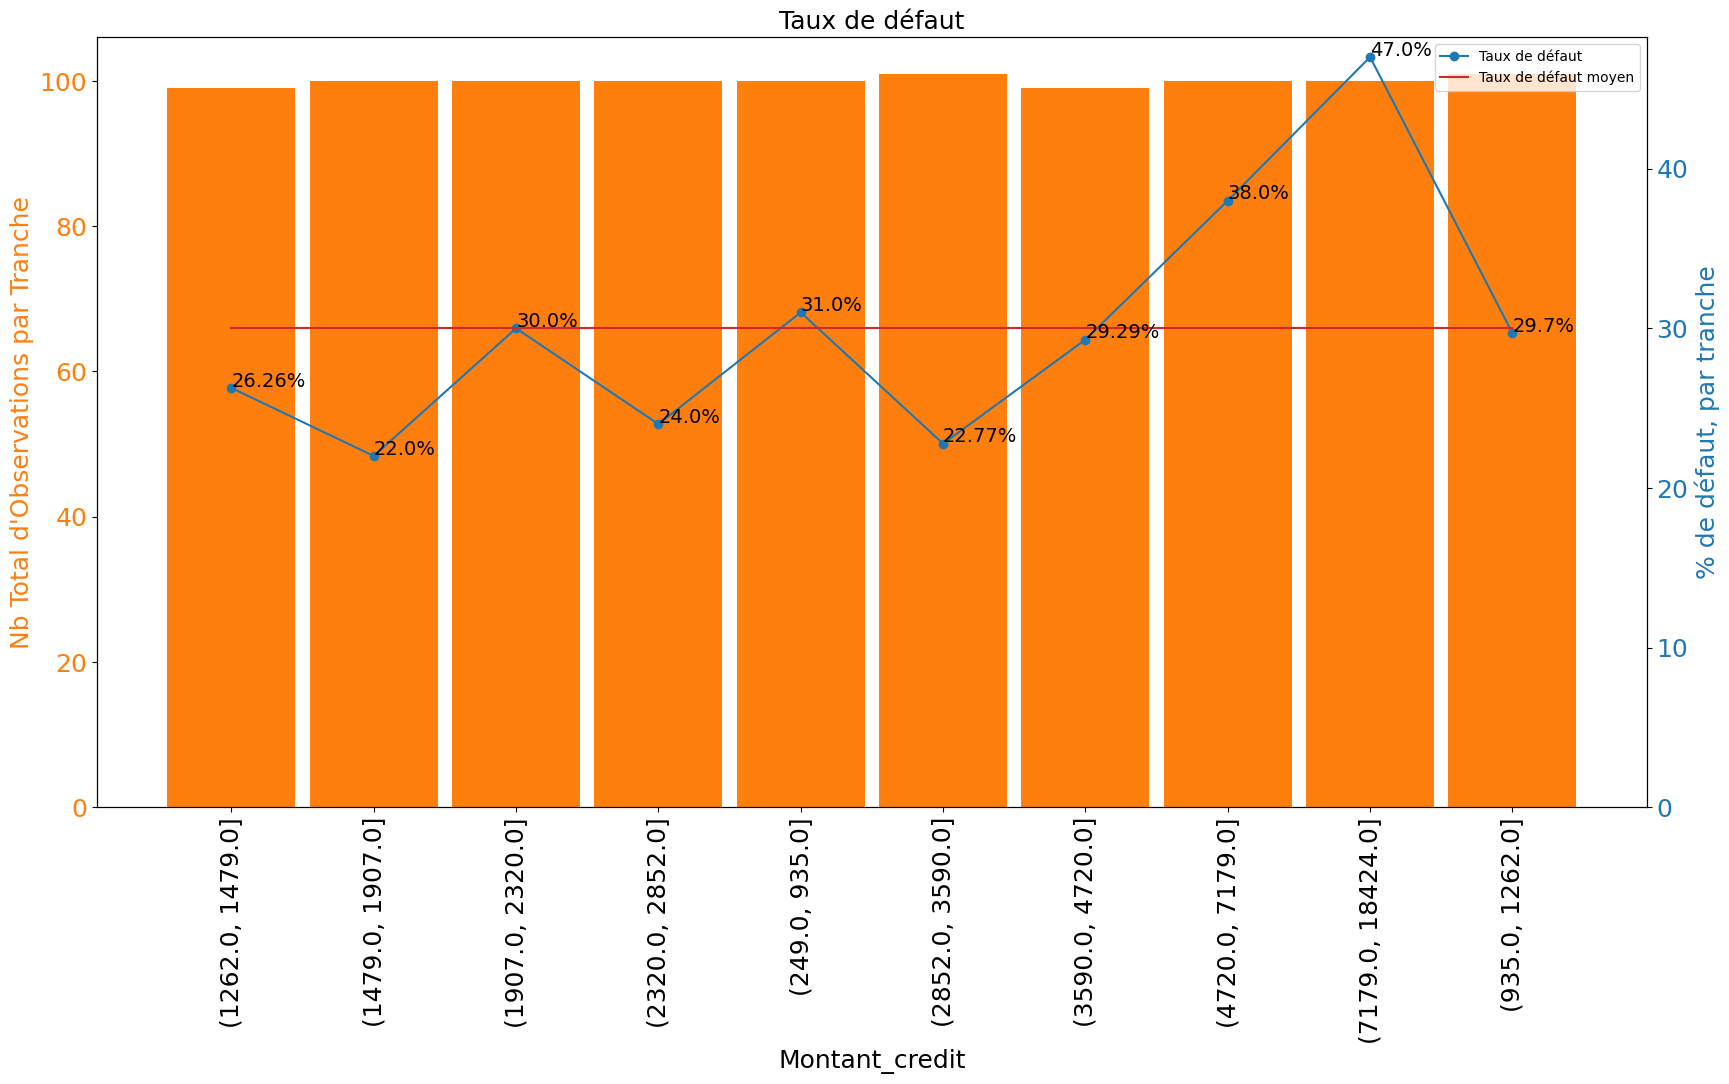

Analyse des taux de défaut en fonction de la variable Age


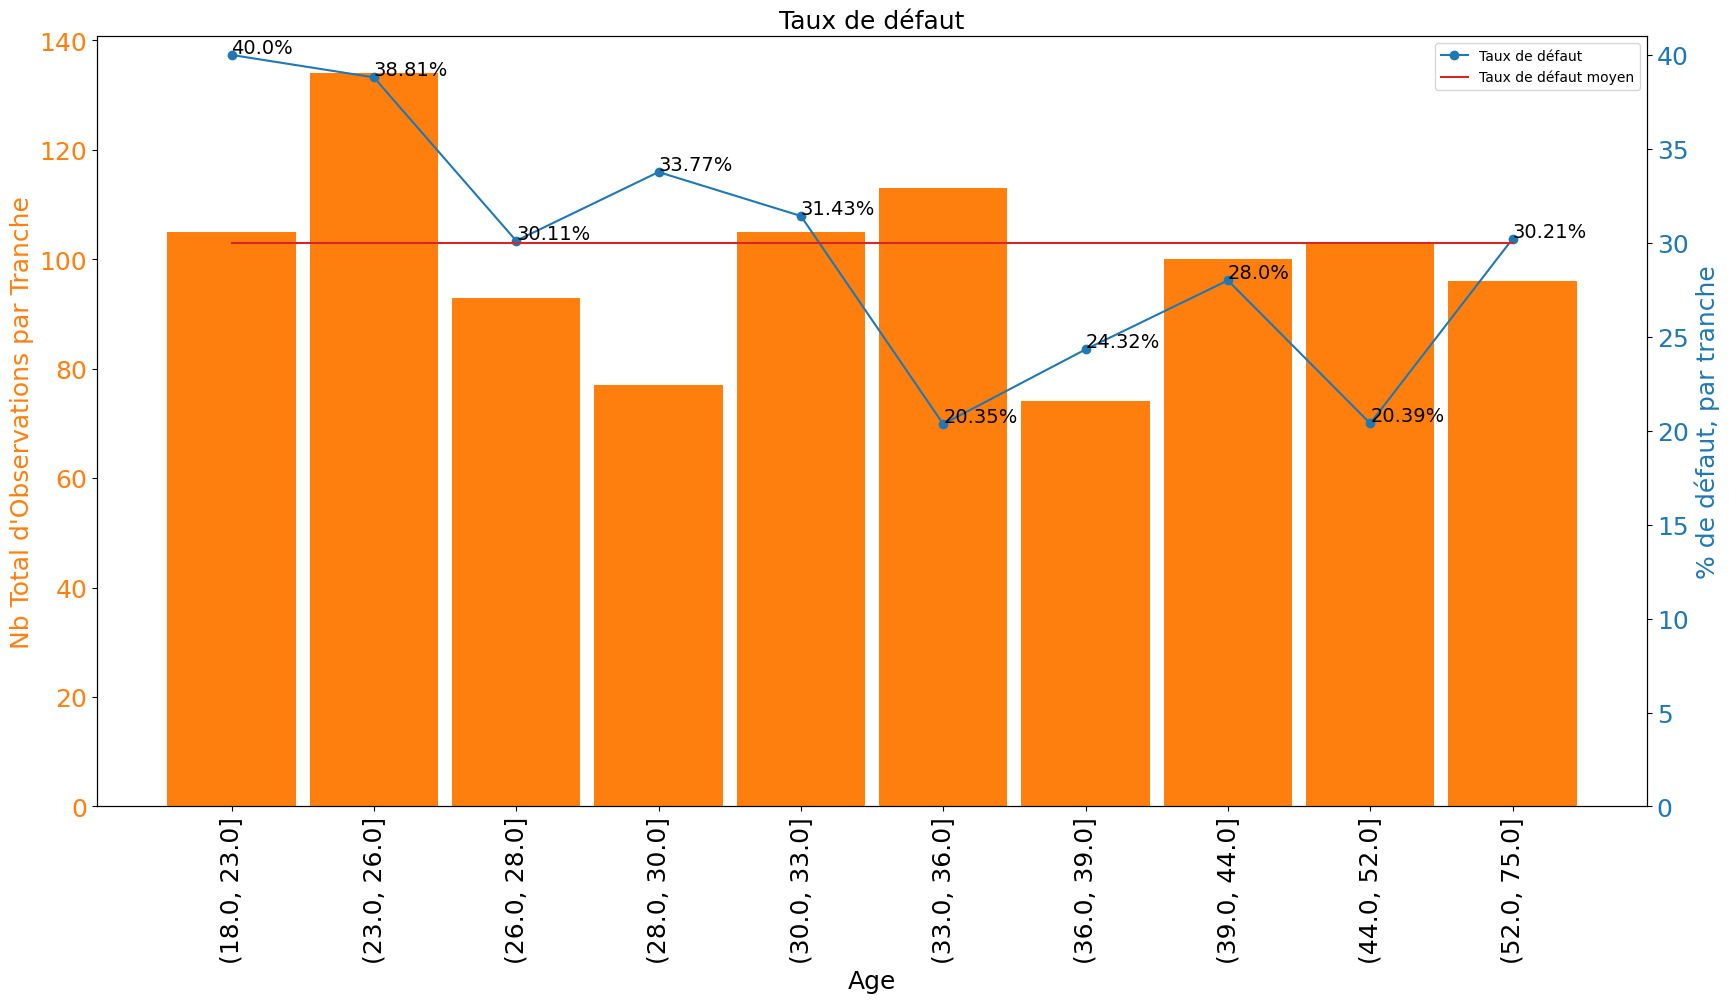

Analyse des taux de défaut en fonction de la variable Objet_credit


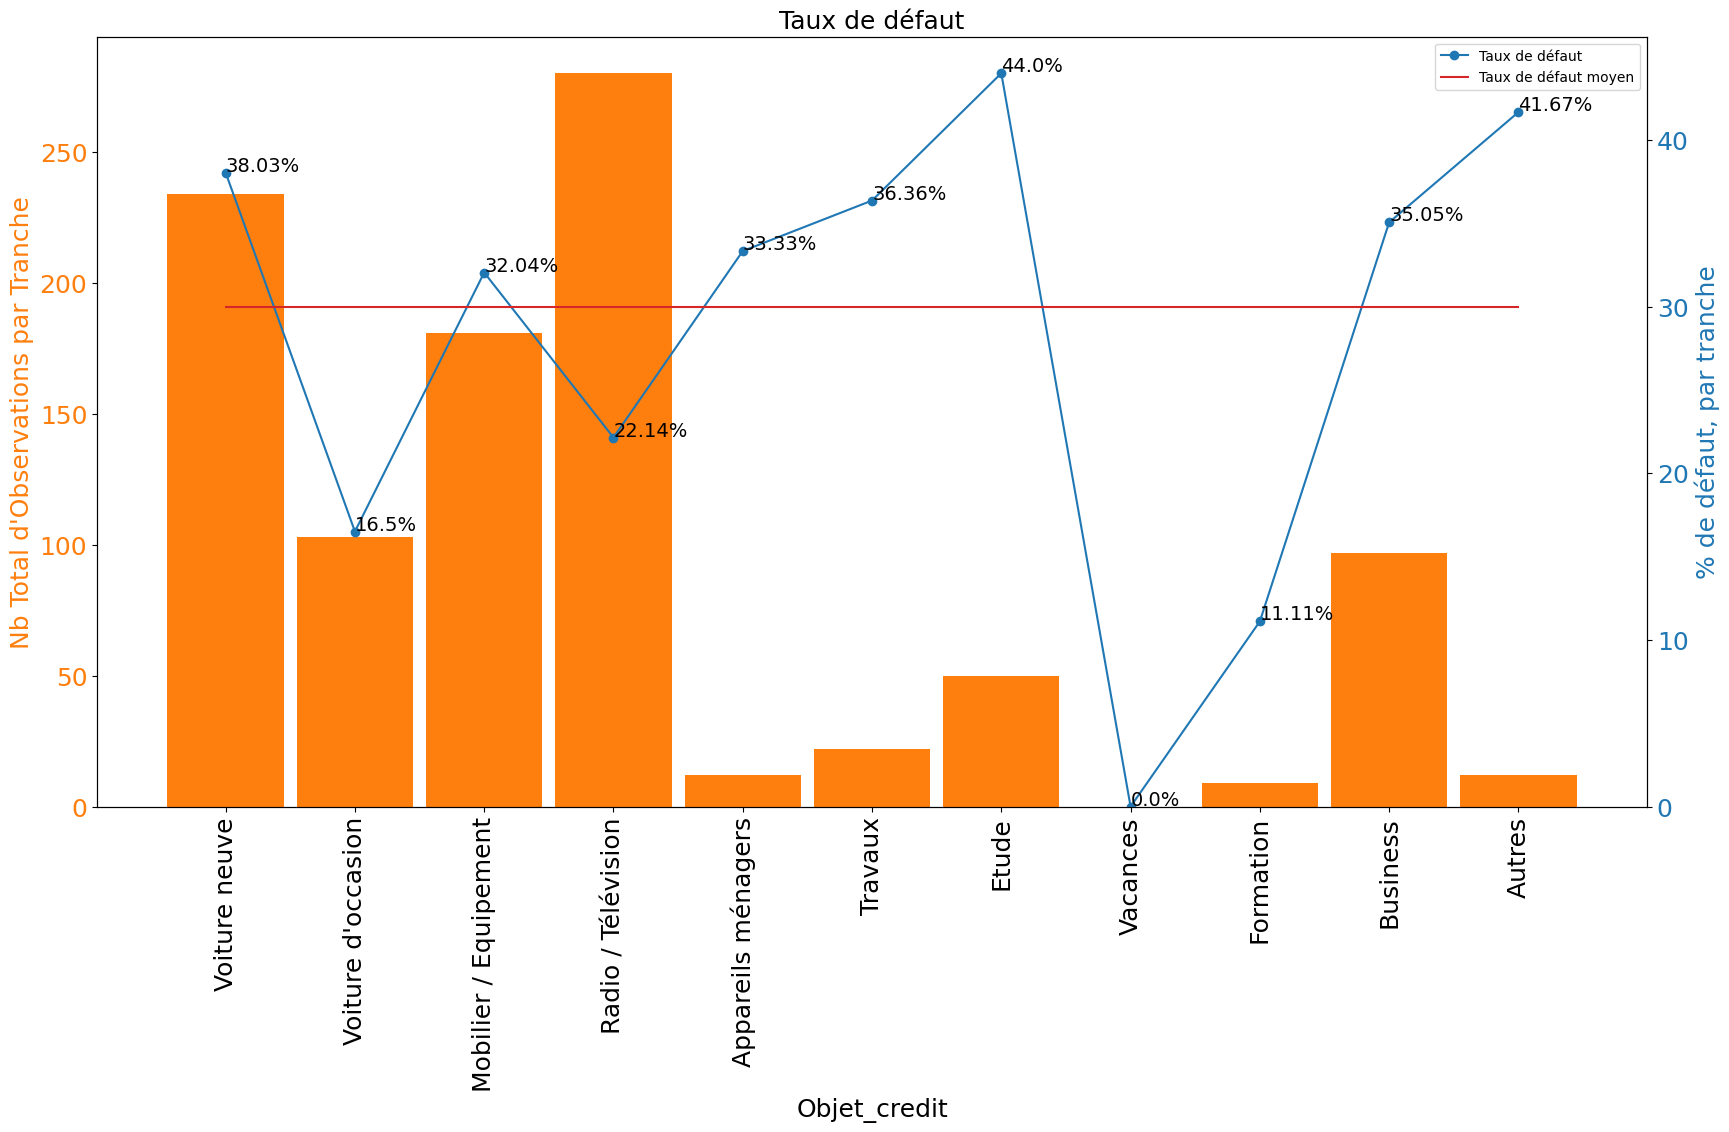

Analyse des taux de défaut en fonction de la variable Historique_credit


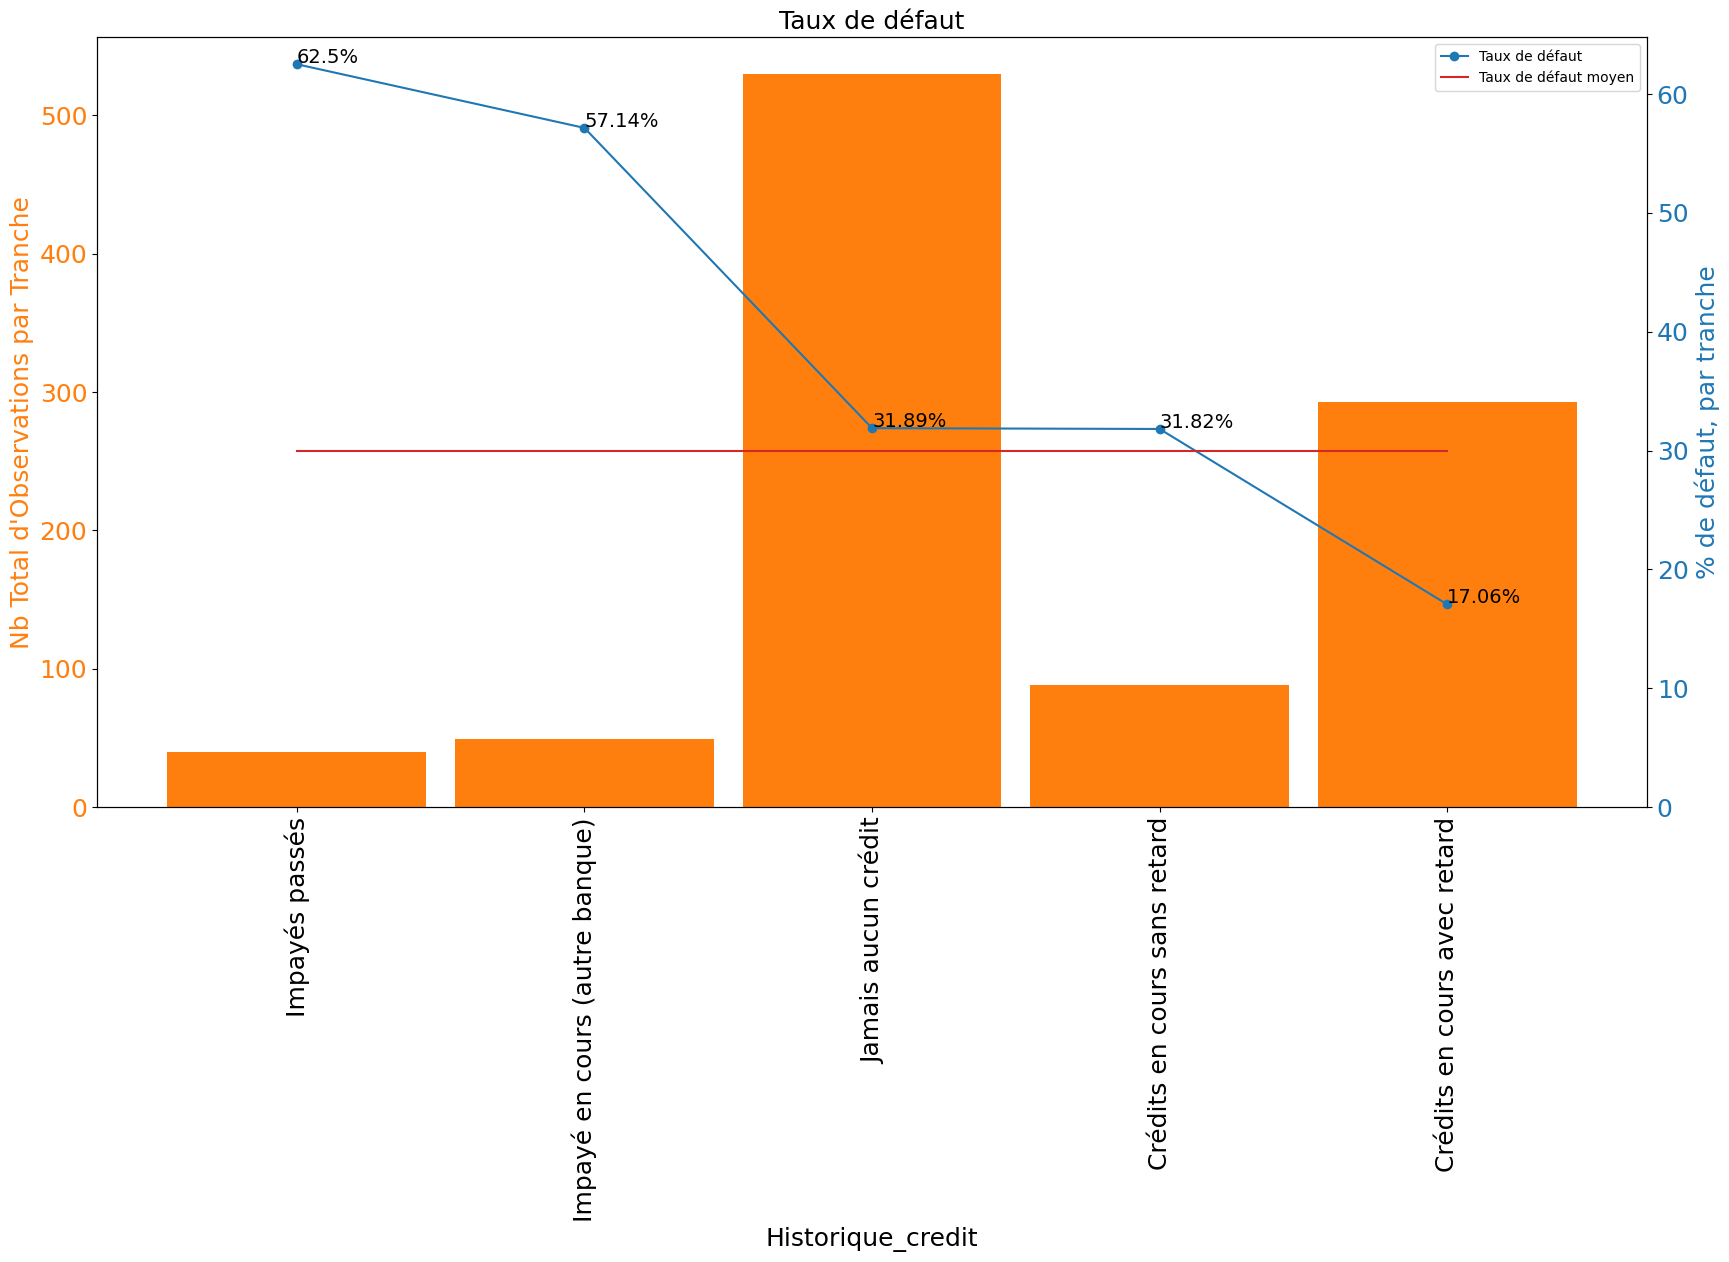

Analyse des taux de défaut en fonction de la variable Epargne


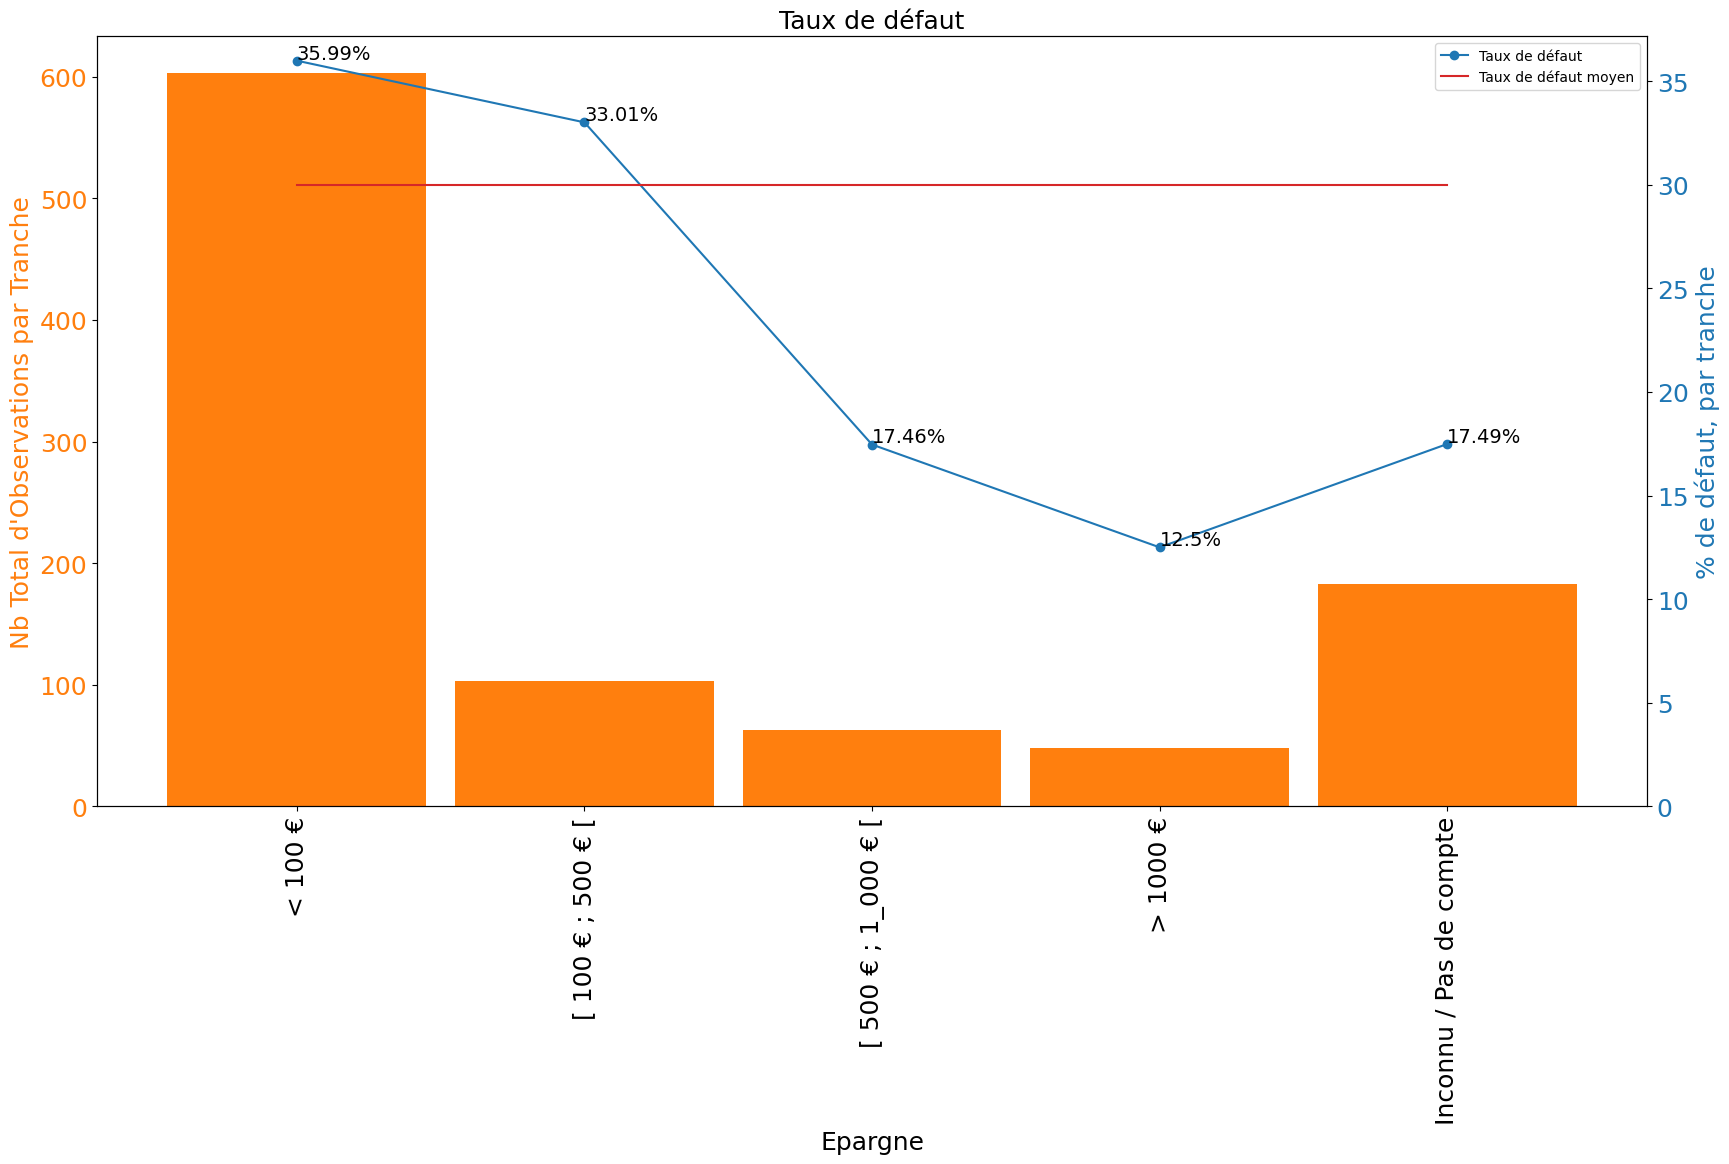

Analyse des taux de défaut en fonction de la variable Anciennete_emploi


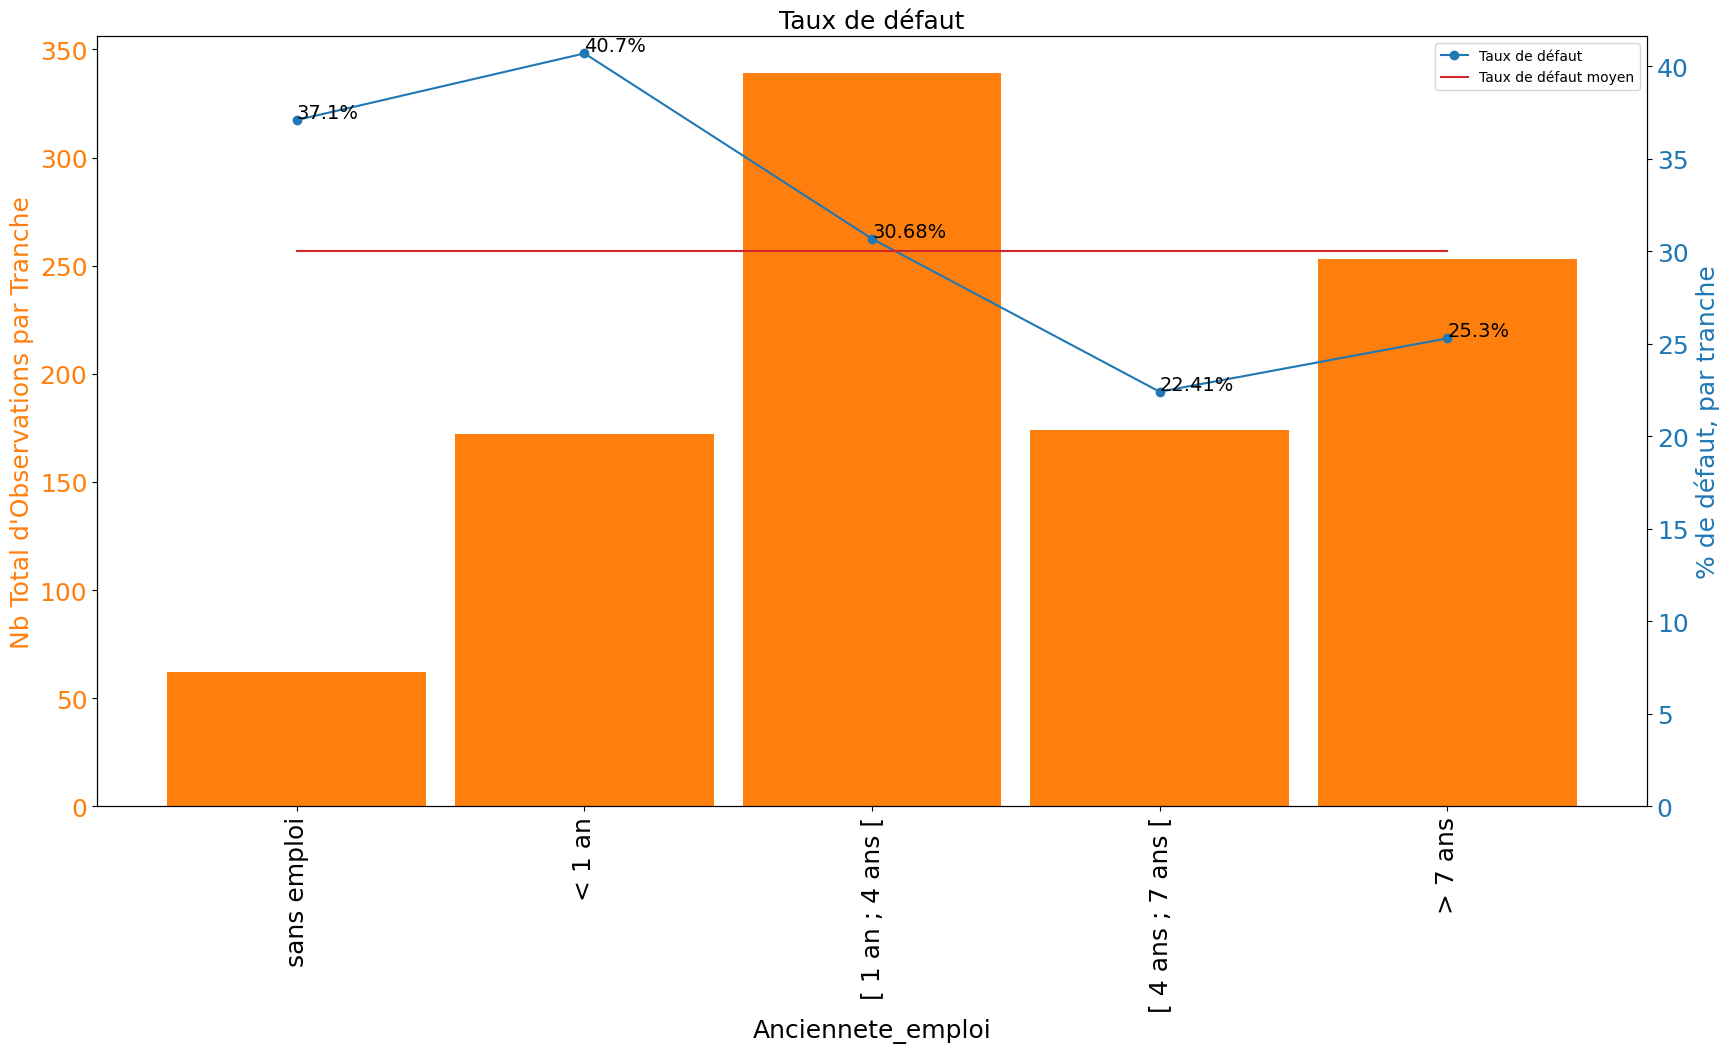

Analyse des taux de défaut en fonction de la variable Situation_familiale


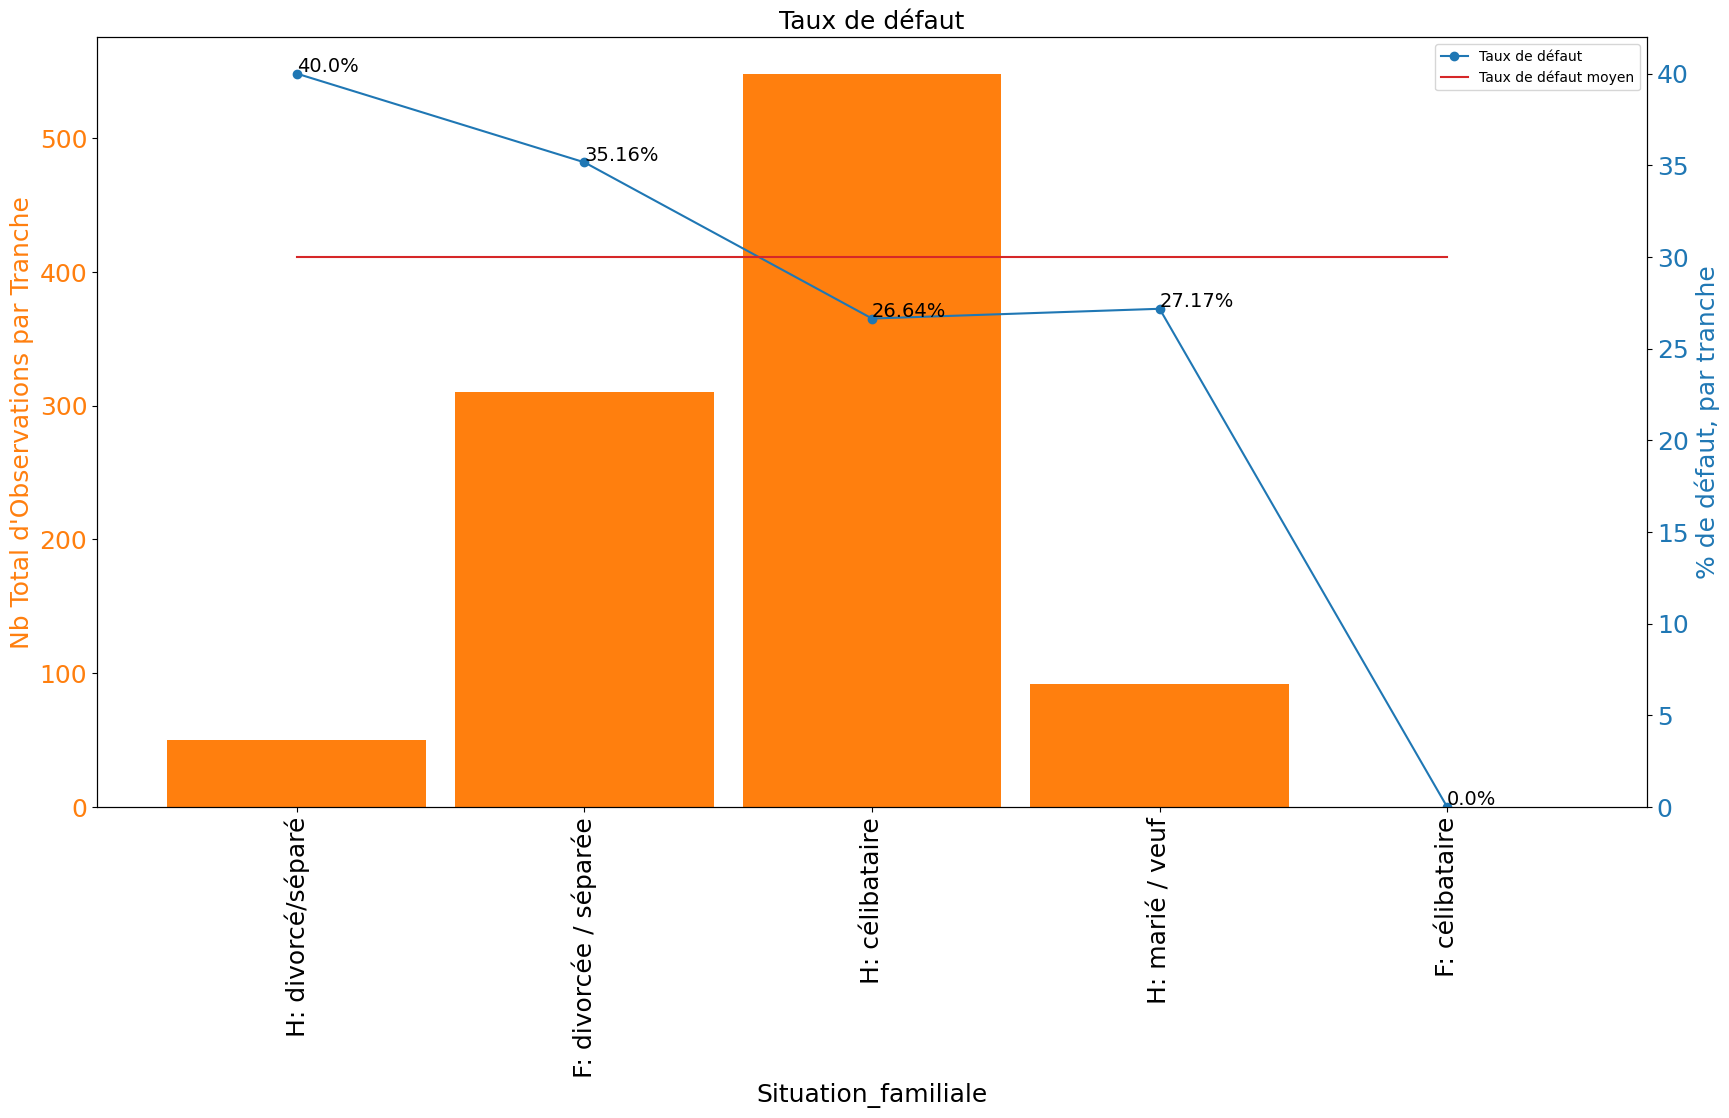

Analyse des taux de défaut en fonction de la variable Anciennete_domicile


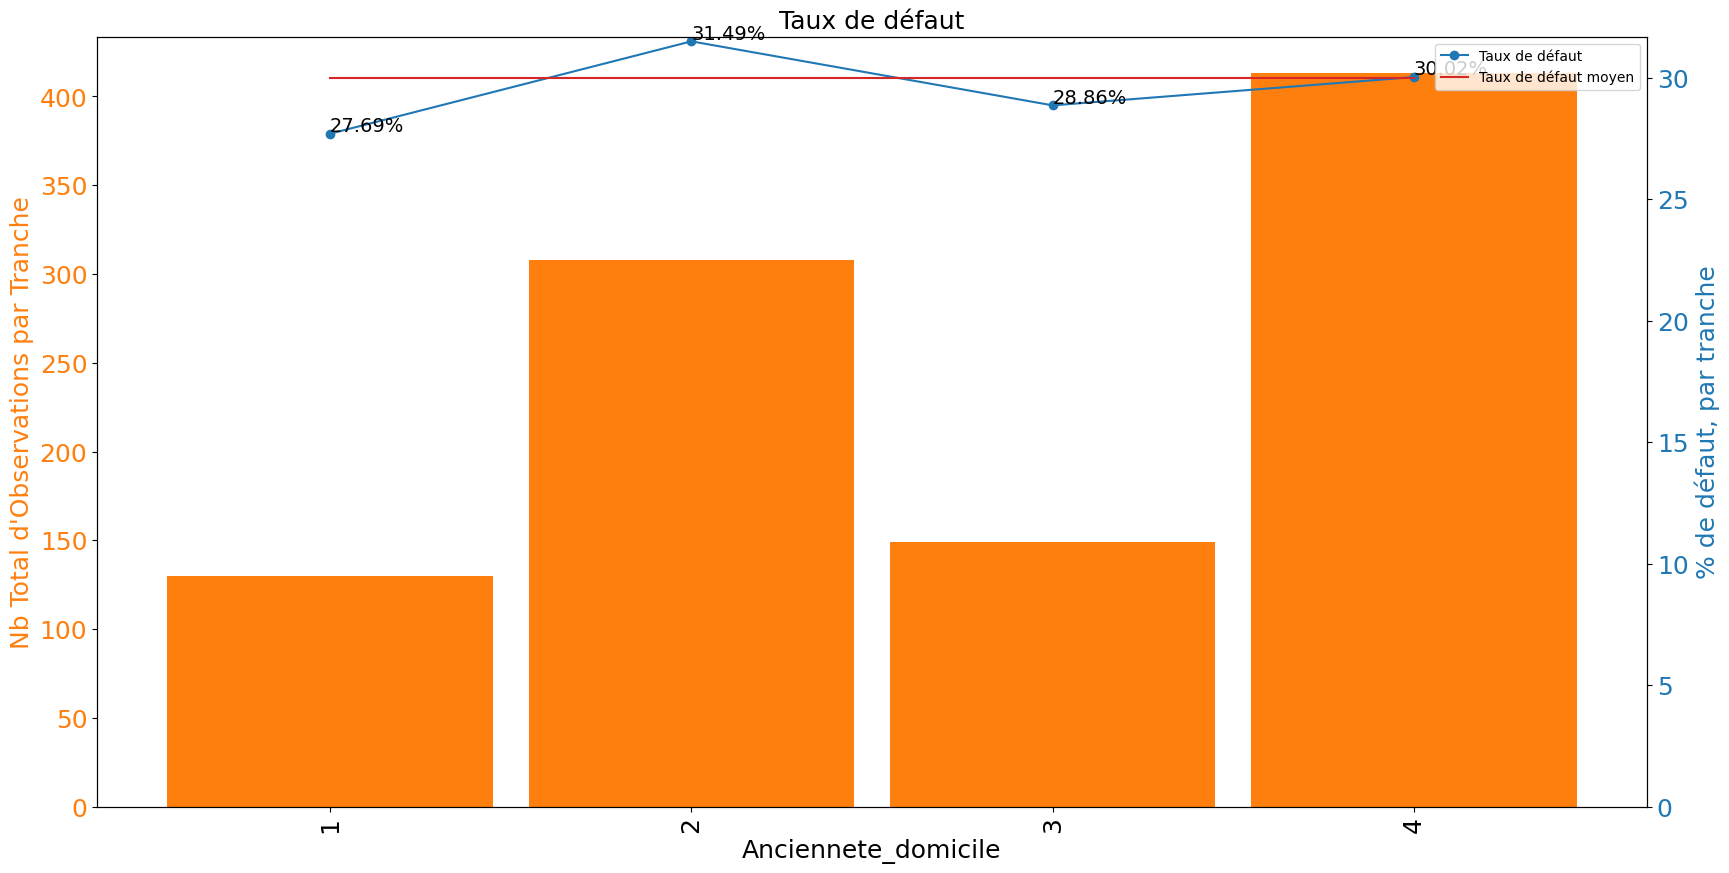

Analyse des taux de défaut en fonction de la variable Nb_credits


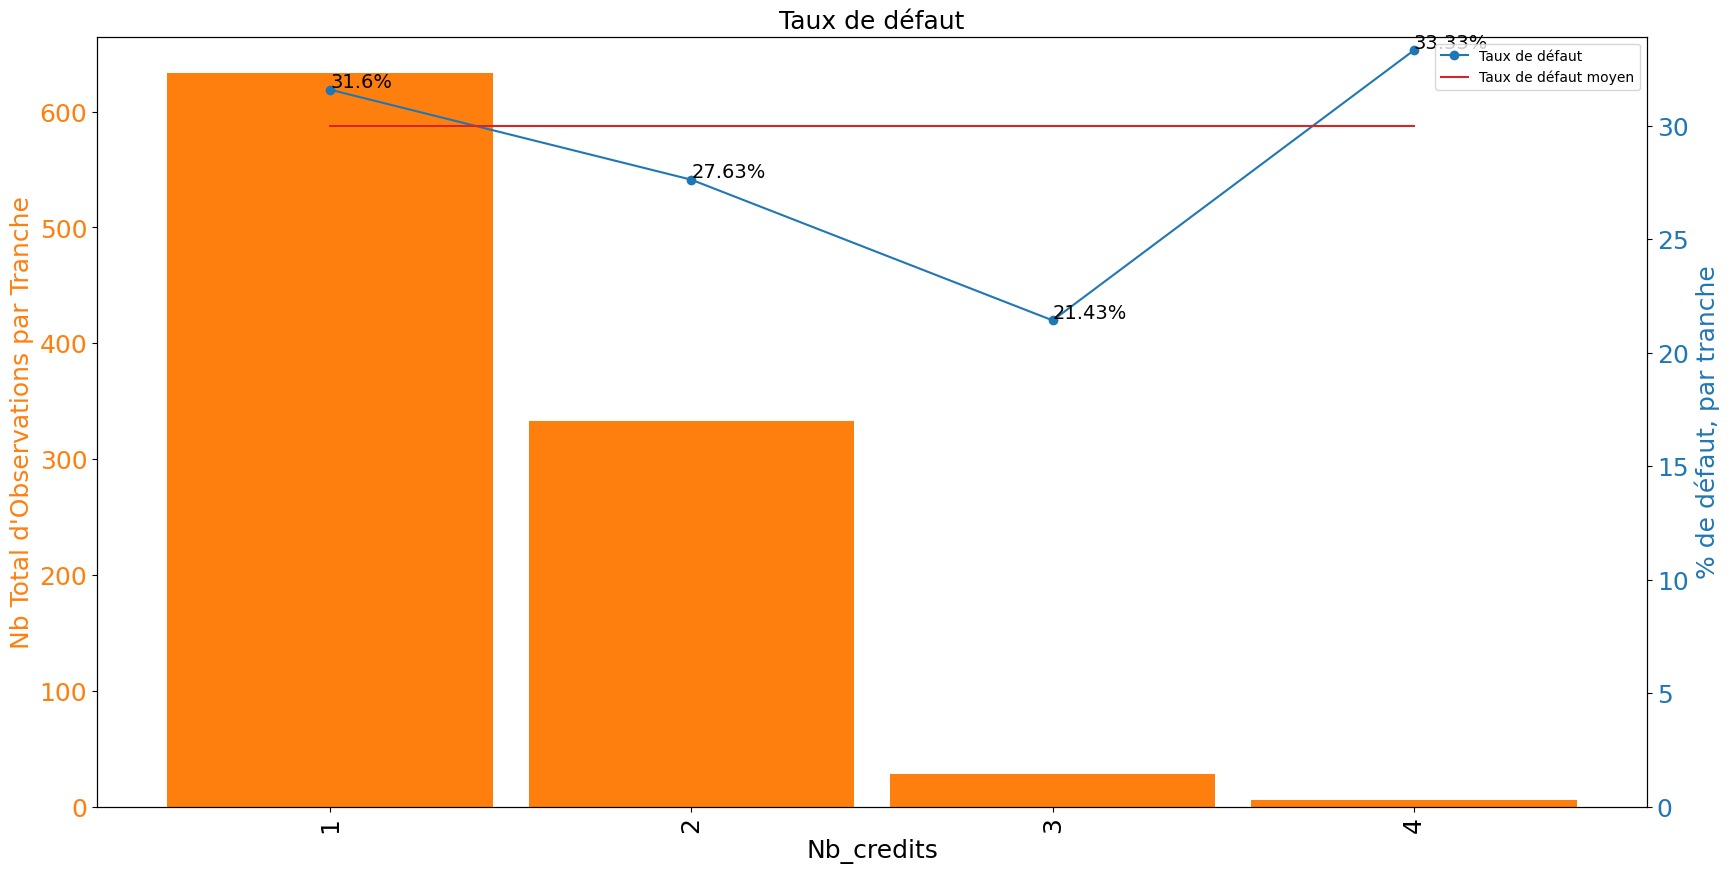

Analyse des taux de défaut en fonction de la variable Biens


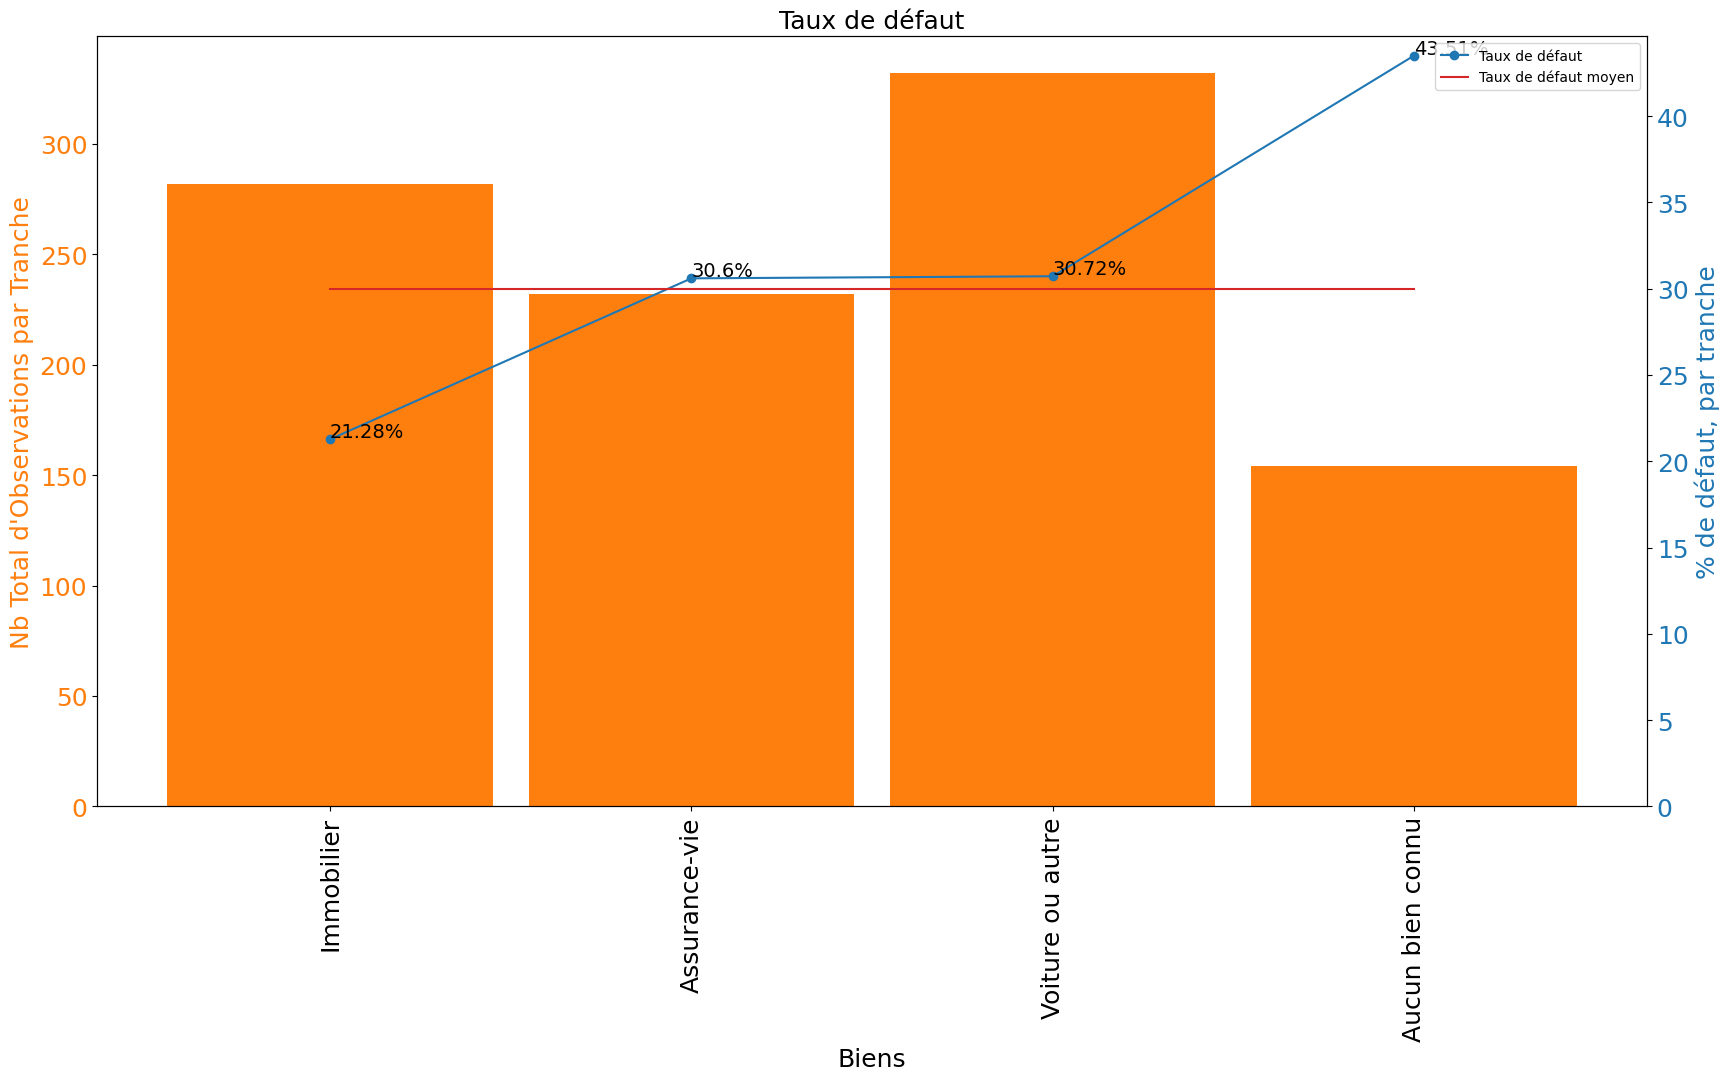

Analyse des taux de défaut en fonction de la variable Type_emploi


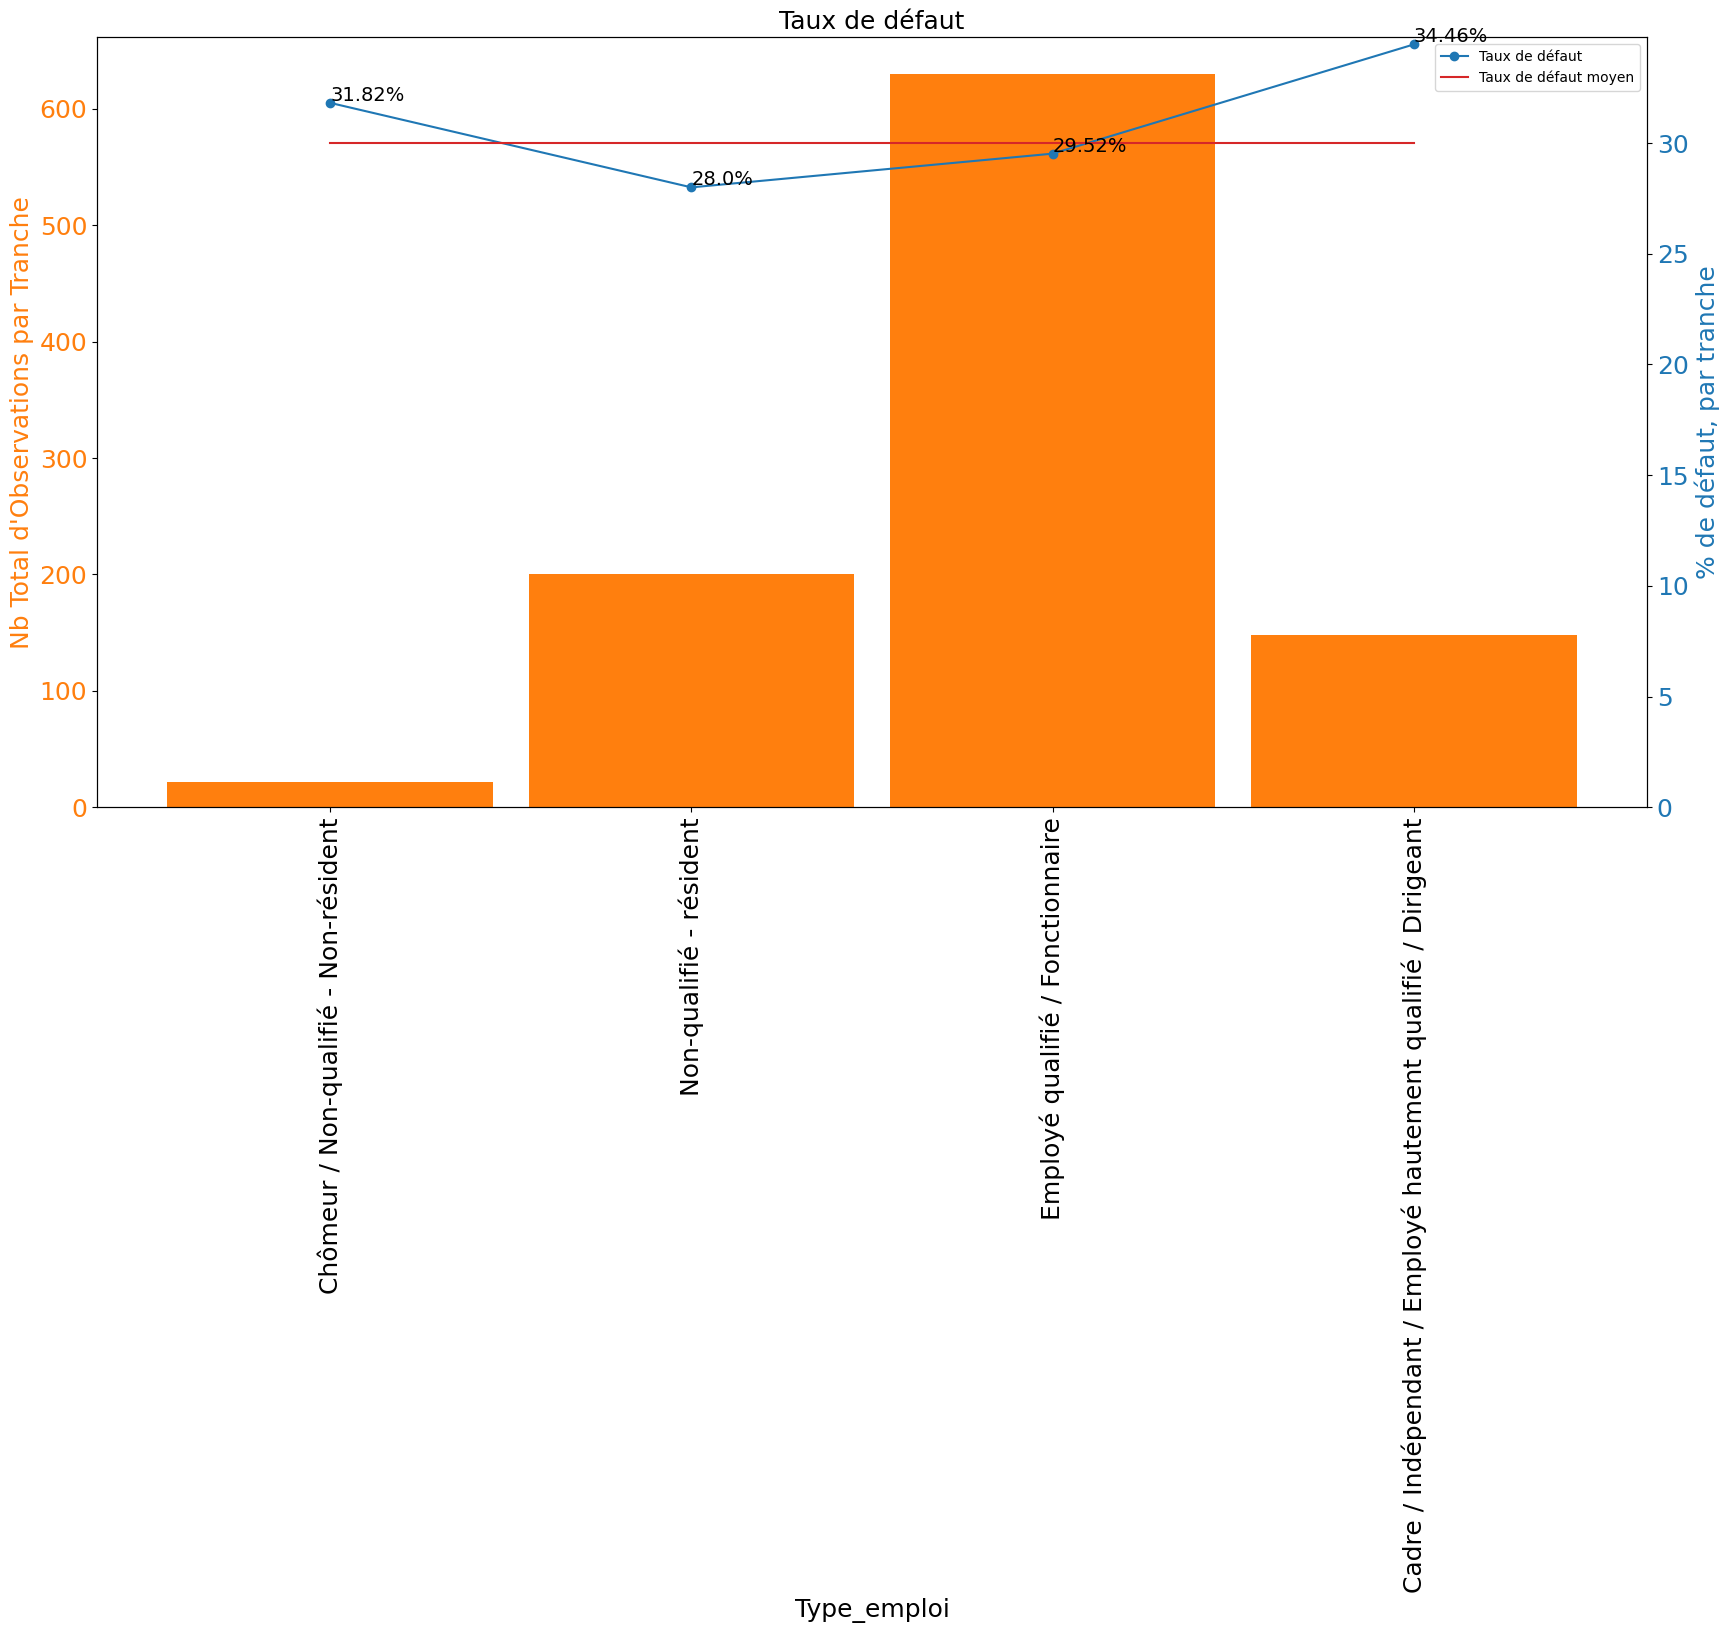

Analyse des taux de défaut en fonction de la variable Comptes


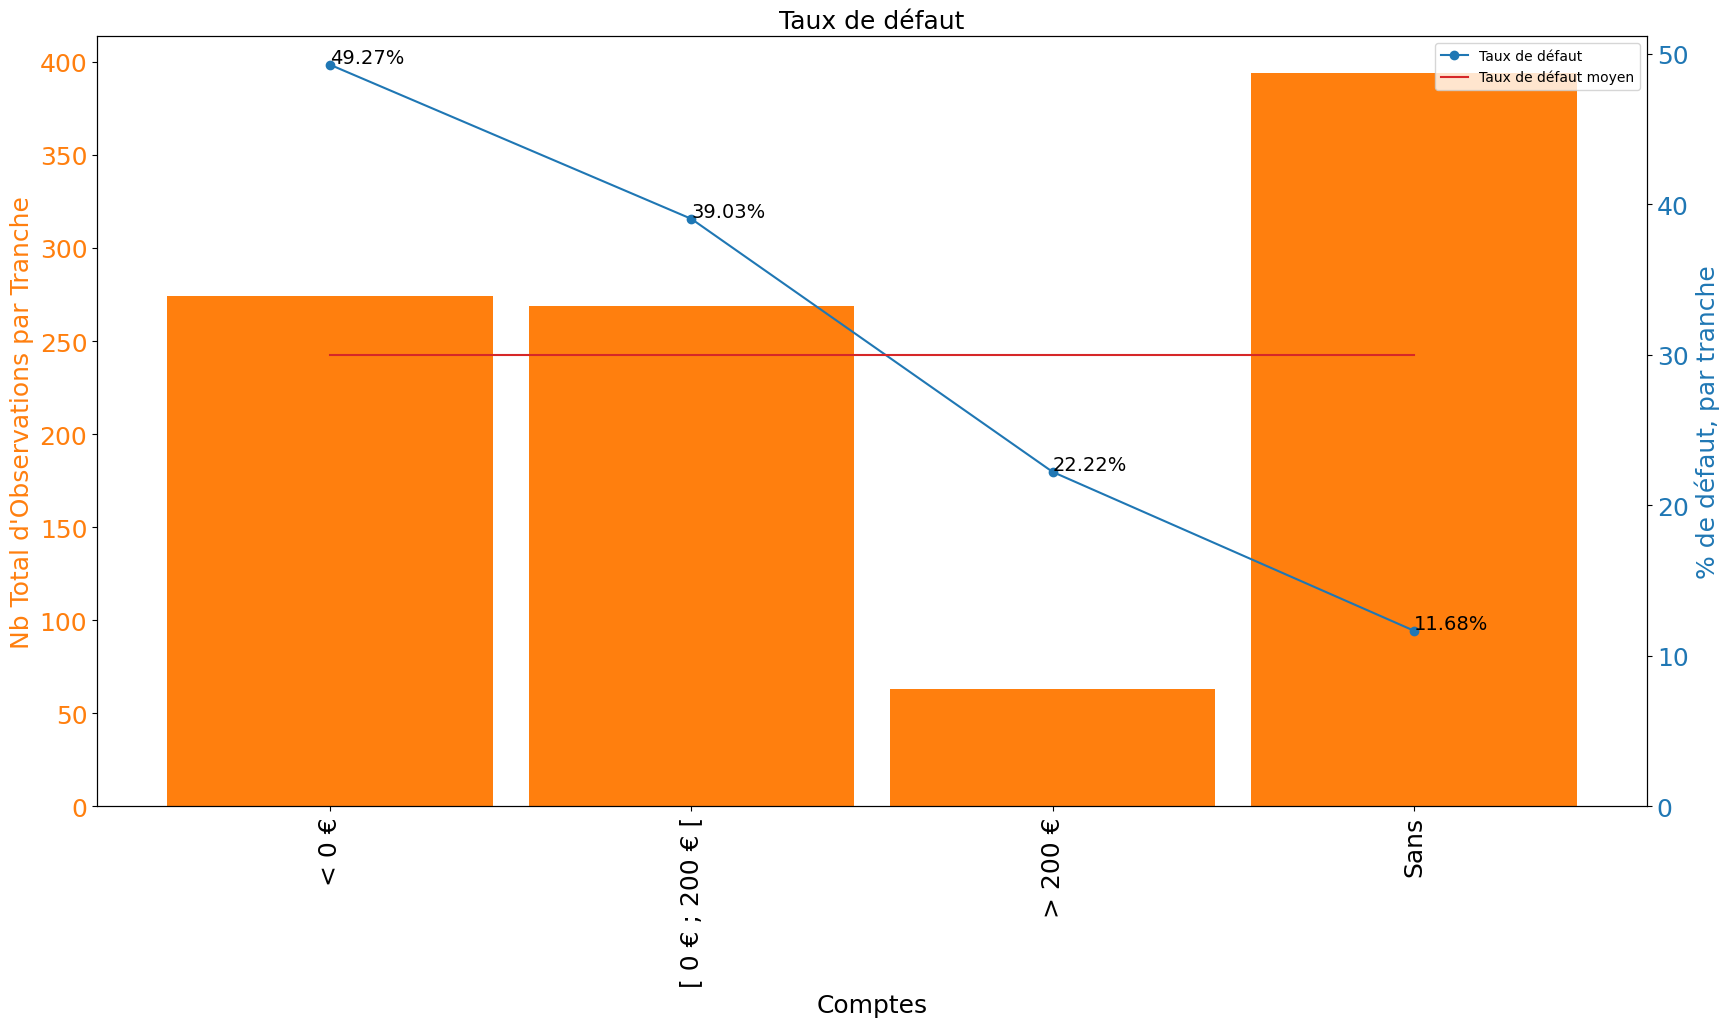

Analyse des taux de défaut en fonction de la variable Taux_effort


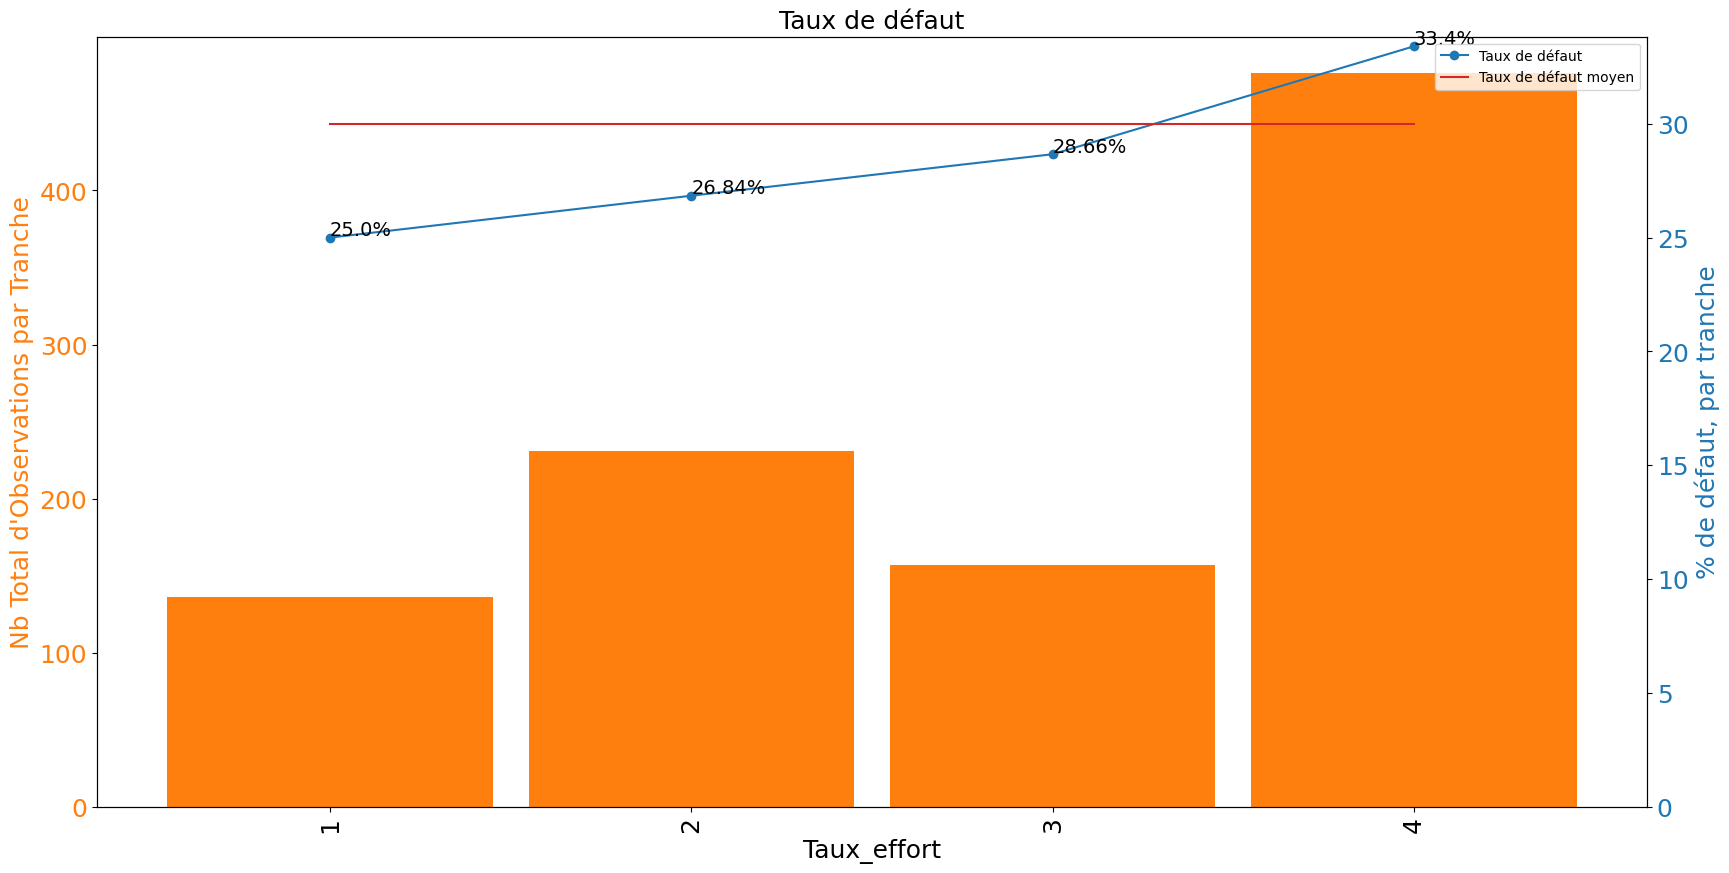

Analyse des taux de défaut en fonction de la variable Autres_credits


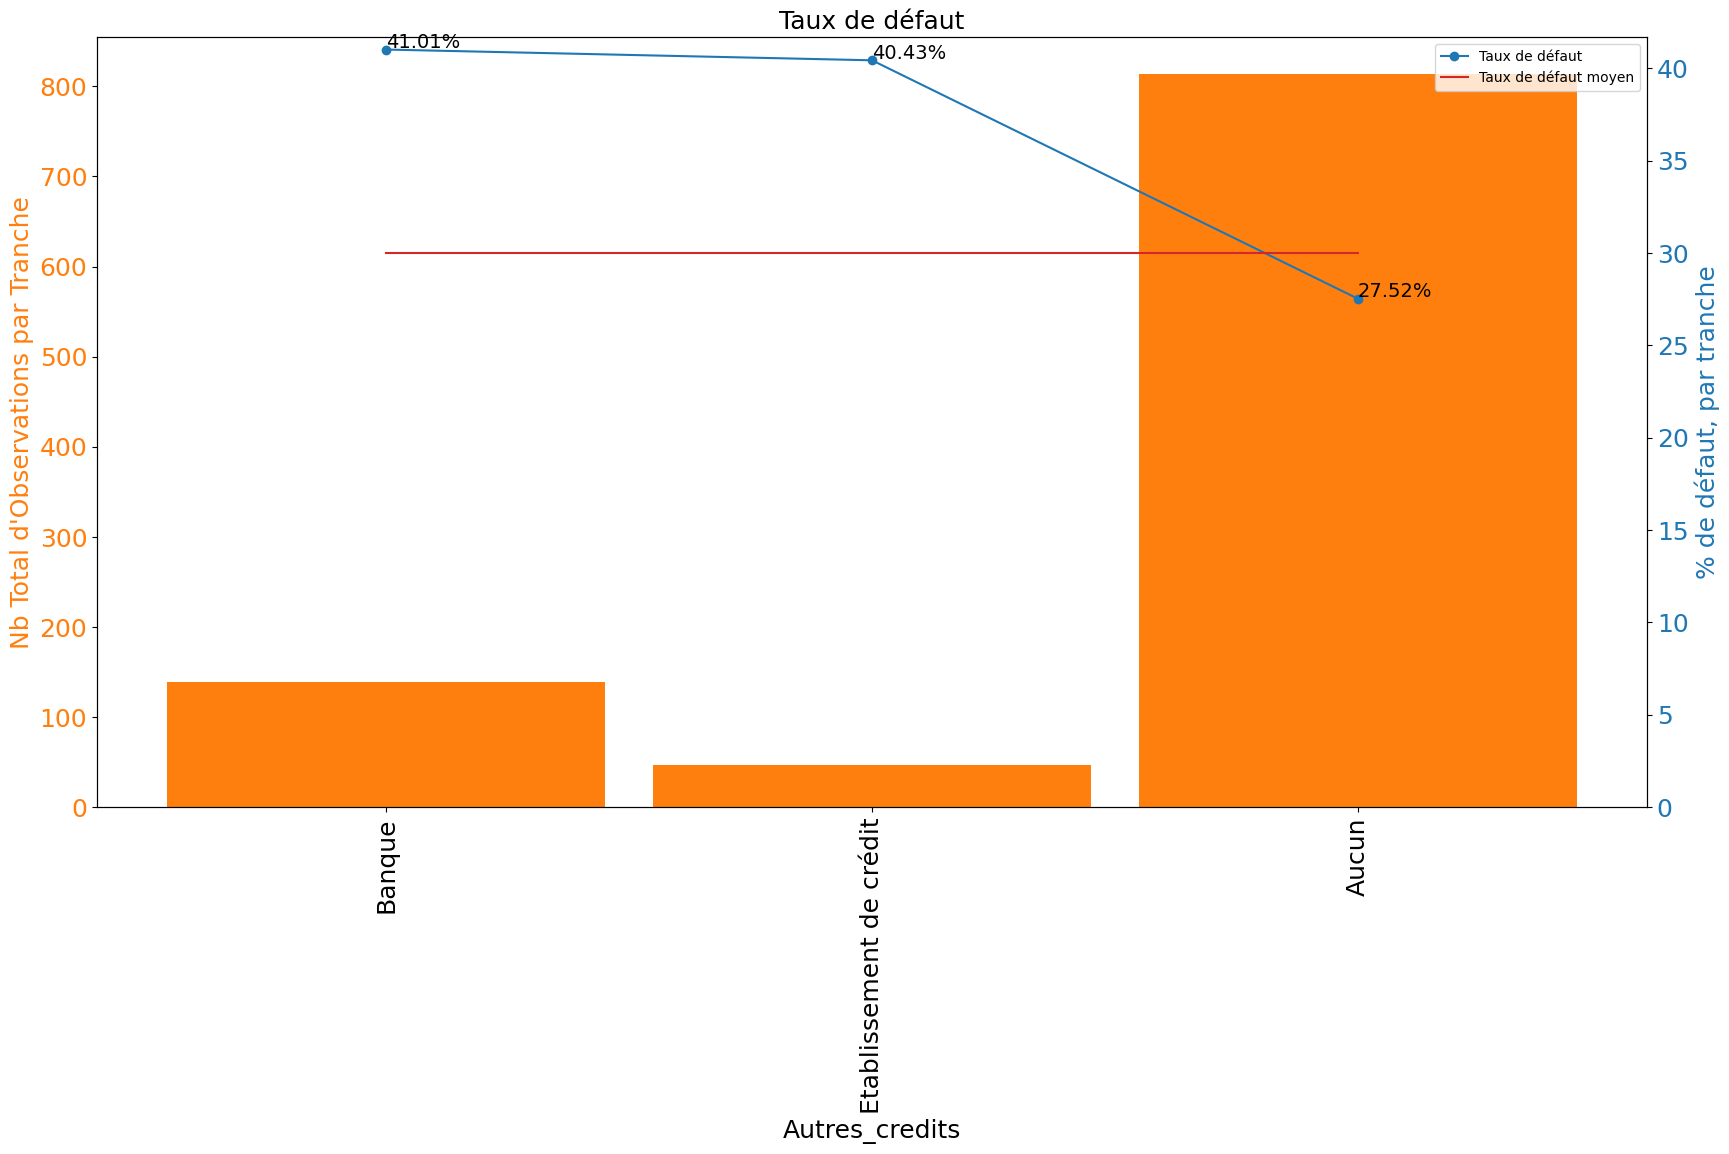

Analyse des taux de défaut en fonction de la variable Statut_domicile


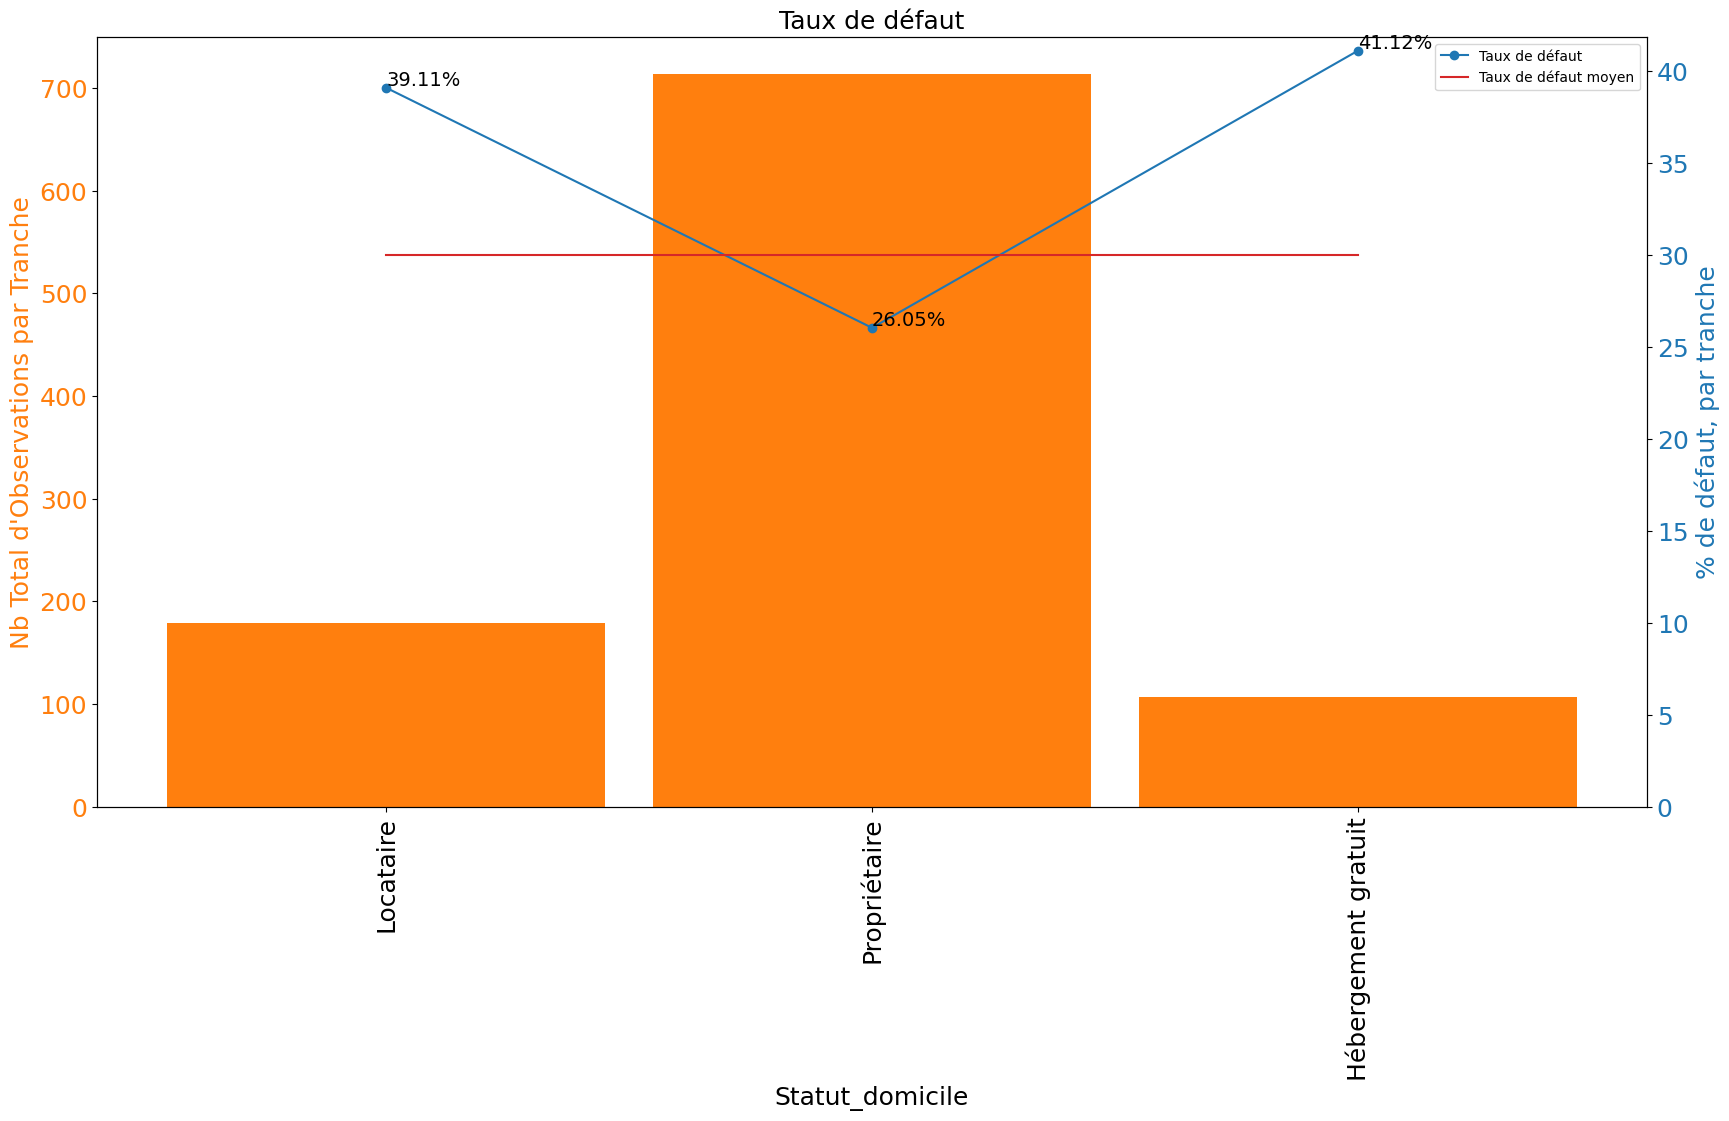

Analyse des taux de défaut en fonction de la variable Garanties


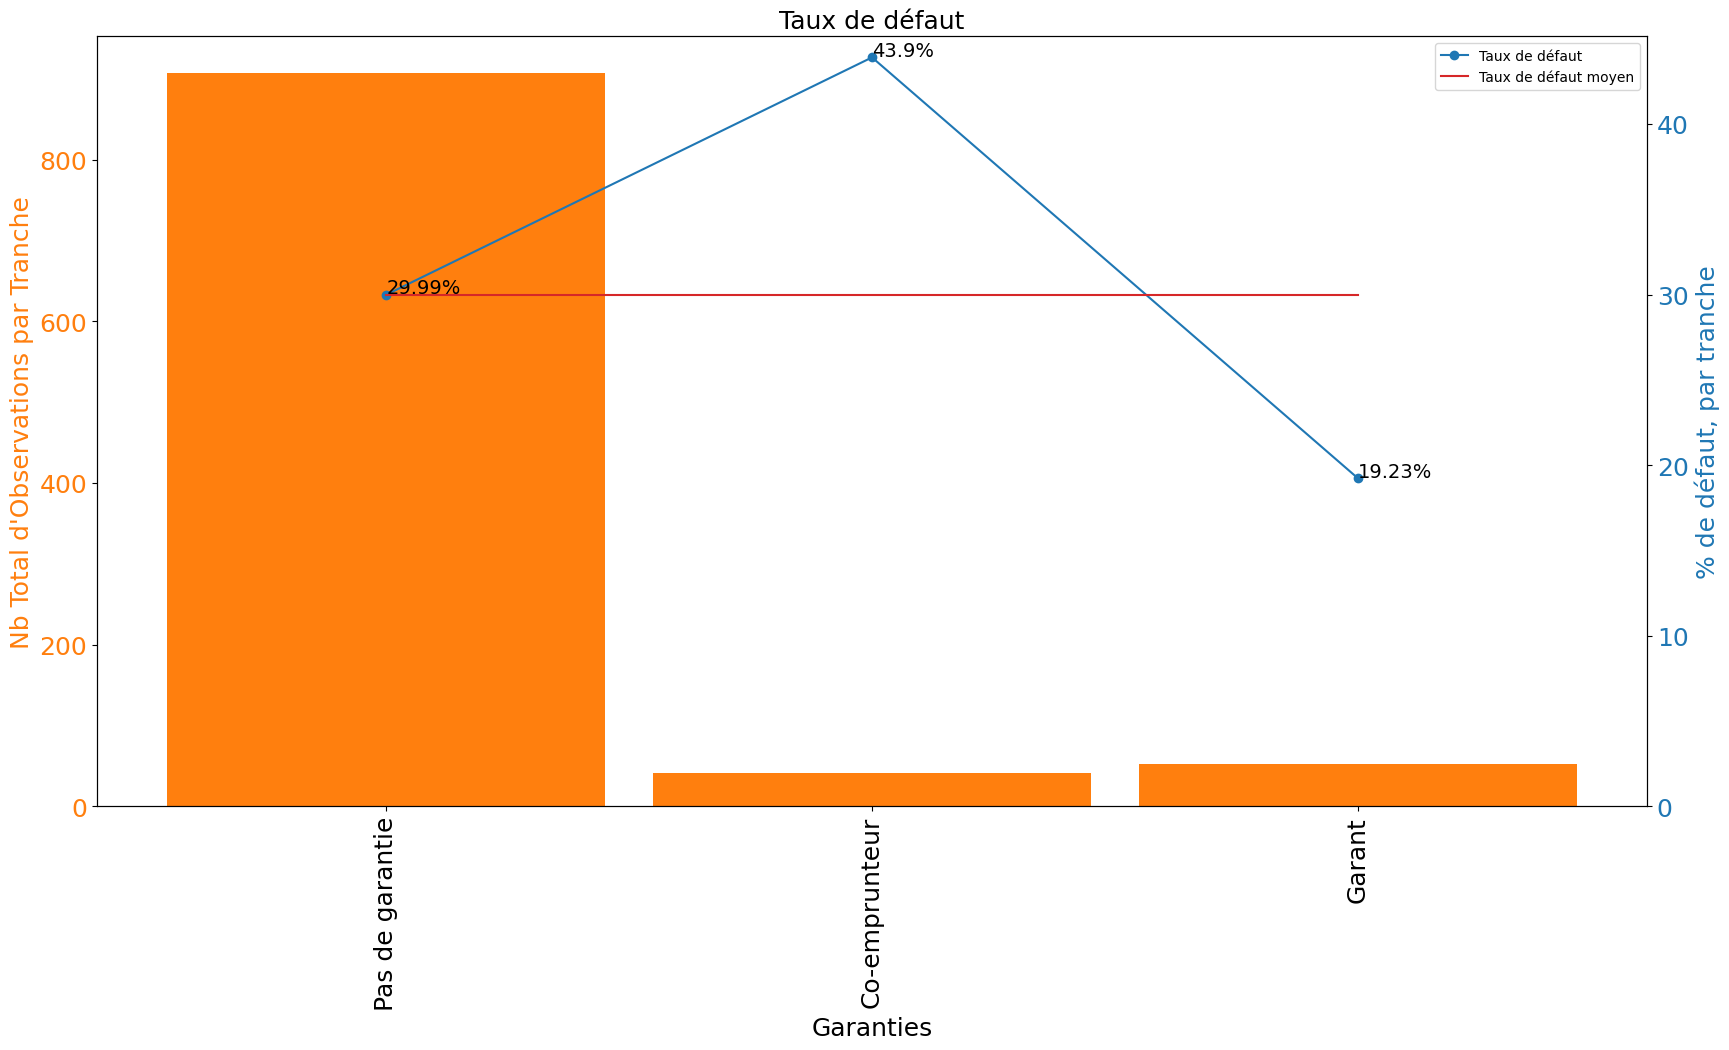

Analyse des taux de défaut en fonction de la variable Telephone


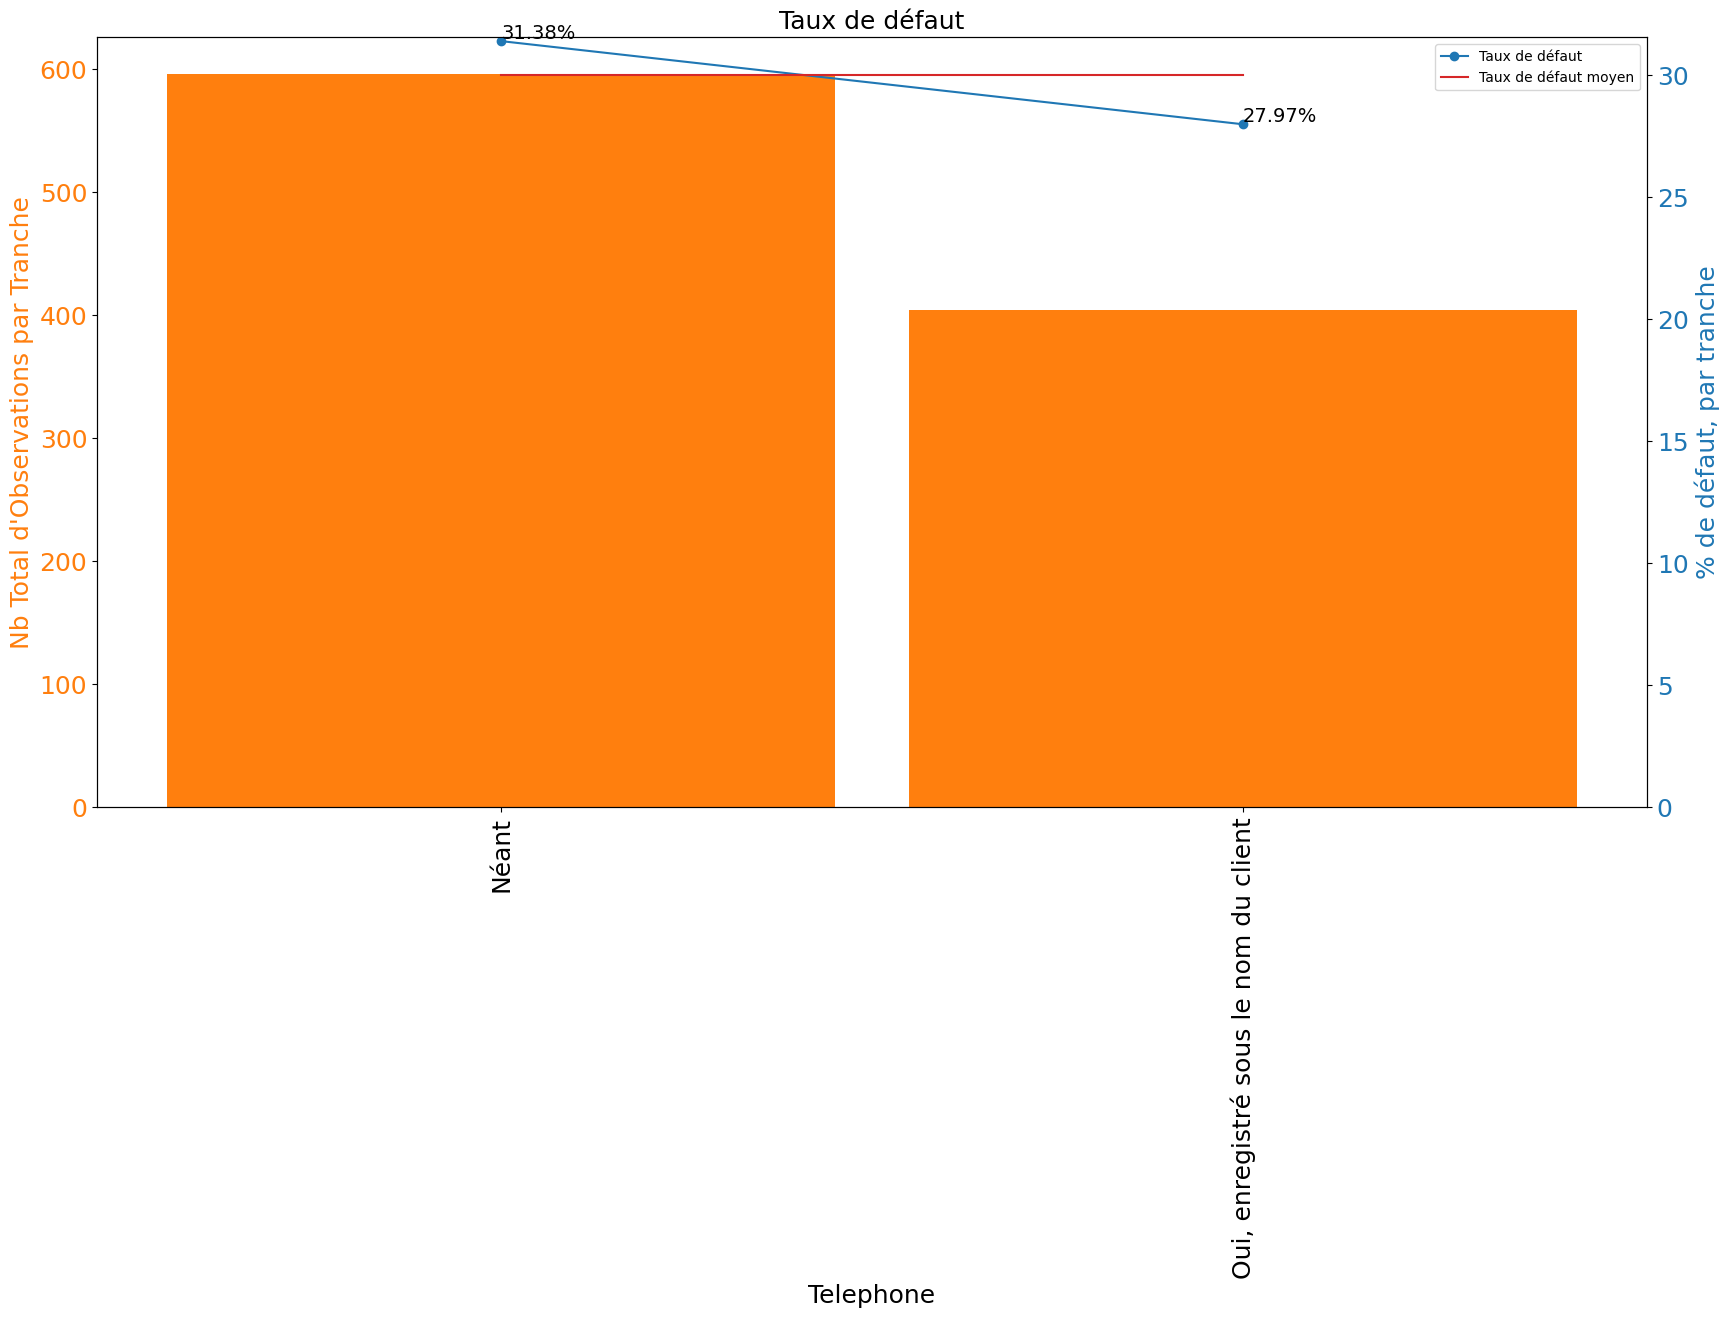

Analyse des taux de défaut en fonction de la variable Nb_pers_charge


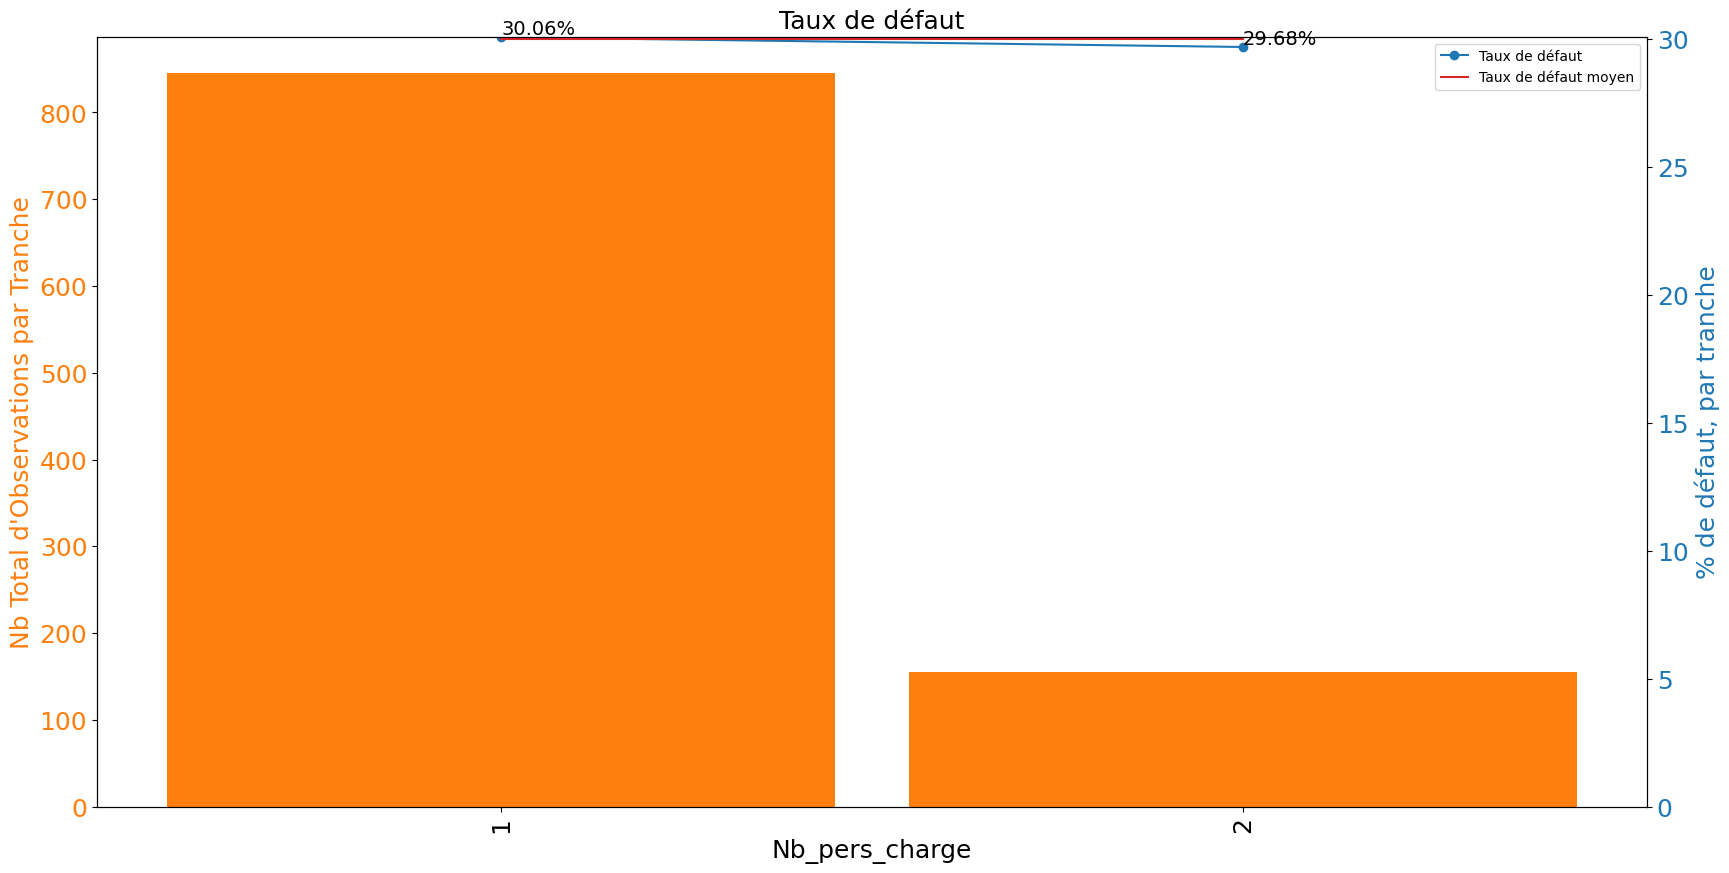

Analyse des taux de défaut en fonction de la variable Etranger


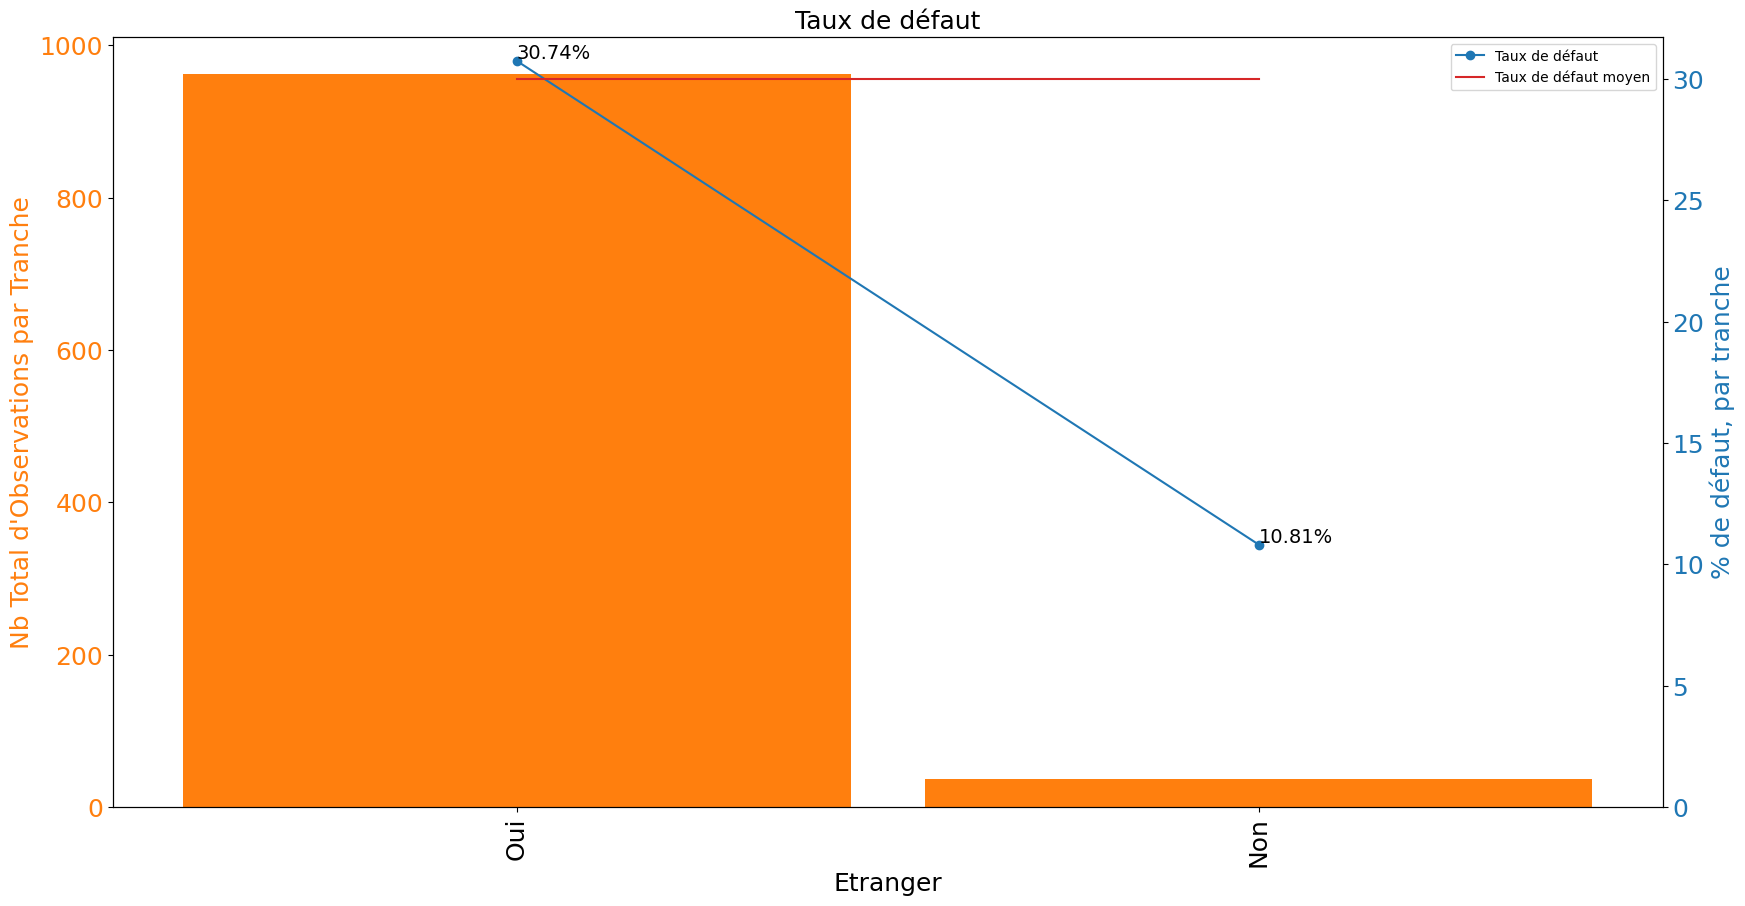

In [48]:
for field in list_var_num+list_var_cat: 
    plot_generic(df,field,target)

## 3. Etude du lien entre variables explicatives et variable cible

<div class="alert alert-block alert-info">
<b>🔔 Rappel :</b> La <b>régression logistique</b> est très sensible à l'existence de multicolinéarités. 
Ainsi, il est préférable de prendre en compte les liens pouvant exister entre les variables afin de choisir plus efficacement celles que nous allons utiliser dans nos modèles de type régression logistique. 
</div>

#### Inutile si j'utilise un `modèle à base d'arbres` ?
1) Pour l'optimisation du modèle : pas nécessaire (voire dégrade le modèle car on retire de l'information)<br>
2) Dans le monde professionnel, très utile :
- permet d'avoir un premier a priori sur les facteurs pouvant expliquer la cible (et c'est plus rapide à lancer qu'un modèle)
- permet d'identifier des variables trop "magiques" càd qui expliquent trop bien la cible. Il est possible qu'il s'agissait 
d'un champ construit selon la cible (ex: numéro de contentieux renseigné --> défaut)
- permet de supprimer les variables sans lien avec la cible ce qui permet d'optimiser les temps de calculs (à l'entrainement
mais surtout en production quand le score sera utilisé)

### 3.1. Lien entre les `variables explicatives catégorielles`

<div class="alert alert-block alert-info">
<b>🔔 Rappel :</b> On peut voir le V de Cramer comme la généralisation d'un test d'indépendance du Chi2
</div>

In [49]:
# Liste des variables catégorielles (pour rappel)
print(f'Liste des variables catégorielles : \n{list_var_cat}')

Liste des variables catégorielles : 
['Objet_credit', 'Historique_credit', 'Epargne', 'Anciennete_emploi', 'Situation_familiale', 'Anciennete_domicile', 'Nb_credits', 'Biens', 'Type_emploi', 'Comptes', 'Taux_effort', 'Autres_credits', 'Statut_domicile', 'Garanties', 'Telephone', 'Nb_pers_charge', 'Etranger']


<div class="alert alert-block alert-warning">
<b> Question 11:</b> en utilisant la fonction <code>cramers_v_between_all</code>, construisez un dataframe (que vous nommerez <code>df_vcramers</code>) contenant l'étude du lien (V de Cramer) entre les variables explicatives catégorielles.
</div>

In [50]:
df_vcramers = cramers_v_between_all(list_var_cat,df)
df_vcramers

,Variable_1,Variable_2,abs_V_cramer,Chi2,Prob_Chi2
95,Biens,Statut_domicile,0.550,605.037,< 0.0001
105,Type_emploi,Telephone,0.426,181.215,< 0.0001
20,Historique_credit,Nb_credits,0.378,429.162,< 0.0001
49,Anciennete_emploi,Type_emploi,0.311,290.745,< 0.0001
68,Situation_familiale,Nb_pers_charge,0.284,80.798,< 0.0001
...,...,...,...,...,...
117,Taux_effort,Garanties,0.025,1.223,0.9757
90,Nb_credits,Etranger,0.022,0.489,0.9212
39,Epargne,Autres_credits,0.020,0.817,0.9992
125,Autres_credits,Etranger,0.019,0.357,0.8365


<div class="alert alert-block alert-warning">
<b> Question 12:</b> Affichez le top10 des variables les plus liées entre elles. Qu'en déduisez-vous ?
</div>

In [51]:
df_vcramers.sort_values('abs_V_cramer',ascending=False).head(10)

,Variable_1,Variable_2,abs_V_cramer,Chi2,Prob_Chi2
95,Biens,Statut_domicile,0.550,605.037,< 0.0001
105,Type_emploi,Telephone,0.426,181.215,< 0.0001
20,Historique_credit,Nb_credits,0.378,429.162,< 0.0001
49,Anciennete_emploi,Type_emploi,0.311,290.745,< 0.0001
68,Situation_familiale,Nb_pers_charge,0.284,80.798,< 0.0001
25,Historique_credit,Autres_credits,0.266,140.982,< 0.0001
46,Anciennete_emploi,Anciennete_domicile,0.261,204.939,< 0.0001
76,Anciennete_domicile,Statut_domicile,0.236,110.998,< 0.0001
13,Objet_credit,Telephone,0.221,48.675,< 0.0001
11,Objet_credit,Statut_domicile,0.207,85.426,< 0.0001


<div class="alert alert-block alert-success">
<b> Réponse:</b> Les liens suivants semblent forts (>0.40) :
<br>- 'Biens' et 'Statut_domicile' ( 0.55 )
<br>- 'Telephone' et 'Type_emploi' ( 0.42 )
</div>   

<div class="alert alert-block alert-warning">
<b> Question 13:</b> Créez un dataframe contenant les couples dont le V de Cramer (absolu) est >0.40. Nommez ce dataframe <code>df_var_cat_liees</code>
</div>

In [52]:
df_vcramers['Prob_Chi2_Numeric'] = pd.to_numeric(df_vcramers['Prob_Chi2'],errors='coerce').fillna(0)
df_var_cat_liees = df_vcramers.loc[(df_vcramers['abs_V_cramer']>.4)&(df_vcramers['Prob_Chi2_Numeric']<.05)]

In [53]:
df_var_cat_liees

,Variable_1,Variable_2,abs_V_cramer,Chi2,Prob_Chi2,Prob_Chi2_Numeric
95,Biens,Statut_domicile,0.550,605.037,< 0.0001,0.0
105,Type_emploi,Telephone,0.426,181.215,< 0.0001,0.0


### 3.2. Lien entre les `variables catégorielles` et la `variable cible`

<div class="alert alert-block alert-warning">
<b> Question 14:</b> En utilisant la fonction <code>cramers_v_with_target</code>, construisez un dataframe (que vous nommerez <code>df_vcramers_target</code>) contenant l'étude du lien (V de Cramer) entre les variables explicatives catégorielles
et la variable cible.
</div>

In [54]:
df_vcramers_target = cramers_v_with_target(list_var_cat,target,df)
df_vcramers_target

,Variable,abs_V_cramer,Chi2,Prob_Chi2
9,Comptes,0.352,123.721,< 0.0001
1,Historique_credit,0.248,61.691,< 0.0001
2,Epargne,0.190,36.099,< 0.0001
0,Objet_credit,0.183,33.356,0.0001
7,Biens,0.154,23.720,< 0.0001
12,Statut_domicile,0.137,18.674,0.0001
3,Anciennete_emploi,0.136,18.368,0.001
11,Autres_credits,0.113,12.839,0.0016
4,Situation_familiale,0.098,9.605,0.0222
13,Garanties,0.082,6.645,0.0361


<div class="alert alert-block alert-warning">
<b> Question 15:</b> Quelles remarques pouvons-nous faire ?
</div>

<div class="alert alert-block alert-success">
<b> Réponse:</b> :
<br>En considérant un seuil de risque alpha=0.05, le lien avec la cible est <b>non significatif </b>pour :
</div>   

In [55]:
df_vcramers_target['Prob_Chi2_Numeric'] = pd.to_numeric(df_vcramers_target['Prob_Chi2'],errors='coerce').fillna(0)
df_cat_non_signif_target = df_vcramers_target.loc[df_vcramers_target['Prob_Chi2_Numeric']>.05]
list_cat_non_signif_target = df_cat_non_signif_target['Variable'].tolist()

print(f"""Lien avec "{target}" non significatif pour les variables: {", ".join(list_cat_non_signif_target)}""")

Lien avec "Cible" non significatif pour les variables: Taux_effort, Nb_credits, Type_emploi, Telephone, Anciennete_domicile, Nb_pers_charge


<div class="alert alert-block alert-warning">
<b> Question 16:</b> En utilisant les sorties de <code>df_vcramers_target</code> et <code>df_var_cat_liees</code>, que pouvons-nous faire ? 
</div>

In [56]:
# Rappel liste des variables fortement liées entre elles
df_var_cat_liees

,Variable_1,Variable_2,abs_V_cramer,Chi2,Prob_Chi2,Prob_Chi2_Numeric
95,Biens,Statut_domicile,0.550,605.037,< 0.0001,0.0
105,Type_emploi,Telephone,0.426,181.215,< 0.0001,0.0


<div class="alert alert-block alert-success">
<b> Réponse:</b> On peut sélectionner la variable à préférer pour chaque couple de variables fortement liées <br>
Entre "Biens" et "Statut_domicile" : on va préférer "Biens" car plus liée à la cible.<br>
Entre "Type_emploi" et "Telephone" : le lien avec la cible est non significatif pour les deux. Donc on exclut les deux<br>
</div>

<div class="alert alert-block alert-warning">
<b> Question 17:</b> Créez la liste <code>list_var_cat_to_drop</code> contenant l'ensemble des variables catégorielles à supprimer
</div>

In [57]:
list_var_cat_to_drop = ["Statut_domicile"]+list_cat_non_signif_target
print(f'Variables catégorielles à supprimer: {list_var_cat_to_drop}')

Variables catégorielles à supprimer: ['Statut_domicile', 'Taux_effort', 'Nb_credits', 'Type_emploi', 'Telephone', 'Anciennete_domicile', 'Nb_pers_charge']


### 3.3 Etude du lien entre les variables explicatives continues 

<div class="alert alert-block alert-warning">
<b> Question 18:</b> Calculez la corrélation linéaire (Pearson) entre les variables continues 
</div>

In [ ]:
df[list_var_num].corr(method='pearson')

,Duree_credit,Montant_credit,Age
Duree_credit,1.000000,0.624988,-0.037550
Montant_credit,0.624988,1.000000,0.032273
Age,-0.037550,0.032273,1.000000


<div class="alert alert-block alert-warning">
<b> Question 19:</b> Utilisez la fonction <code>graph_correlations</code> pour représenter graphiquement la matrice de corrélations
</div>

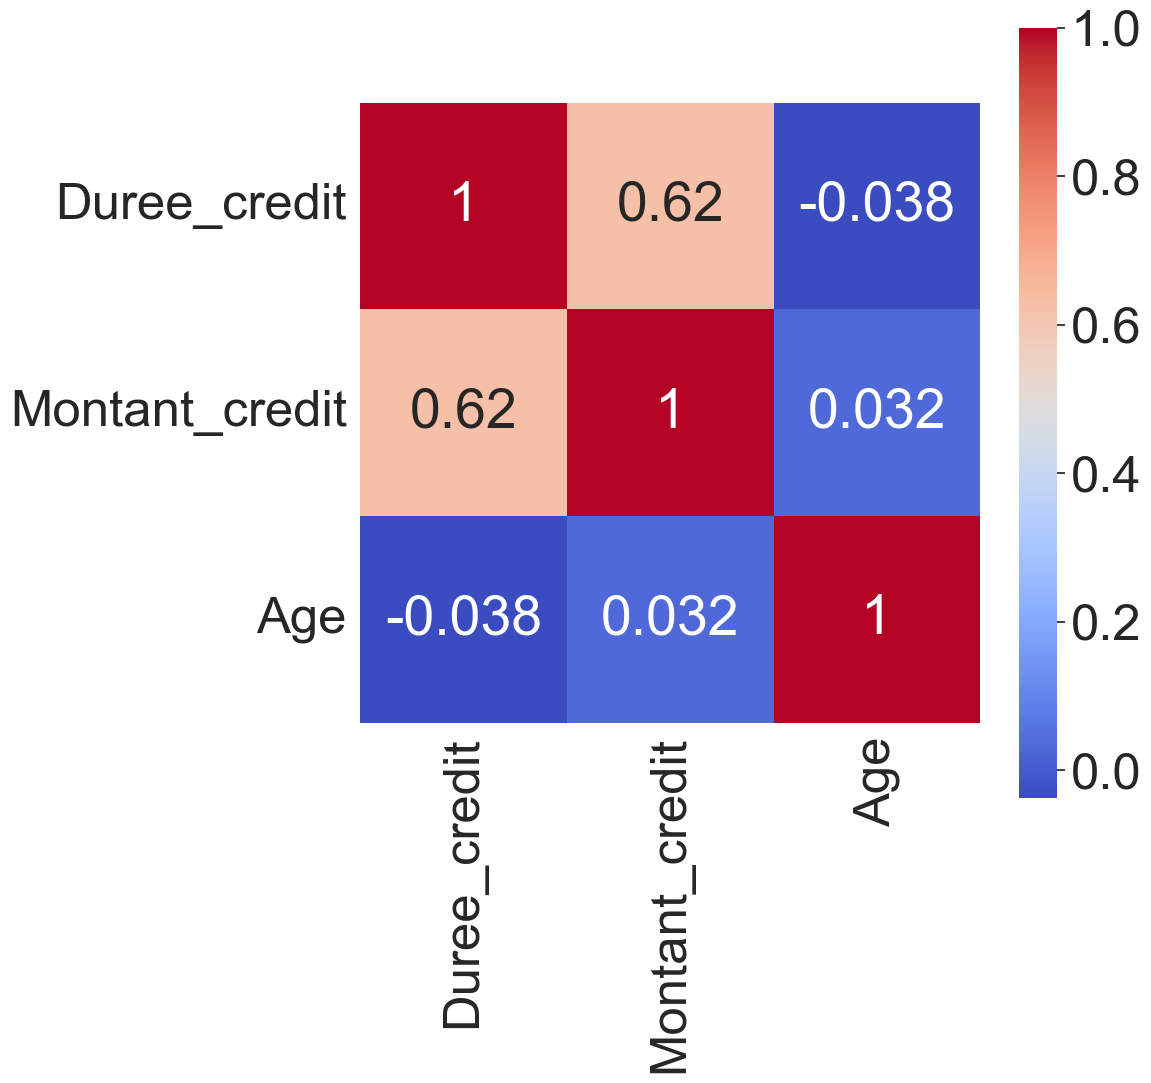

In [59]:
graph_correlations(list_var_num,df)

In [60]:
# Autres méthodes de calcul des corrélations (compare les rangs)
#df_new[var_int].corr(method='spearman')
#df_new[var_int].corr(method='kendall')

<div class="alert alert-block alert-warning">
<b> Question 20:</b> Utilisez la fonction <code>extract_corr_pairs</code> pour stocker dans un dataframe les corrélations linéaires
</div>

In [61]:
corrdf = extract_corr_pairs(df[list_var_num])

In [62]:
corrdf

,var_1,var_2,corr,corr_abs
0,Duree_credit,Montant_credit,0.624988,0.624988
2,Duree_credit,Age,-0.037550,0.037550
1,Montant_credit,Age,0.032273,0.032273


<div class="alert alert-block alert-warning">
<b> Question 21:</b> Affichez les lignes où la corrélation absolue est >=0.5 entre le couple de variables. Stockez les dans un dataframe nommé <code>high_corr_df</code>
</div>

<div class="alert alert-block alert-success">
<b> Réponse:
</div>

In [63]:
### Focus sur les variables explicatives fortement corrélées entre elles
seuil_corr = 0.5
high_corr_df = corrdf[abs(corrdf['corr'])>=seuil_corr]
high_corr_df

,var_1,var_2,corr,corr_abs
0,Duree_credit,Montant_credit,0.624988,0.624988


### 3.4 Lien entre les variables explicatives continues et la variable cible

Application du Welch’s t-test

<div class="alert alert-block alert-info">
<b>🔔 Rappel :</b> Le Welch’s t-test est un test de Student où on relâche l'hypothèse d'équivariance entre les 2 populations.<br>
H0 : Les distributions de x|y=1 et x|y=0 sont les mêmes (avec x: variable explicative continue, y:variable cible bimodale)
</div>

In [64]:
for field in list_var_num:
    a=list(df[df[target]==0][field])
    b=list(df[df[target]==1][field])
    st_test, st_p = st.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='omit')
    print(field + ": p-value test Student = " + str(st_p))

Duree_credit: p-value test Student = 2.404080859858094e-10
Montant_credit: p-value test Student = 2.4771030604498743e-05
Age: p-value test Student = 0.0037781754383747943


<div class="alert alert-block alert-warning">
<b> Question 22:</b> Qu'en déduisez-vous (à un seuil alpha=0.05)?
</div>

<div class="alert alert-block alert-success">
<b> Réponse: </b> Les liens avec la variable cible sont significatifs pour les 3 variables continues 
</div>